In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab.utils.logging import ListLogger
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from tqdm import tqdm


from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import torch

from typing import Tuple, Optional
import torch
from functorch import vmap


from functools import partial


import torchsde
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable


from torchdiffeq import odeint
from torch.func import jacrev


import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import ConditionalFlowMatcher
from torchcfm.models.models import *
from torchcfm.utils import *

from models.augmentation import AugmentedVectorField, CNFReg

from models.egnn import remove_mean, EGNN_dynamics

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Helpers

In [9]:
from abc import ABC, abstractmethod

class NoiseSchedule(ABC):
    @abstractmethod
    def g(t):
        # Returns g(t)
        pass
    
    @abstractmethod
    def h(t):
        # Returns \int_0^t g(t)^2 dt
        pass

    
class LinearNoiseSchedule(NoiseSchedule):
    def __init__(self, beta, norm_factor=1.0):
        self.beta = beta / norm_factor
        
    def g(self, t):
        return torch.sqrt(self.beta * 2 * t) #self.beta.sqrt()
    
    def h(self, t):
        return self.beta * t **2

class GeometricNoiseSchedule(NoiseSchedule):
    def __init__(self, sigma_min, sigma_max, norm_factor=1.0):
        self.sigma_min = sigma_min / norm_factor
        self.sigma_max = sigma_max / norm_factor
        self.sigma_diff = self.sigma_max / self.sigma_min
        
    def g(self, t):
        # Let sigma_d = sigma_max / sigma_min
        # Then g(t) = sigma_min * sigma_d^t * sqrt{2 * log(sigma_d)}
        # See Eq 192 in https://arxiv.org/pdf/2206.00364.pdf
        return self.sigma_min * (self.sigma_diff ** t) * ((2 * np.log(self.sigma_diff)) ** 0.5)
        
    def h(self, t):
        # Let sigma_d = sigma_max / sigma_min
        # Then h(t) = \int_0^t g(z)^2 dz = sigma_min * sqrt{sigma_d^{2t} - 1}
        # see Eq 199 in https://arxiv.org/pdf/2206.00364.pdf
        return (self.sigma_min * (((self.sigma_diff ** (2 * t)) - 1) ** 0.5)) ** 2

In [20]:
def sample_from_array(array, size):
    idx = np.random.choice(array.shape[0], size=size)
    return array[idx]

### Estimate

In [10]:
# calculate the log expectation of the reward
def log_E_R(_x, _t, noise_schedule, num_mc_samples, var_exploding=True):
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t  = noise_schedule.h(repeated_t)
    h_t = h_t.unsqueeze(1)
    if var_exploding:
        # variance exploding
        samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
        log_rewards = log_prob(samples)
        log_expectation_R = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    else:
        # variance preserving
        samples = (repeated_x/torch.sqrt(1 - repeated_t.unsqueeze(1)) 
                   + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5))
        log_rewards = log_prob(samples)
        log_expectation_R = torch.log(1 / (1 - _t)) + torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    return log_expectation_R

In [11]:
def estimate_grad_Rt(x, t, noise_schedule, num_mc_samples=100, var_exploding=True, richardson=False):
    est_scores_n = torch.func.grad(log_E_R)(x, t, noise_schedule, num_mc_samples, var_exploding=var_exploding)
    if richardson:
        est_scores_n_div2 = torch.func.grad(log_E_R)(x, t, noise_schedule, num_mc_samples//2, var_exploding=var_exploding)
        return (2*est_scores_n - est_scores_n_div2)
    else:
        return est_scores_n

### VE SDE

In [23]:
class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score, noise_schedule):
        super().__init__()
        self.score = score
        self.noise_schedule = noise_schedule
    
    def f(self, t, x):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(device)

        x.requires_grad = True
        score = torch.vmap(self.score, randomness="different", in_dims=(0, 0, None))(x, 1-t, self.noise_schedule)
        norm = torch.linalg.vector_norm(score, dim=-1)
        max_norm = 50
        clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
        return self.g(t)**2 * score * clip_coef[:,None]

    def g(self, t):
        return self.noise_schedule.g(t.unsqueeze(1))

In [24]:
def euler_maruyama_step(sde, x, t, dt):
    # Calculate drift and diffusion terms
    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones(x.shape[0]).to(device)
    
    drift = sde.f(t, x) * dt
    diffusion = sde.g(t) * np.sqrt(dt) * torch.randn_like(x).to(device)

    # Update the state
    x_next = x + drift + diffusion
    return x_next, drift

def integrate_sde(sde, x0, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    vectors = []
    samples = []
    with torch.no_grad():
        for t in times:
            x, f = euler_maruyama_step(sde, x, t, dt)
            samples.append(x)
            vectors.append(f)
    return torch.stack(samples)

### LJ13 Energy 

In [25]:
def get_senders_and_receivers_fully_connected(n_nodes):
    receivers = []
    senders = []
    for i in range(n_nodes):
        for j in range(n_nodes - 1):
            receivers.append(i)
            senders.append((i + 1 + j) % n_nodes)
    return torch.tensor(senders), torch.tensor(receivers)

def energy(x, epsilon= 1.0, tau= 1.0, r= 1.0, harmonic_potential_coef= 0.5):
    n_nodes, dim = x.shape
    
    if isinstance(r, float):
        r = torch.ones(n_nodes, device=device) * r
    senders, receivers = get_senders_and_receivers_fully_connected(n_nodes)
    vectors = x[senders] - x[receivers]
    d = torch.linalg.norm(vectors, ord=2, dim=-1)
    term_inside_sum = (r[receivers] / d)**12 - 2*(r[receivers] / d)**6
    energy = epsilon / (2 * tau) * term_inside_sum.sum()

    centre_of_mass = x.mean(dim=0)
    harmonic_potential = harmonic_potential_coef * (x - centre_of_mass).pow(2).sum()
    return energy + harmonic_potential


def log_prob(x: torch.Tensor):
    x = x.reshape(-1, 13, 3)
    if len(x.shape) == 2:
        return - energy(x)
    elif len(x.shape) == 3:
        return - torch.vmap(energy)(x)
    else:
        raise Exception

In [26]:
def interatomic_dist(samples):
    # Compute the pairwise differences and distances
    dist = samples[:, None, :, :] - samples[:, :, None, :]
    differences = torch.linalg.norm(dist, dim=-1)
    return differences #torch.mean(differences, dim=(1, 2))

In [27]:
def plot_sample_hist(samples, ax = None, dim=(0,1), label=None):
    if ax == None:
        fig, ax = plt.subplots()
    d = interatomic_dist(samples)
    ax.hist(d, bins=50, density=True, alpha=0.4, label=label)

### Dataset

In [38]:
sigma = np.sqrt(1.5)
beta = torch.tensor(sigma ** 2)
dim = 3
n_nodes = 13
n_samples = 500


noise_schedule = LinearNoiseSchedule(beta, norm_factor=1.0)

centers = torch.zeros((n_samples, n_nodes*dim), device=device)
x1_samples = torch.randn((2048, n_nodes*dim), device=device) * np.sqrt(beta)

ve_reverse_sde = VEReverseSDE(estimate_grad_Rt, noise_schedule)
train_data = integrate_sde(ve_reverse_sde, x1_samples, [0, 1], 1e-3)[-1]

In [29]:
samples_all_2 = np.load('data/all_data_LJ13-2.npy')
test_data = samples_all_2[len(samples_all_2)//2:]
test_data = sample_from_array(test_data, 1000)
del samples_all_2
test_data = torch.tensor(test_data, device=device)
test_dists = interatomic_dist(test_data.reshape(-1, n_nodes, dim))

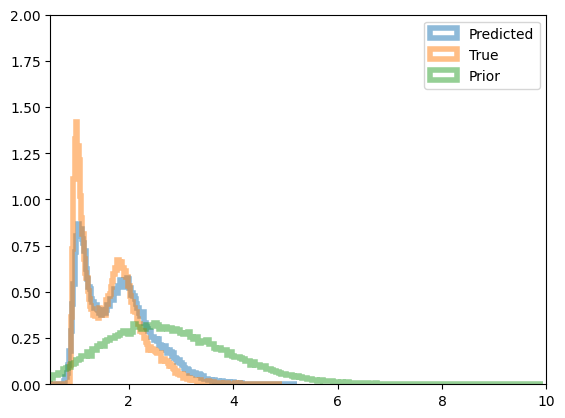

In [30]:
pred_dists = interatomic_dist(samples_pred[-1].reshape(-1, n_nodes, dim)).detach()
test_dists = interatomic_dist(test_data.reshape(-1, n_nodes, dim))
x1_dists = interatomic_dist(x1_samples.reshape(-1, n_nodes, dim)).detach()

plt.hist(pred_dists.view(-1).cpu().numpy(), bins=200, alpha=0.5, density=True,
          histtype='step', linewidth=4, label='Predicted')
plt.hist(test_dists.view(-1).cpu().numpy(), bins=200, alpha=0.5, density=True,
          histtype='step', linewidth=4, label='True')
plt.hist(x1_dists.view(-1).cpu().numpy(), bins=200, alpha=0.5, density=True,
         histtype='step', linewidth=4, label='Prior')

plt.xlim(0.5, 10)
plt.ylim(0, 2)
plt.legend()
plt.show()

### Model

In [39]:
from egnn_pytorch import EGNN_Network
class EGNN_Wrapper(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.net = EGNN_Network(
            *args, **kwargs
        )

    def forward(self, x, t, *args, **kwargs):
        is_flat = x.shape[-1] != 3
        if is_flat:
            x = x.reshape(-1, 13, 3)
        if t.dim() == 0:
            t = t[None].repeat(x.shape[0])
        if t.shape[0] != x.shape[0] and t.shape[0] == 1:
            t = t.repeat(x.shape[0])
        t_discrete = torch.bucketize(t, boundaries = torch.linspace(0, 1, 101).to(device))
        t_discrete = t_discrete[:, None].repeat(1, 13) #
        x = x - x.mean(dim=-2, keepdims=True)
        feats, coords = self.net(t_discrete, x)
        # coords = coords / coords.mean(dim=-2, keepdims=True)
        if is_flat:
            coords = coords.reshape(-1, 39)
        
        return coords

### Helpers

In [57]:
def sample_centered_gaussian(shape):
    samples = torch.randn(shape).to(device)
    samples = samples - samples.mean(-2, keepdims=True)
    return samples
def sample_data(data, batch_size):
    idx = torch.randint(0,8000, (batch_size, ))
    return data[idx].positions

In [58]:
def center_gravity_zero_gaussian_log_likelihood(x):
    N, D = x.shape[-2:]

    # r is invariant to a basis change in the relevant hyperplane.
    r2 = torch.sum(x**2, dim=(-1, -2))

    # The relevant hyperplane is (N-1) * D dimensional.
    degrees_of_freedom = (N-1) * D

    # Normalizing constant and logpx are computed:
    log_normalizing_constant = -0.5 * degrees_of_freedom * math.log(2*torch.pi)
    log_px = -0.5 * r2 + log_normalizing_constant

    return log_px

In [59]:
def cfm_inference(model, xt, t, dt):
    with torch.no_grad():
        vt = model(t, xt)
        xt_new = xt + vt * dt
        return xt_new

In [60]:
def generate_samples_ode(model, x_init, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt)
    samples = []
    x = x_init
    with torch.no_grad():
        for t in times:
            x = cfm_inference(model, x, t, 1e-3)
            samples.append(x)
    return torch.stack(samples)

### CFM Training 

In [85]:
sigma = 0.0
batch_size = 512
model = EGNN_dynamics(n_particles=n_nodes, device=device,  n_dimension=dim, hidden_nf=32, 
                      act_fn=torch.nn.SiLU(), n_layers=3, recurrent=True, tanh=True, attention=True, 
                      condition_time=True, agg='sum')


amodel = AugmentedVectorField(model, [CNFReg("exact")], dim=(13, 3))
node = NeuralODE(amodel, solver="euler")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [86]:
FM = ConditionalFlowMatcher(sigma=sigma)

In [87]:
def cfm_loss(model, x1):
    x1 = x1.reshape(-1, 13, 3)
    x0 = sample_centered_gaussian((x1.shape[0], 13, 3))

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
    xt = xt.reshape(-1, 39)
    ut = ut.reshape(-1, 39)

    # xt_centered = xt - xt.mean(dim=-2, keepdims=True)

    vt = model(t[:, None], xt)
    loss = torch.mean((vt - ut) ** 2)
    return loss

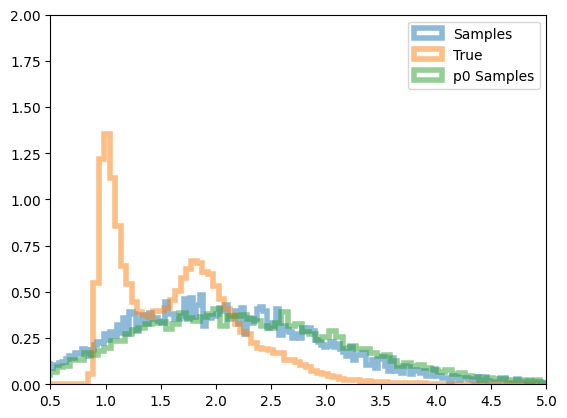

0 tensor(41.1580, device='cuda:0') tensor(42.1001, device='cuda:0')


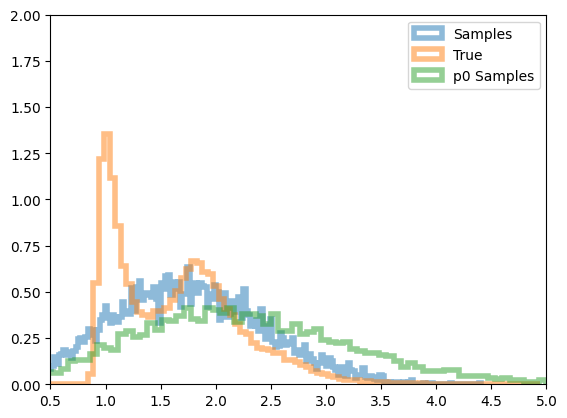

100 tensor(38.7929, device='cuda:0') tensor(39.2129, device='cuda:0')


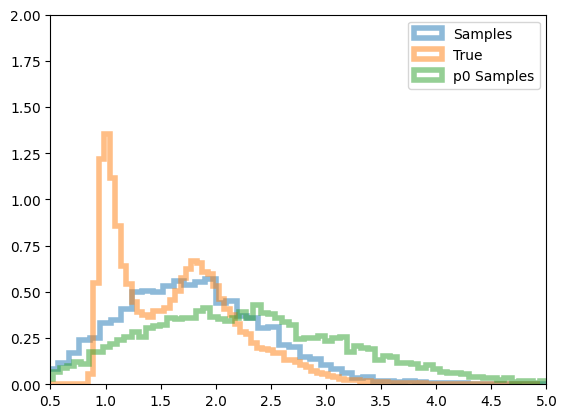

200 tensor(37.7456, device='cuda:0') tensor(37.9159, device='cuda:0')


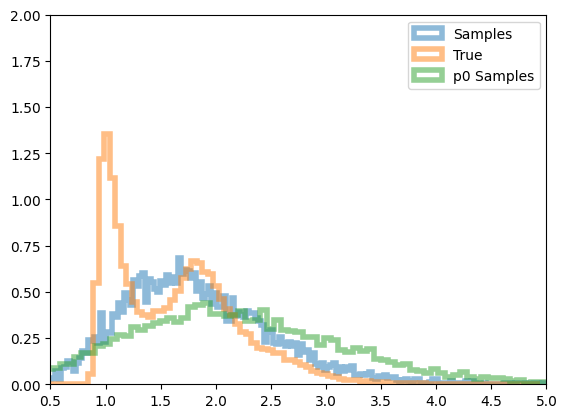

300 tensor(39.3004, device='cuda:0') tensor(36.2389, device='cuda:0')


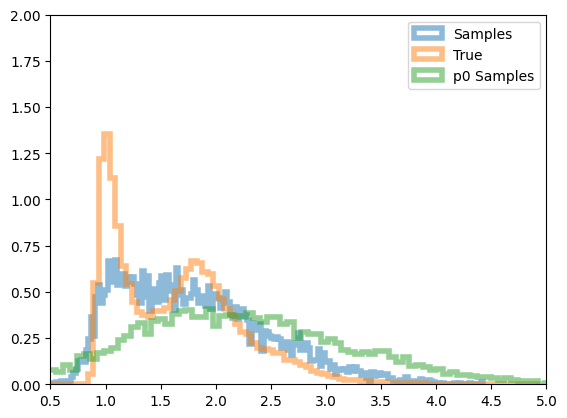

400 tensor(28.2615, device='cuda:0') tensor(34.2780, device='cuda:0')


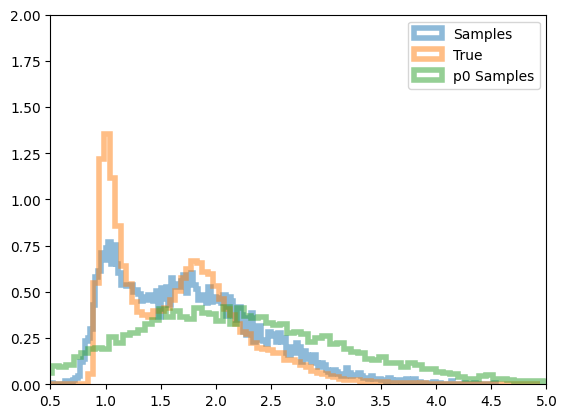

500 tensor(25.3906, device='cuda:0') tensor(33.9880, device='cuda:0')


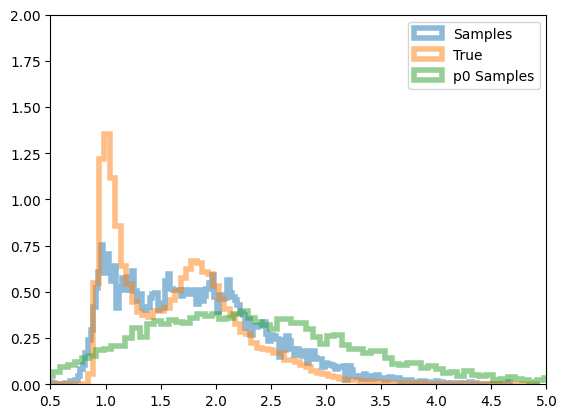

600 tensor(23.6998, device='cuda:0') tensor(32.1888, device='cuda:0')


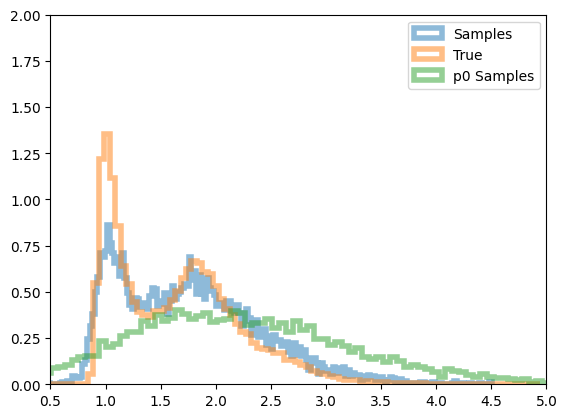

700 tensor(22.7485, device='cuda:0') tensor(32.4466, device='cuda:0')


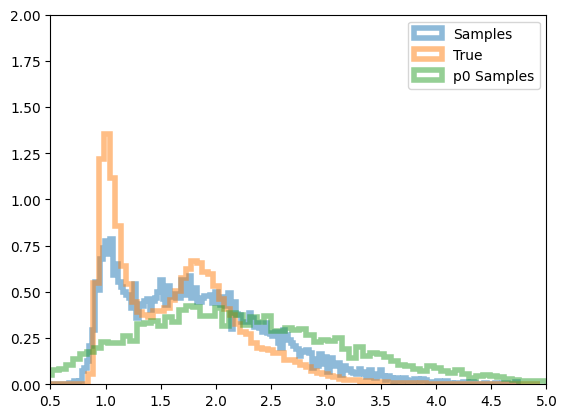

800 tensor(24.0239, device='cuda:0') tensor(32.4964, device='cuda:0')


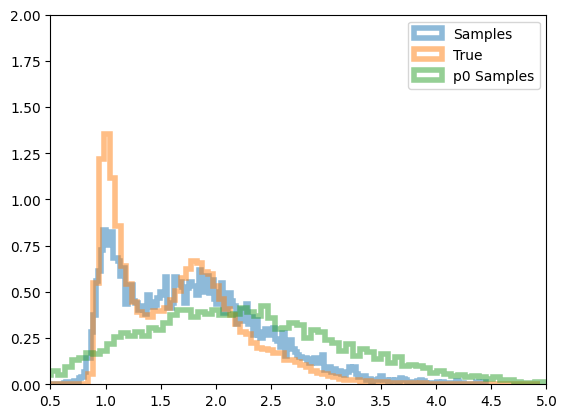

900 tensor(22.4174, device='cuda:0') tensor(32.1935, device='cuda:0')


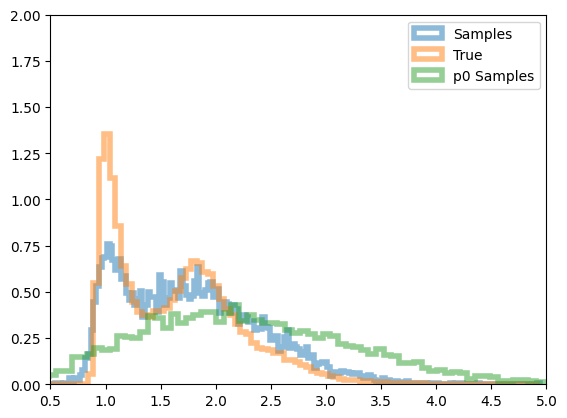

1000 tensor(21.9038, device='cuda:0') tensor(30.5929, device='cuda:0')


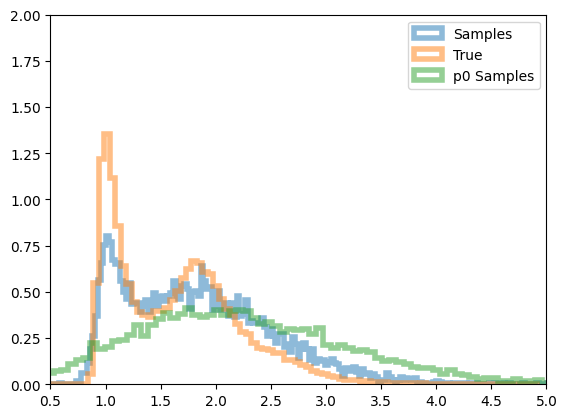

1100 tensor(22.9470, device='cuda:0') tensor(31.5805, device='cuda:0')


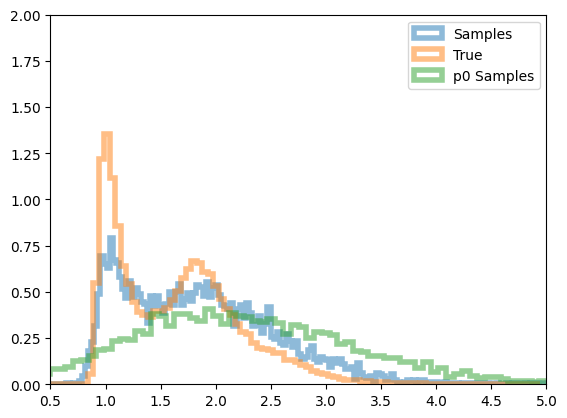

1200 tensor(22.9167, device='cuda:0') tensor(31.0159, device='cuda:0')


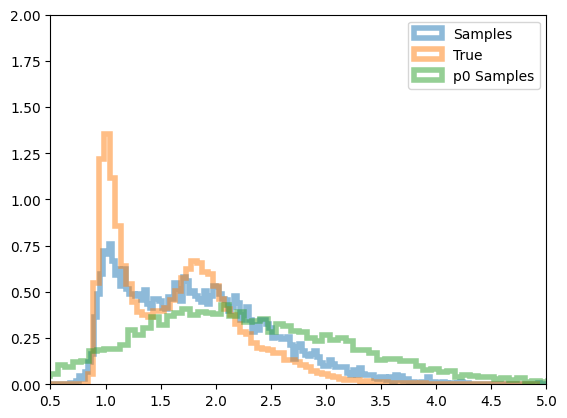

1300 tensor(21.9514, device='cuda:0') tensor(30.7062, device='cuda:0')


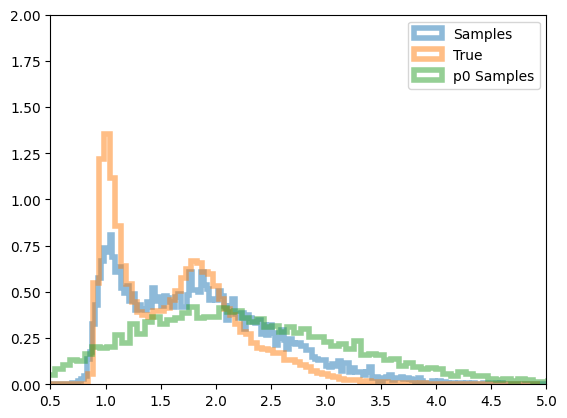

1400 tensor(22.1354, device='cuda:0') tensor(29.8792, device='cuda:0')


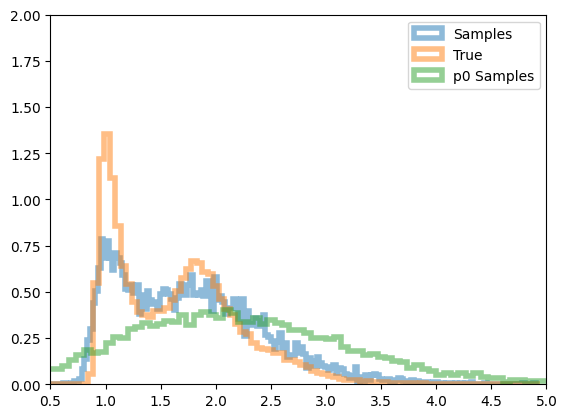

1500 tensor(21.0549, device='cuda:0') tensor(28.2225, device='cuda:0')


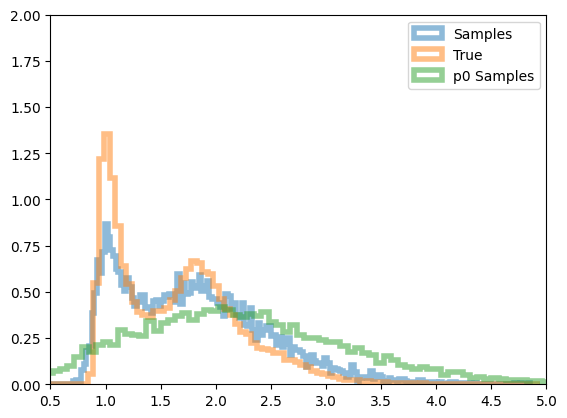

1600 tensor(20.8028, device='cuda:0') tensor(28.4387, device='cuda:0')


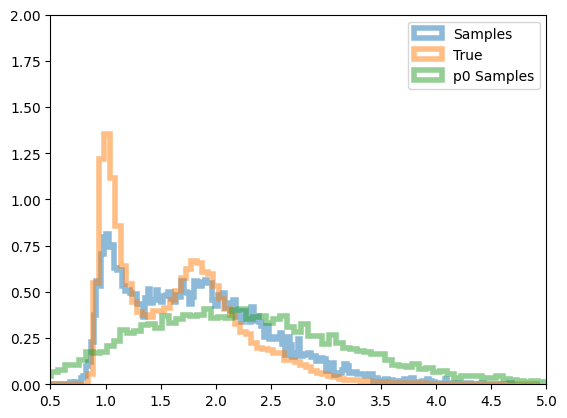

1700 tensor(21.1285, device='cuda:0') tensor(28.2739, device='cuda:0')


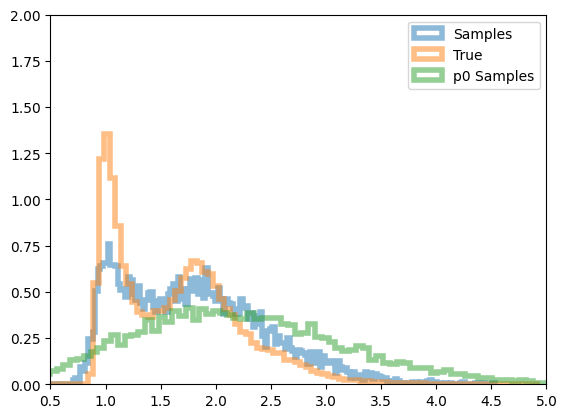

1800 tensor(22.4720, device='cuda:0') tensor(28.2663, device='cuda:0')


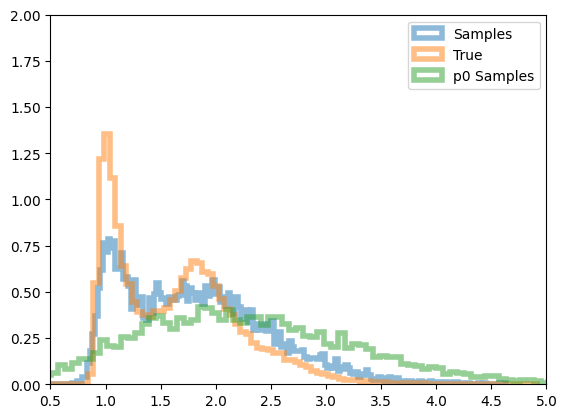

1900 tensor(21.0763, device='cuda:0') tensor(27.9461, device='cuda:0')


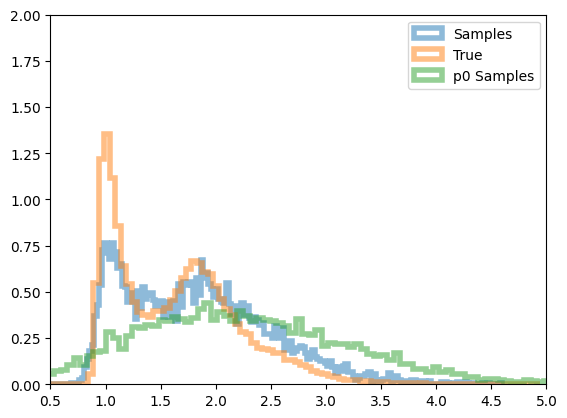

2000 tensor(21.9458, device='cuda:0') tensor(27.9744, device='cuda:0')


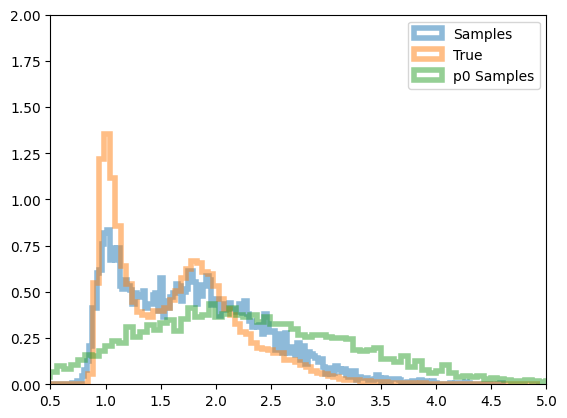

2100 tensor(20.4184, device='cuda:0') tensor(27.5346, device='cuda:0')


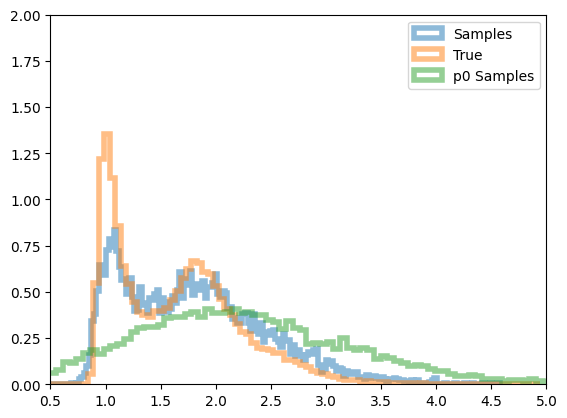

2200 tensor(20.9765, device='cuda:0') tensor(27.5537, device='cuda:0')


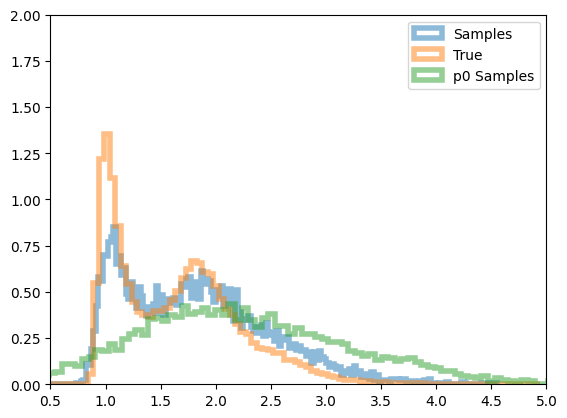

2300 tensor(21.0756, device='cuda:0') tensor(27.7055, device='cuda:0')


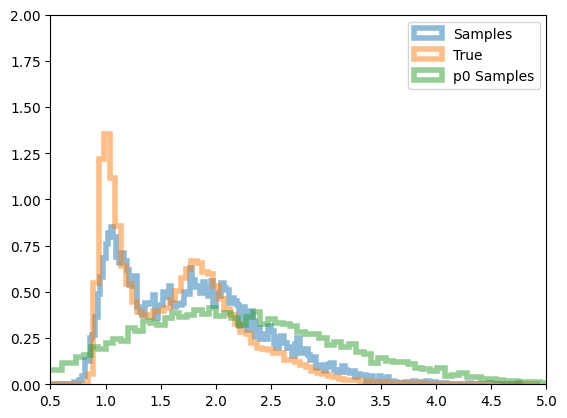

2400 tensor(21.6520, device='cuda:0') tensor(27.3616, device='cuda:0')


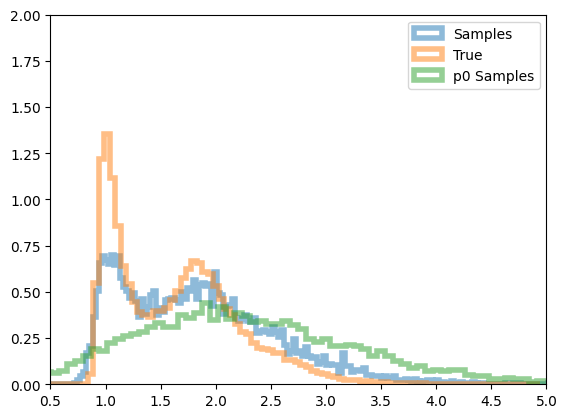

2500 tensor(21.8663, device='cuda:0') tensor(27.7605, device='cuda:0')


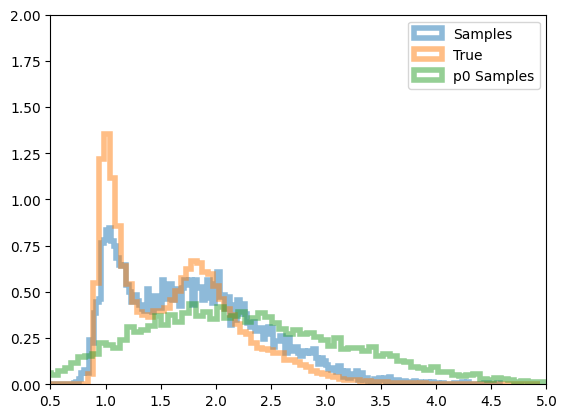

2600 tensor(21.0059, device='cuda:0') tensor(27.2098, device='cuda:0')


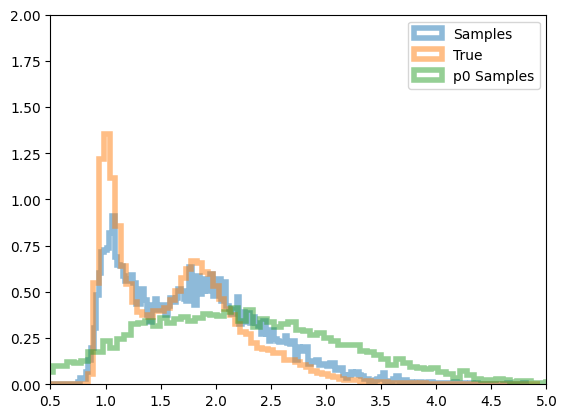

2700 tensor(20.5816, device='cuda:0') tensor(27.4012, device='cuda:0')


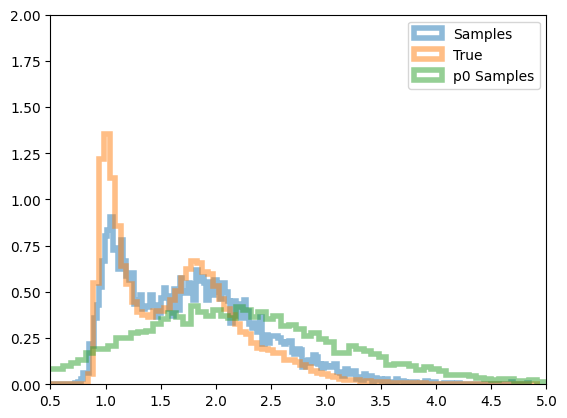

2800 tensor(20.7989, device='cuda:0') tensor(27.0783, device='cuda:0')


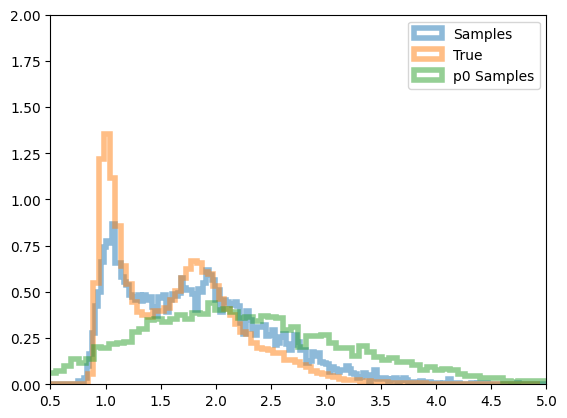

2900 tensor(20.6289, device='cuda:0') tensor(27.5352, device='cuda:0')


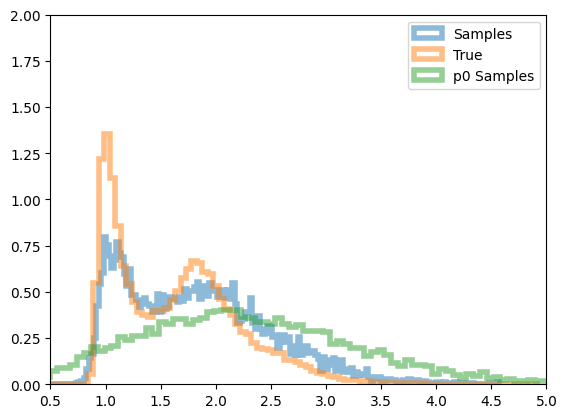

3000 tensor(21.6251, device='cuda:0') tensor(27.5060, device='cuda:0')


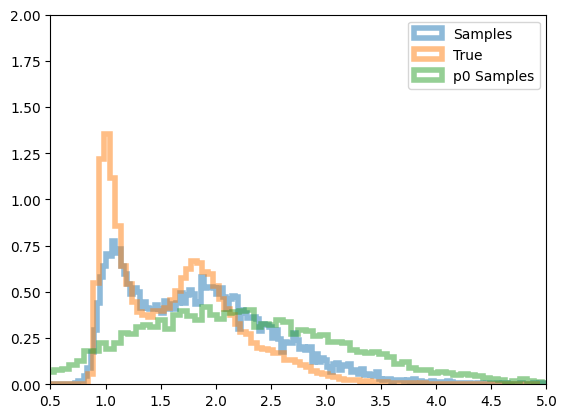

3100 tensor(22.0307, device='cuda:0') tensor(27.6540, device='cuda:0')


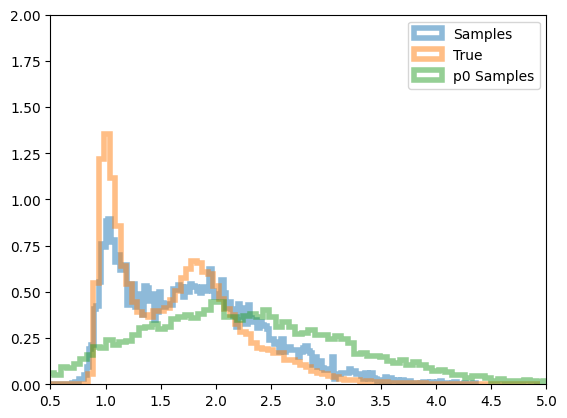

3200 tensor(20.3856, device='cuda:0') tensor(26.8721, device='cuda:0')


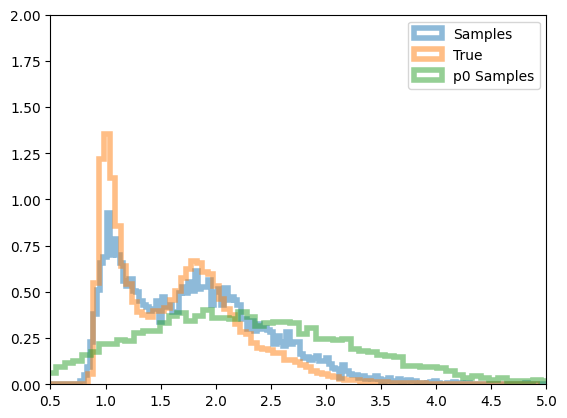

3300 tensor(20.4562, device='cuda:0') tensor(26.8965, device='cuda:0')


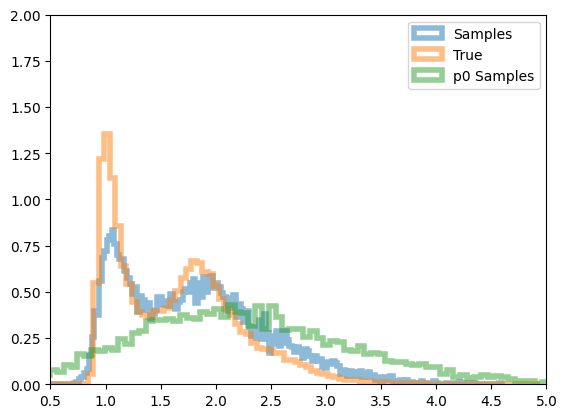

3400 tensor(21.2879, device='cuda:0') tensor(26.9567, device='cuda:0')


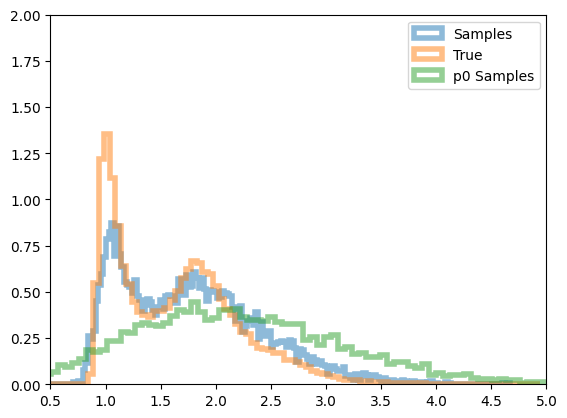

3500 tensor(21.2349, device='cuda:0') tensor(26.9766, device='cuda:0')


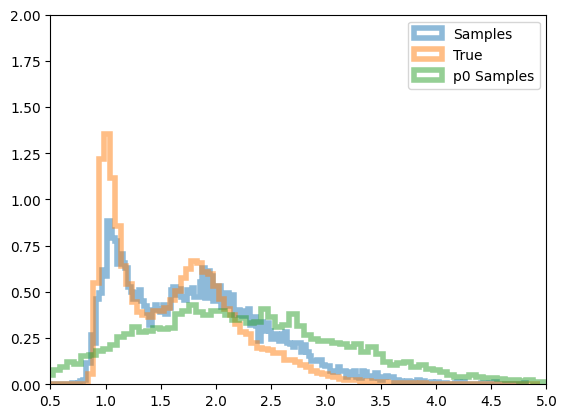

3600 tensor(20.6876, device='cuda:0') tensor(26.9683, device='cuda:0')


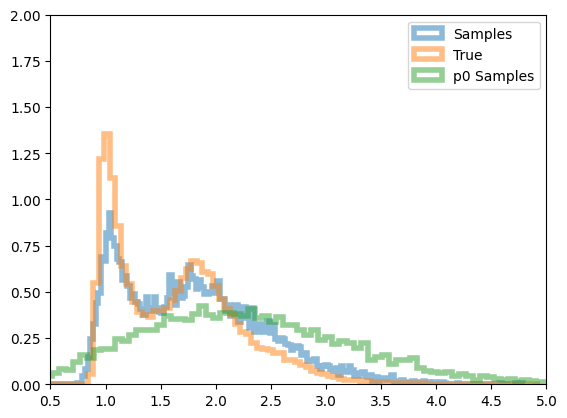

3700 tensor(20.0555, device='cuda:0') tensor(26.8900, device='cuda:0')


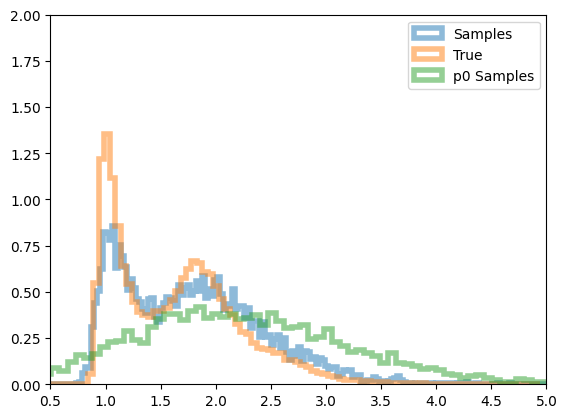

3800 tensor(19.5232, device='cuda:0') tensor(26.6451, device='cuda:0')


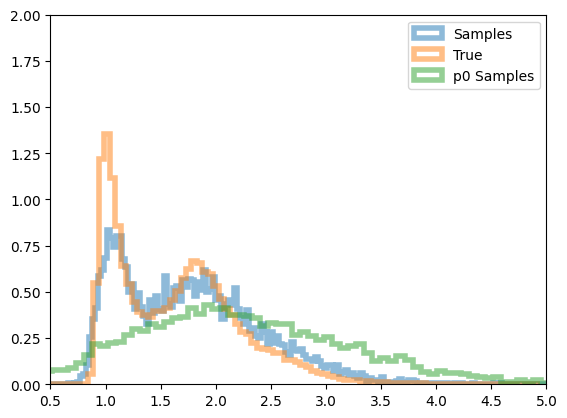

3900 tensor(19.8513, device='cuda:0') tensor(26.5709, device='cuda:0')


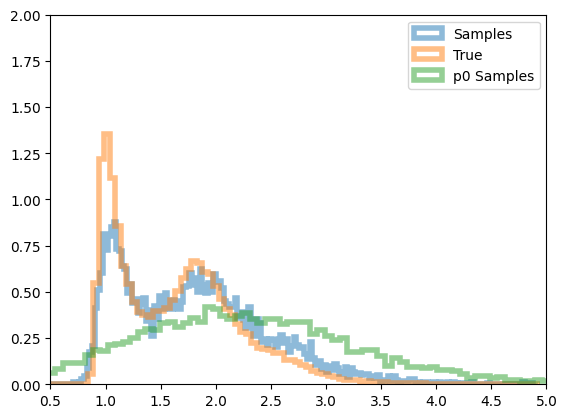

4000 tensor(19.3364, device='cuda:0') tensor(26.5256, device='cuda:0')


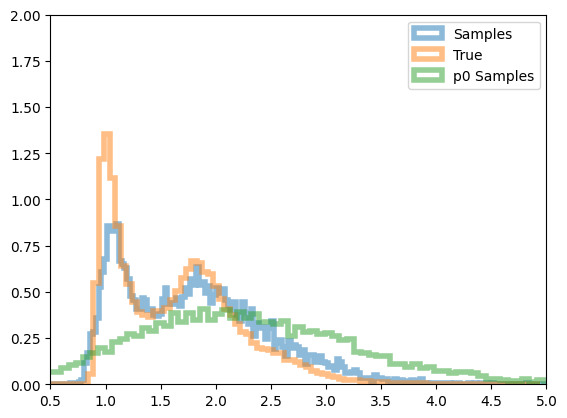

4100 tensor(20.0505, device='cuda:0') tensor(26.6830, device='cuda:0')


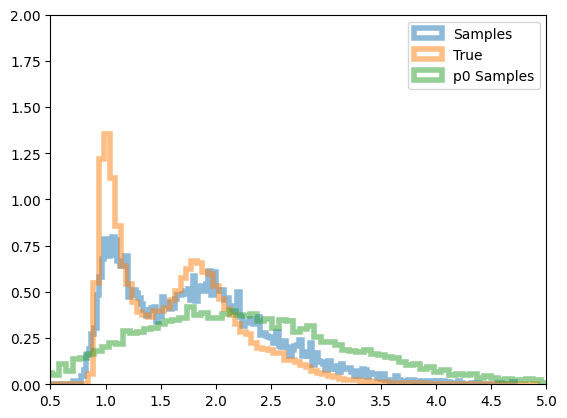

4200 tensor(20.6492, device='cuda:0') tensor(27.0164, device='cuda:0')


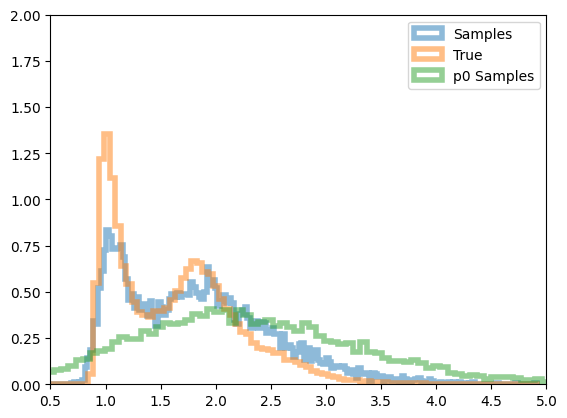

4300 tensor(19.9900, device='cuda:0') tensor(26.7335, device='cuda:0')


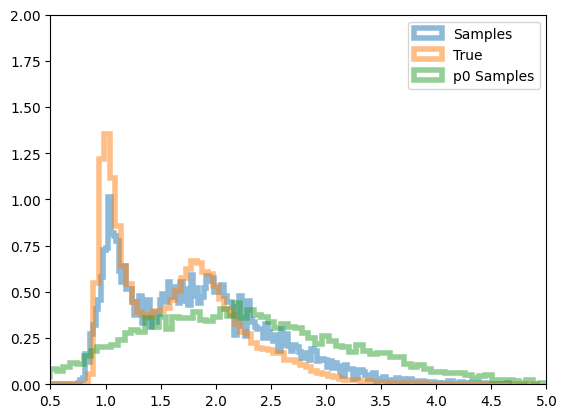

4400 tensor(20.0976, device='cuda:0') tensor(26.7700, device='cuda:0')


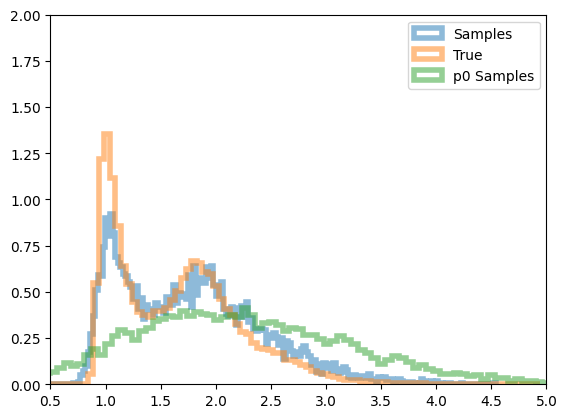

4500 tensor(19.4473, device='cuda:0') tensor(26.4928, device='cuda:0')


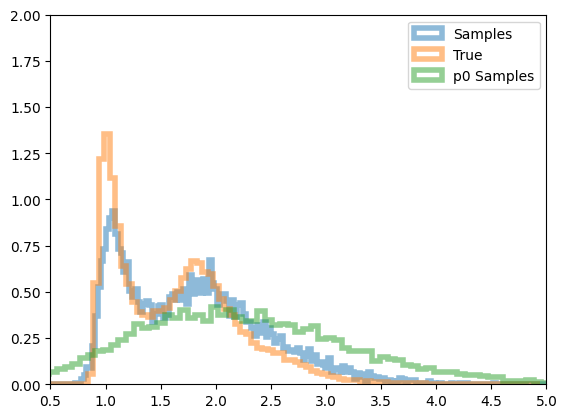

4600 tensor(19.0250, device='cuda:0') tensor(26.9139, device='cuda:0')


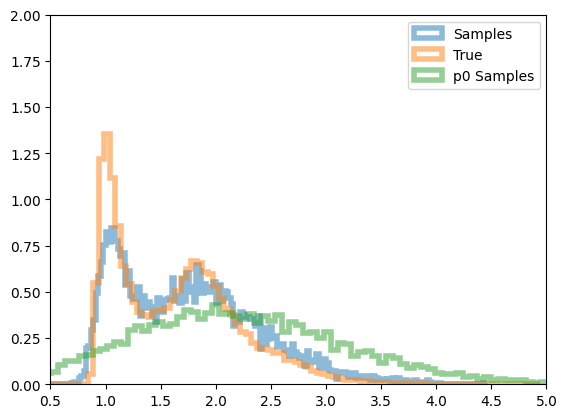

4700 tensor(19.1392, device='cuda:0') tensor(26.6087, device='cuda:0')


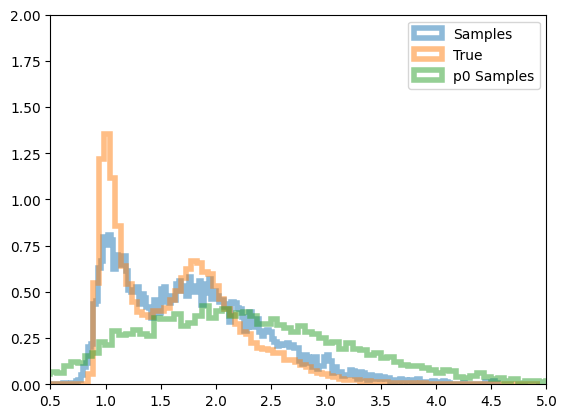

4800 tensor(19.8218, device='cuda:0') tensor(26.7198, device='cuda:0')


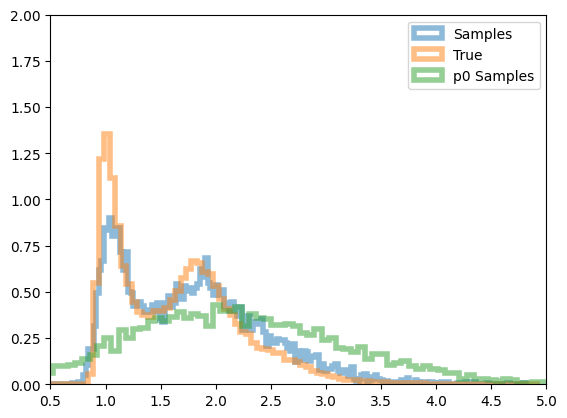

4900 tensor(19.4728, device='cuda:0') tensor(26.5214, device='cuda:0')


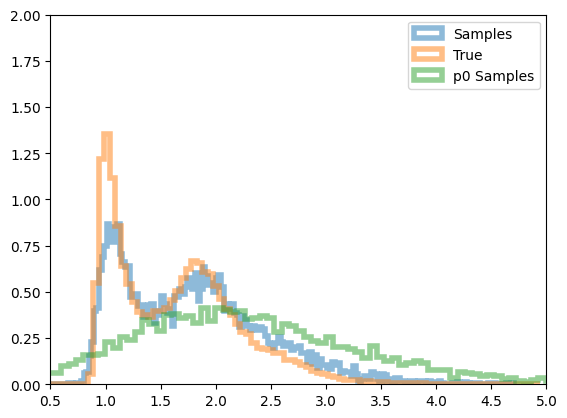

5000 tensor(19.5952, device='cuda:0') tensor(26.3081, device='cuda:0')


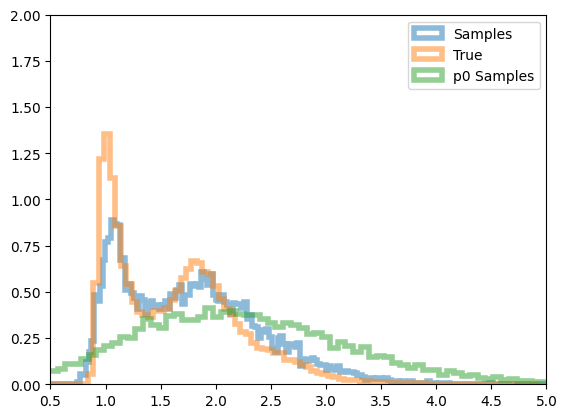

5100 tensor(19.8123, device='cuda:0') tensor(26.4989, device='cuda:0')


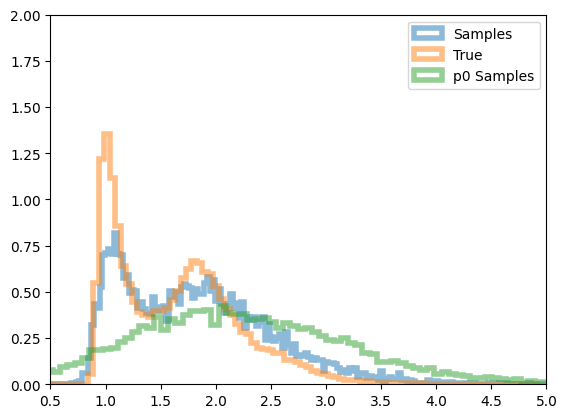

5200 tensor(20.7559, device='cuda:0') tensor(26.9598, device='cuda:0')


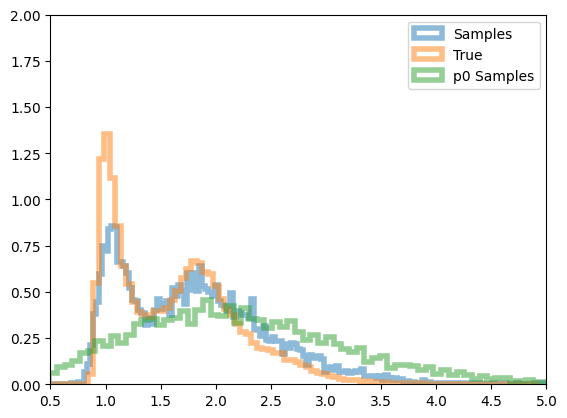

5300 tensor(20.3886, device='cuda:0') tensor(26.8948, device='cuda:0')


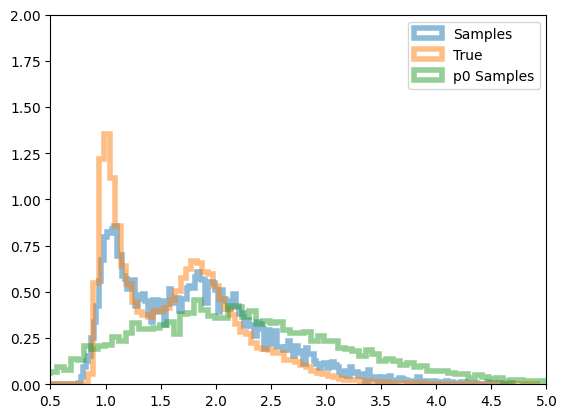

5400 tensor(19.9678, device='cuda:0') tensor(26.6922, device='cuda:0')


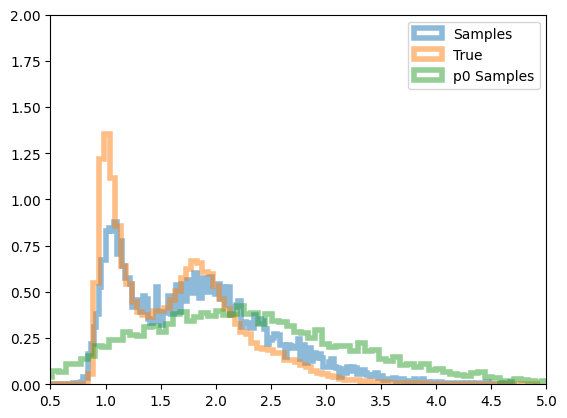

5500 tensor(19.8440, device='cuda:0') tensor(26.6102, device='cuda:0')


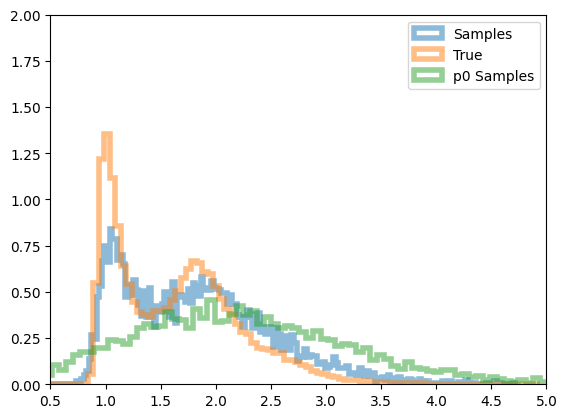

5600 tensor(20.4583, device='cuda:0') tensor(26.8653, device='cuda:0')


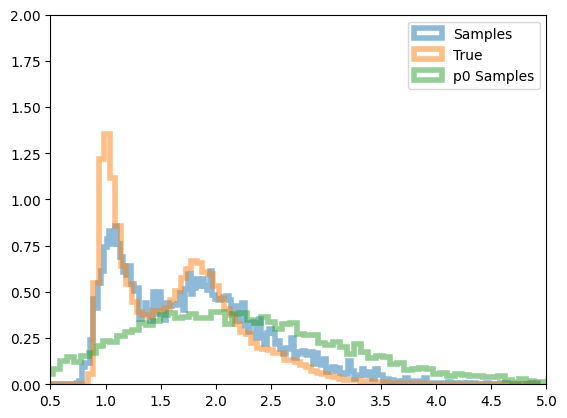

5700 tensor(20.2555, device='cuda:0') tensor(26.7737, device='cuda:0')


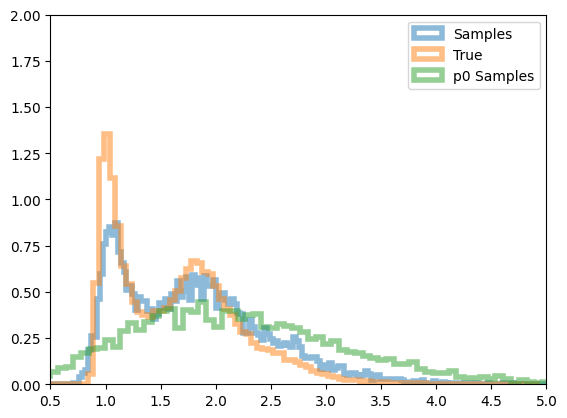

5800 tensor(20.1062, device='cuda:0') tensor(26.8545, device='cuda:0')


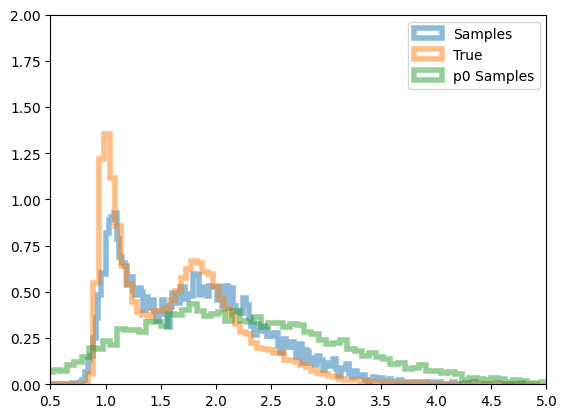

5900 tensor(19.8396, device='cuda:0') tensor(26.8725, device='cuda:0')


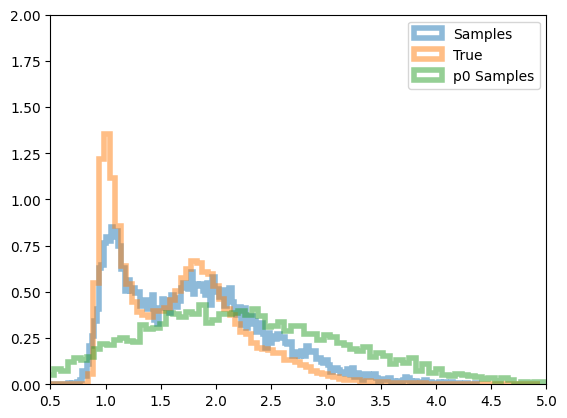

6000 tensor(19.5451, device='cuda:0') tensor(26.6688, device='cuda:0')


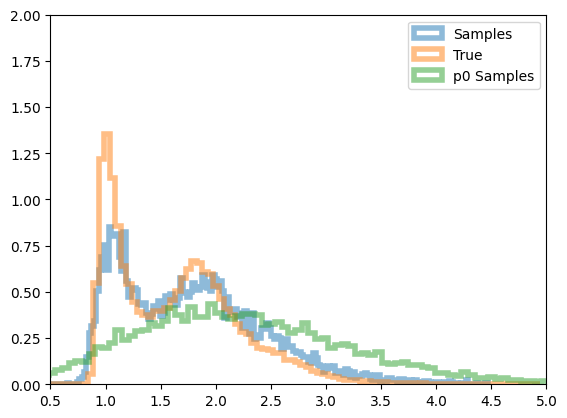

6100 tensor(19.8785, device='cuda:0') tensor(26.6587, device='cuda:0')


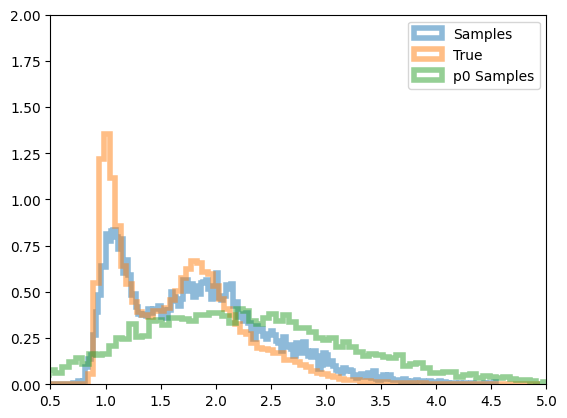

6200 tensor(19.4874, device='cuda:0') tensor(26.6511, device='cuda:0')


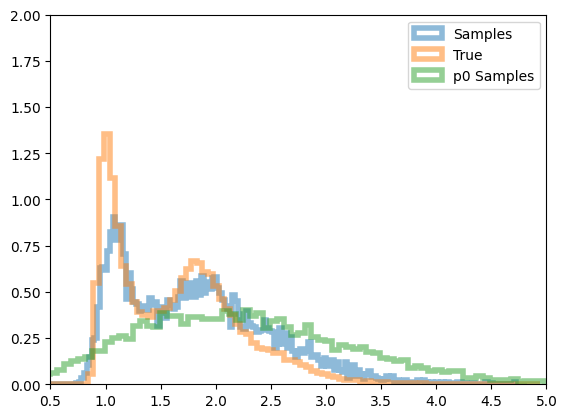

6300 tensor(20.2001, device='cuda:0') tensor(26.7718, device='cuda:0')


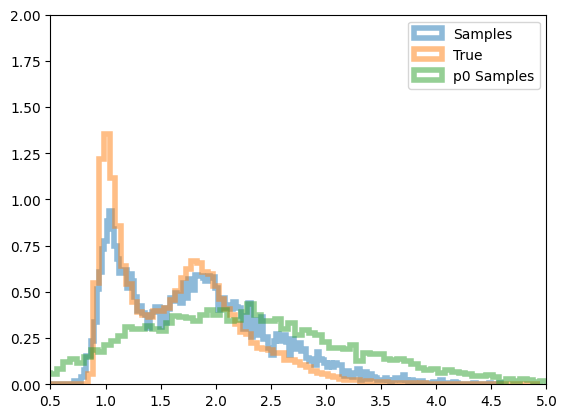

6400 tensor(19.6063, device='cuda:0') tensor(26.5170, device='cuda:0')


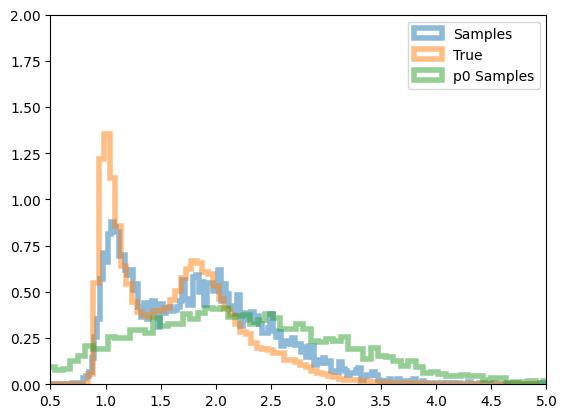

6500 tensor(20.0113, device='cuda:0') tensor(26.8848, device='cuda:0')


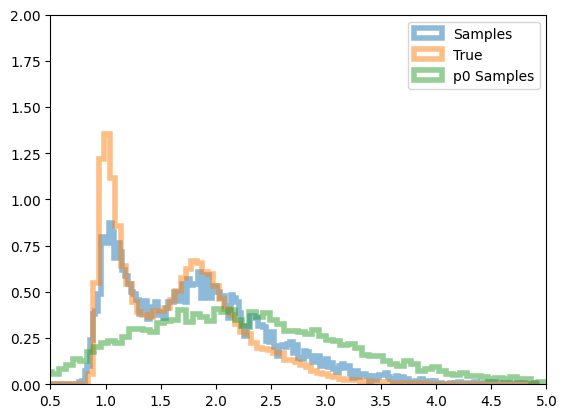

6600 tensor(19.6166, device='cuda:0') tensor(26.5089, device='cuda:0')


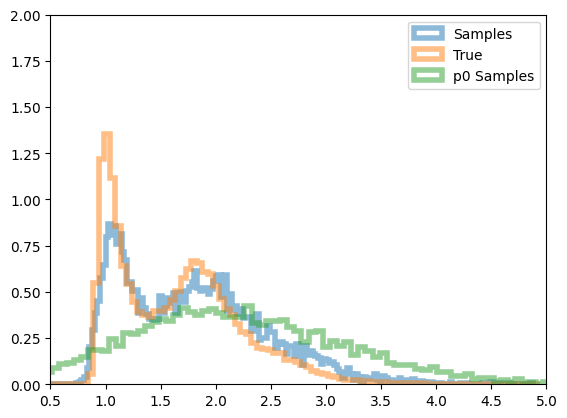

6700 tensor(19.8139, device='cuda:0') tensor(26.6289, device='cuda:0')


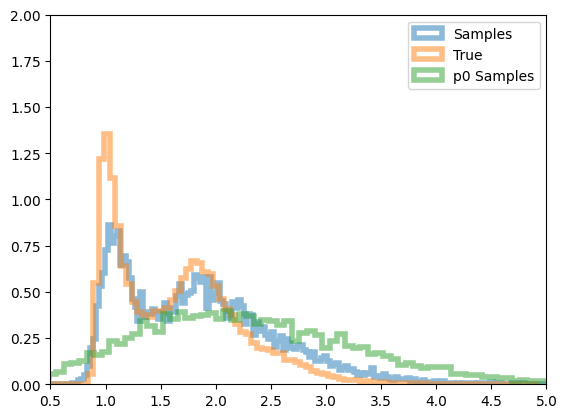

6800 tensor(19.1571, device='cuda:0') tensor(26.5946, device='cuda:0')


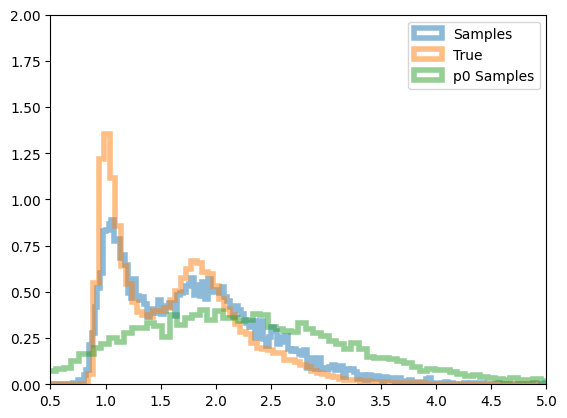

6900 tensor(19.0561, device='cuda:0') tensor(26.3022, device='cuda:0')


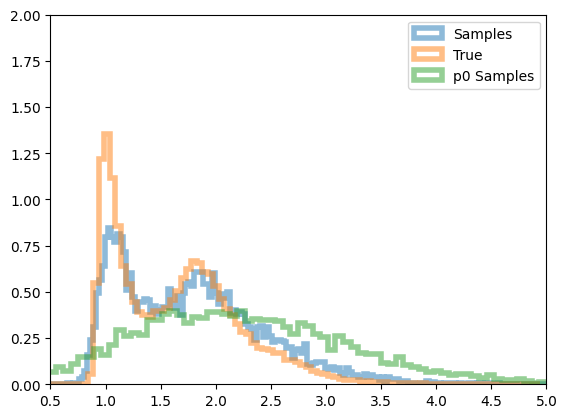

7000 tensor(19.6832, device='cuda:0') tensor(26.6580, device='cuda:0')


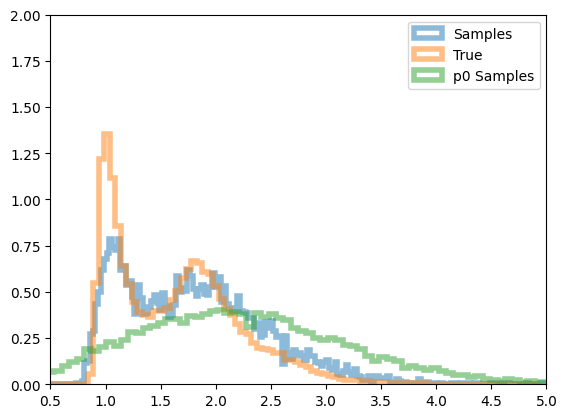

7100 tensor(20.8826, device='cuda:0') tensor(26.8125, device='cuda:0')


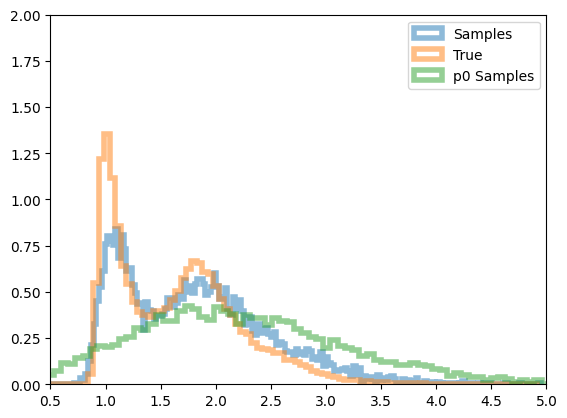

7200 tensor(19.9039, device='cuda:0') tensor(26.5694, device='cuda:0')


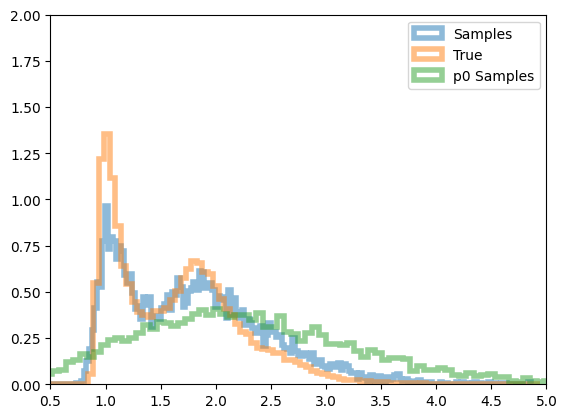

7300 tensor(19.2343, device='cuda:0') tensor(26.4373, device='cuda:0')


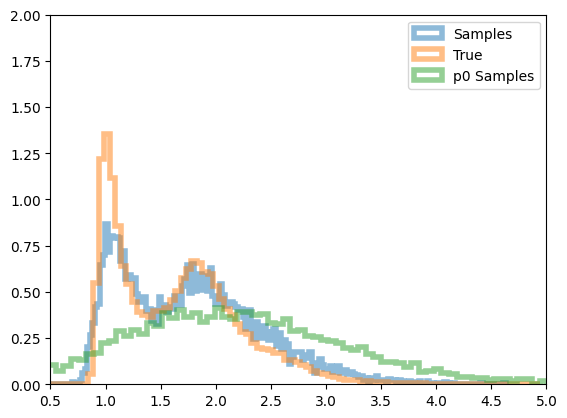

7400 tensor(19.7087, device='cuda:0') tensor(26.5698, device='cuda:0')


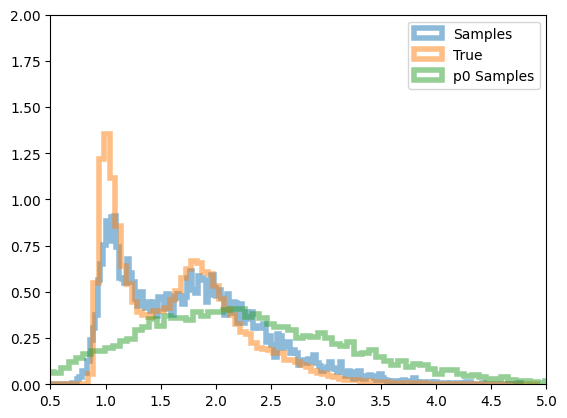

7500 tensor(19.1624, device='cuda:0') tensor(26.4398, device='cuda:0')


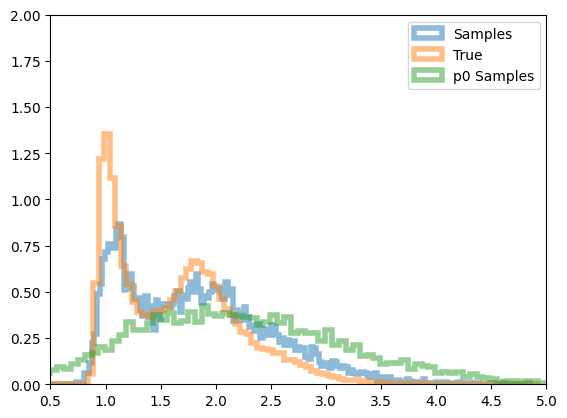

7600 tensor(20.0495, device='cuda:0') tensor(26.8286, device='cuda:0')


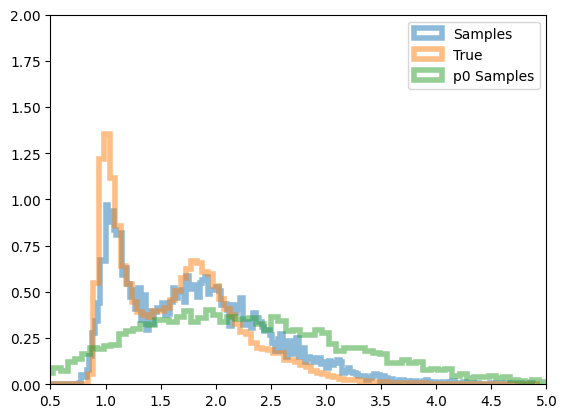

7700 tensor(19.4377, device='cuda:0') tensor(26.5866, device='cuda:0')


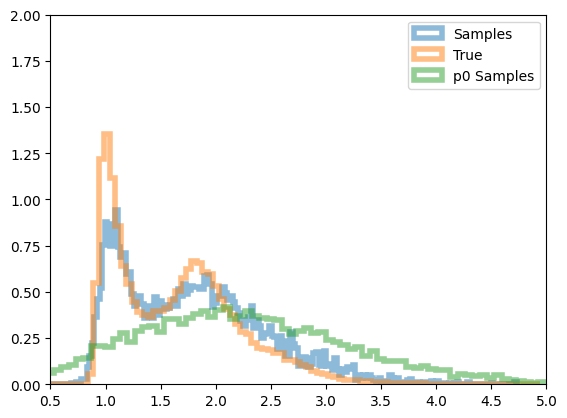

7800 tensor(19.4651, device='cuda:0') tensor(26.5056, device='cuda:0')


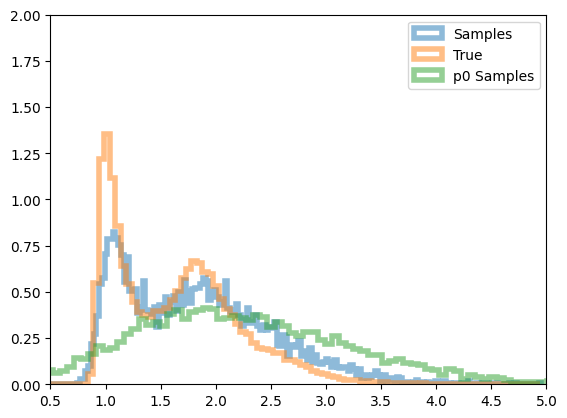

7900 tensor(20.3472, device='cuda:0') tensor(26.8165, device='cuda:0')


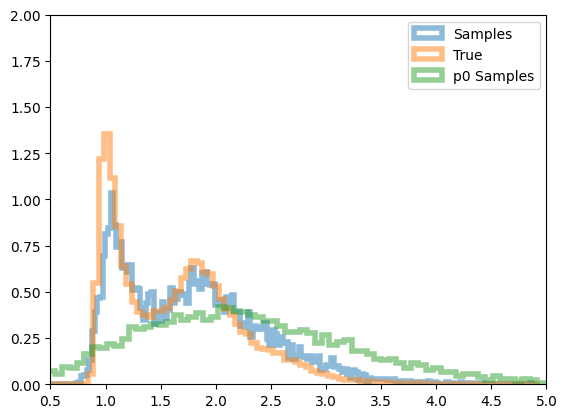

8000 tensor(18.9861, device='cuda:0') tensor(26.2996, device='cuda:0')


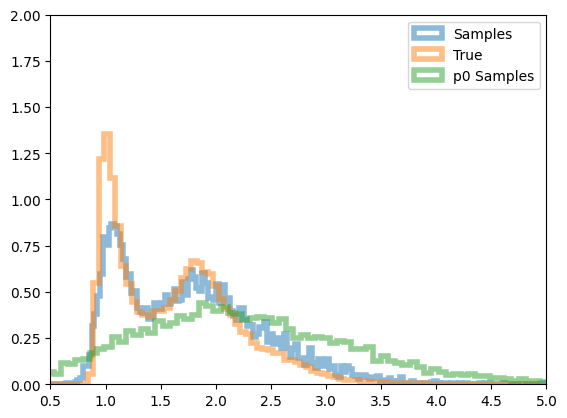

8100 tensor(19.2745, device='cuda:0') tensor(26.5359, device='cuda:0')


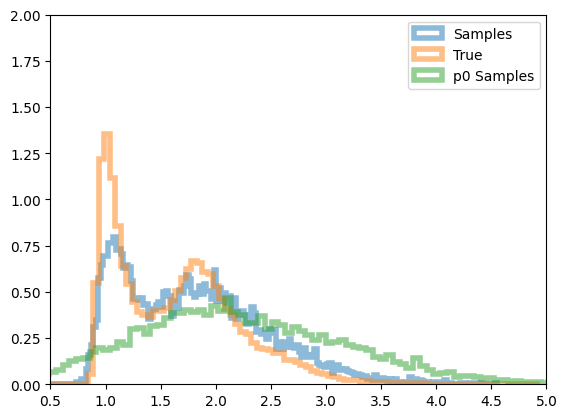

8200 tensor(19.8873, device='cuda:0') tensor(26.6340, device='cuda:0')


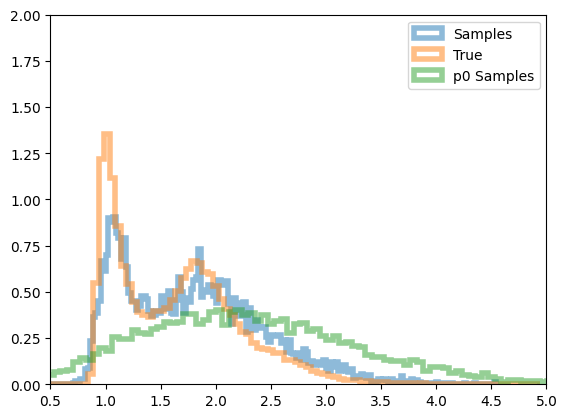

8300 tensor(19.2892, device='cuda:0') tensor(26.4623, device='cuda:0')


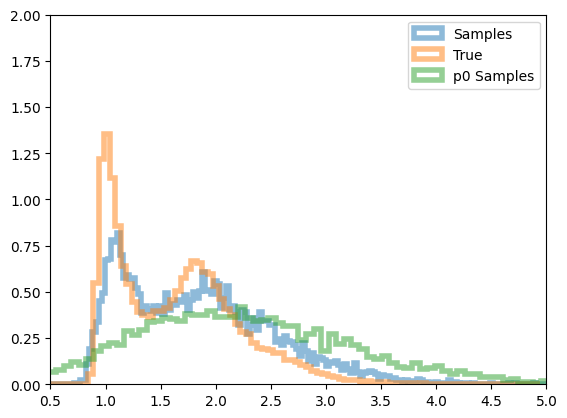

8400 tensor(20.7626, device='cuda:0') tensor(27.0331, device='cuda:0')


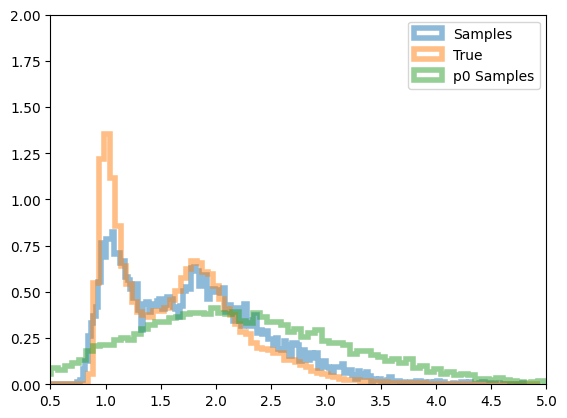

8500 tensor(20.4979, device='cuda:0') tensor(26.7766, device='cuda:0')


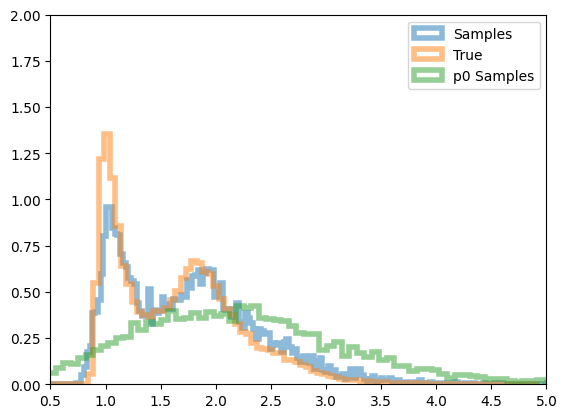

8600 tensor(19.4736, device='cuda:0') tensor(26.4147, device='cuda:0')


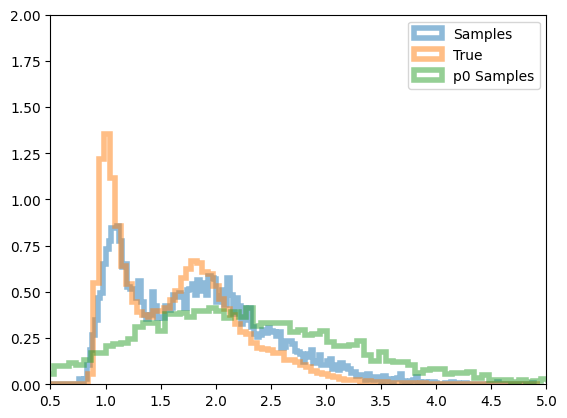

8700 tensor(19.8221, device='cuda:0') tensor(26.5338, device='cuda:0')


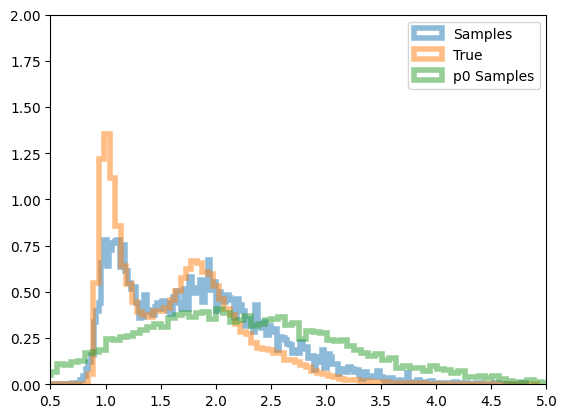

8800 tensor(20.4263, device='cuda:0') tensor(26.8507, device='cuda:0')


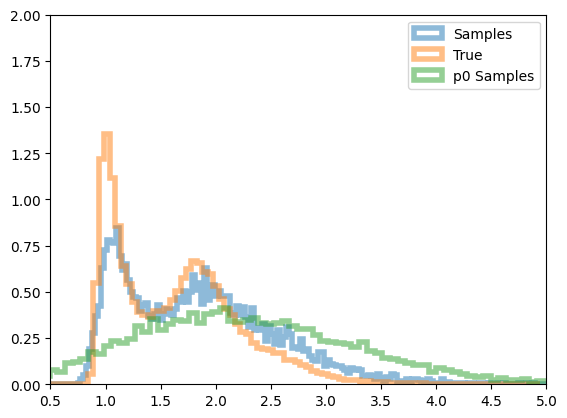

8900 tensor(19.7096, device='cuda:0') tensor(26.6959, device='cuda:0')


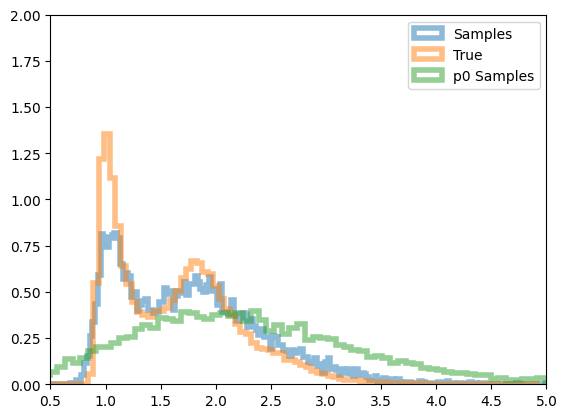

9000 tensor(19.4328, device='cuda:0') tensor(26.4856, device='cuda:0')


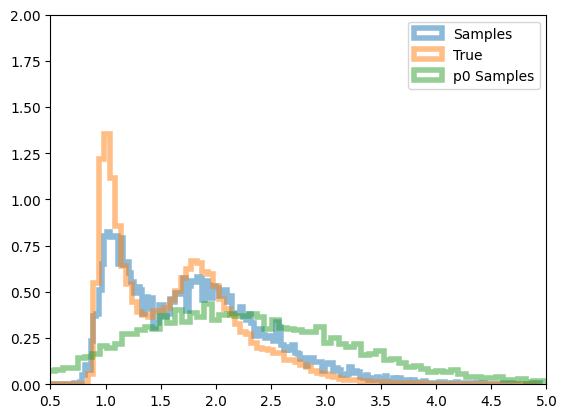

9100 tensor(19.2928, device='cuda:0') tensor(26.4457, device='cuda:0')


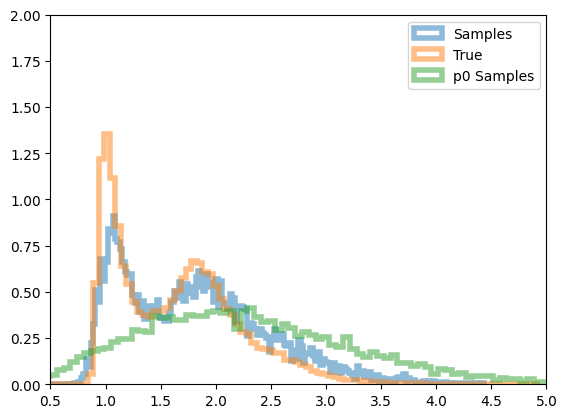

9200 tensor(20.0955, device='cuda:0') tensor(26.5314, device='cuda:0')


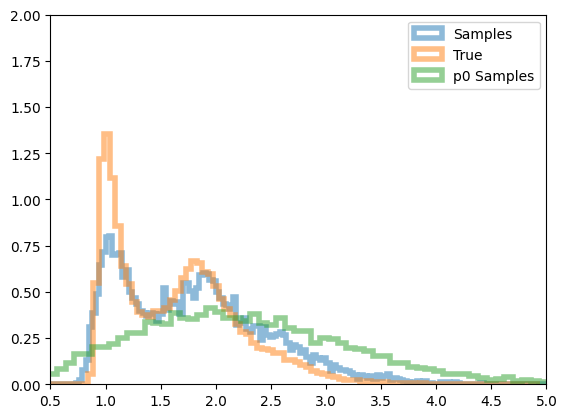

9300 tensor(20.6624, device='cuda:0') tensor(26.9949, device='cuda:0')


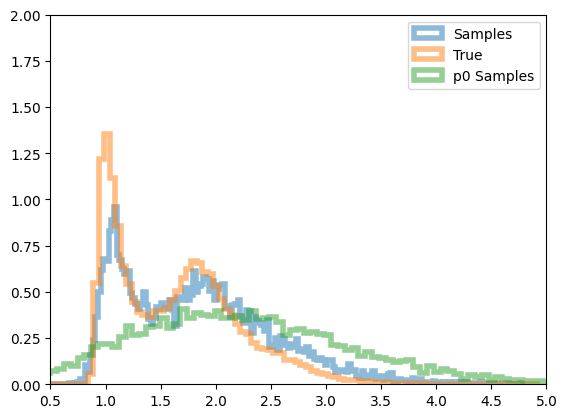

9400 tensor(20.3601, device='cuda:0') tensor(26.8501, device='cuda:0')


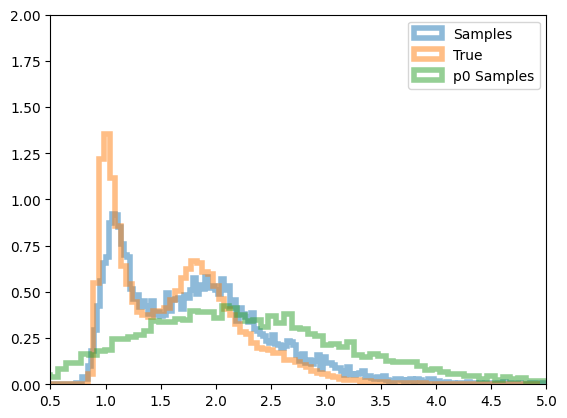

9500 tensor(19.1193, device='cuda:0') tensor(26.5848, device='cuda:0')


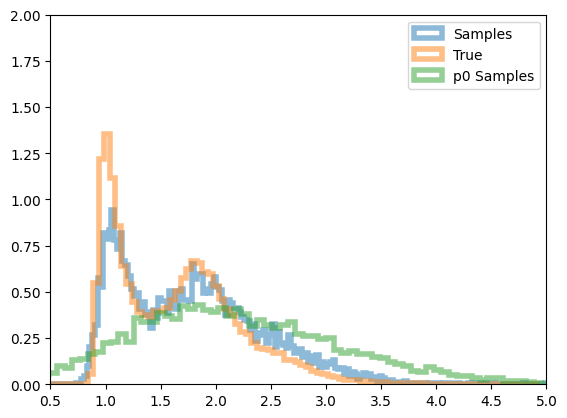

9600 tensor(19.7515, device='cuda:0') tensor(26.6286, device='cuda:0')


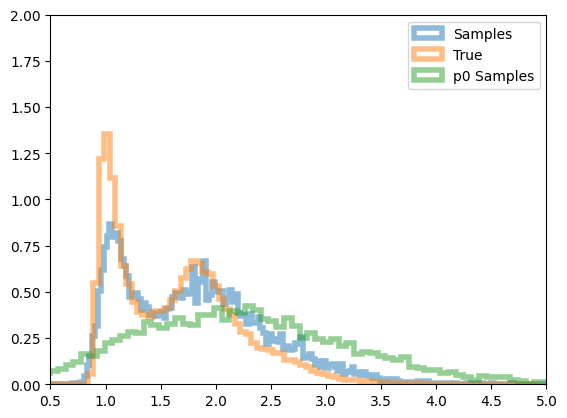

9700 tensor(19.9437, device='cuda:0') tensor(26.5679, device='cuda:0')


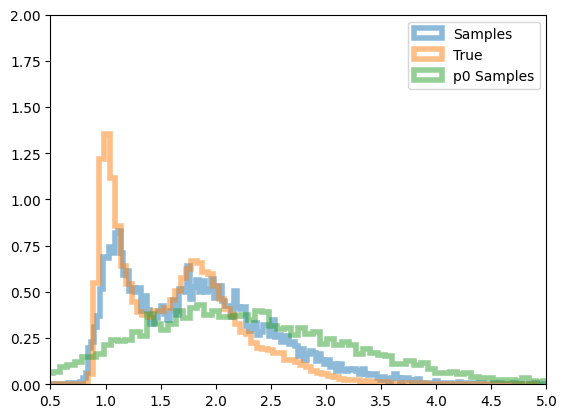

9800 tensor(20.2515, device='cuda:0') tensor(26.8831, device='cuda:0')


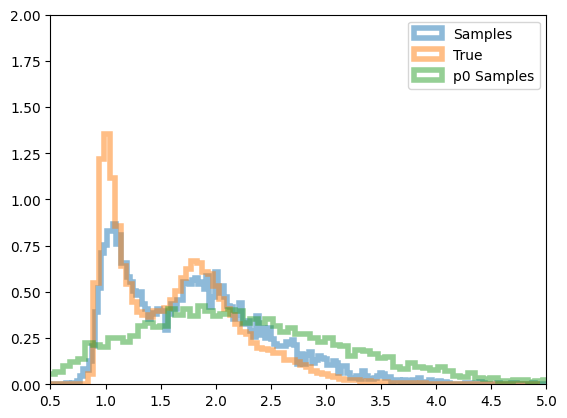

9900 tensor(19.5274, device='cuda:0') tensor(26.6534, device='cuda:0')


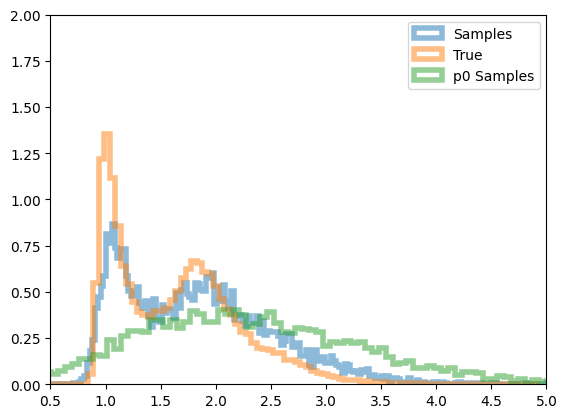

10000 tensor(20.1348, device='cuda:0') tensor(26.7018, device='cuda:0')


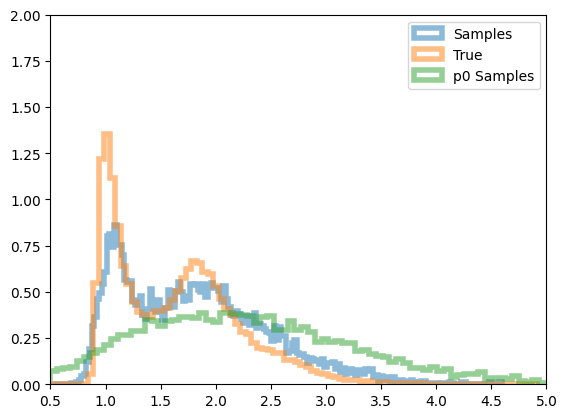

10100 tensor(20.0066, device='cuda:0') tensor(26.6197, device='cuda:0')


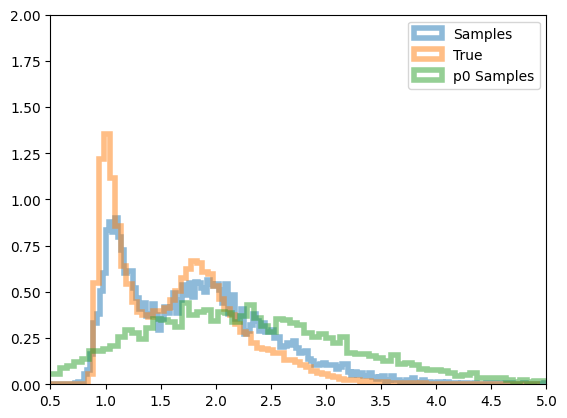

10200 tensor(19.4373, device='cuda:0') tensor(26.5452, device='cuda:0')


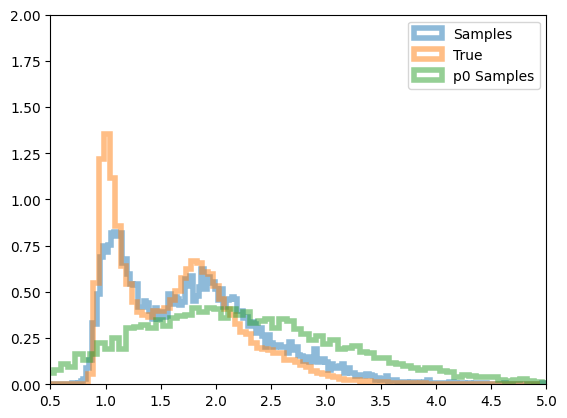

10300 tensor(19.3157, device='cuda:0') tensor(26.5443, device='cuda:0')


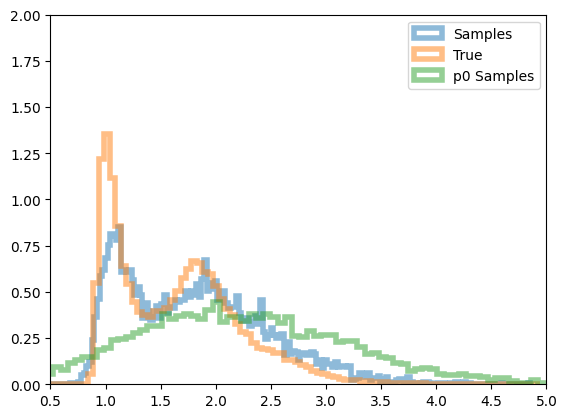

10400 tensor(20.2963, device='cuda:0') tensor(26.7854, device='cuda:0')


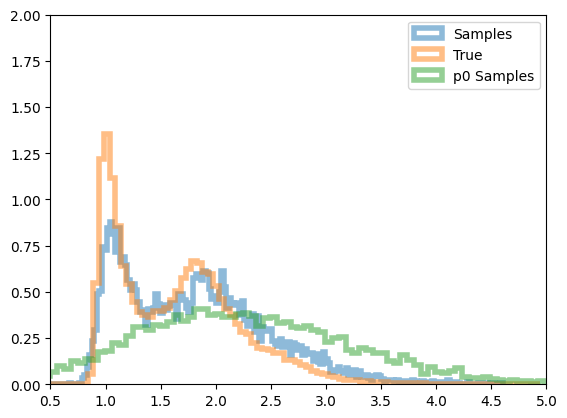

10500 tensor(19.5772, device='cuda:0') tensor(26.5793, device='cuda:0')


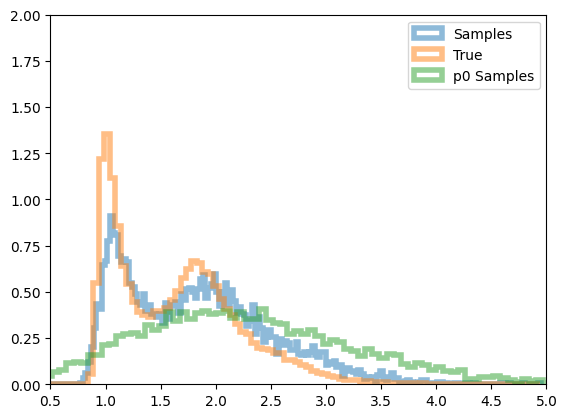

10600 tensor(19.7166, device='cuda:0') tensor(26.6998, device='cuda:0')


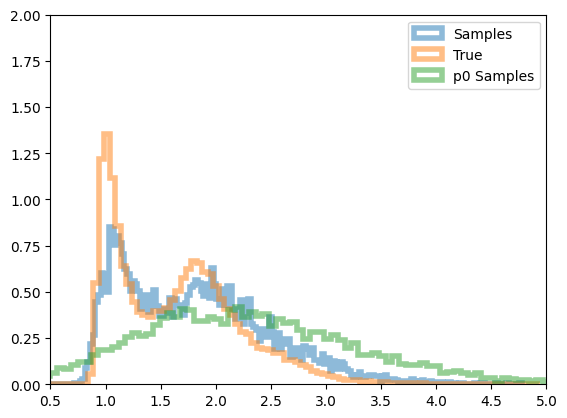

10700 tensor(20.2092, device='cuda:0') tensor(26.8289, device='cuda:0')


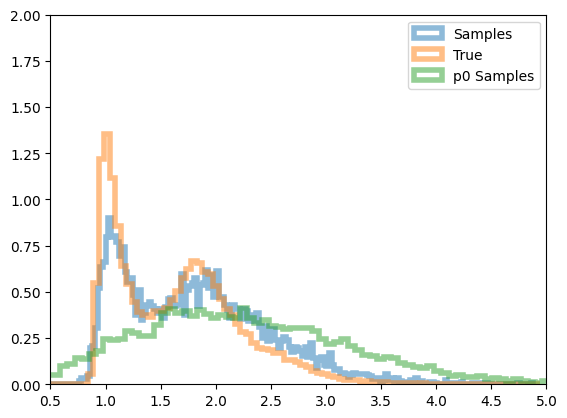

10800 tensor(19.7303, device='cuda:0') tensor(26.6253, device='cuda:0')


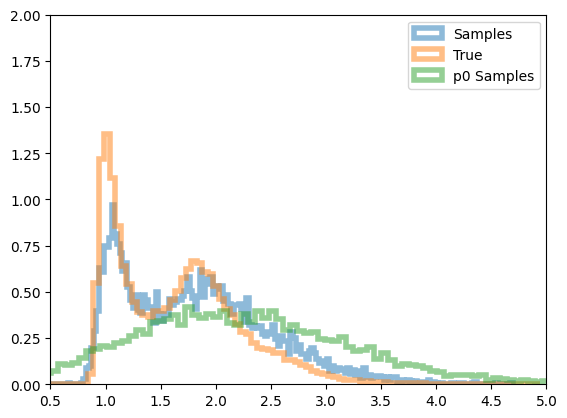

10900 tensor(19.9977, device='cuda:0') tensor(26.7100, device='cuda:0')


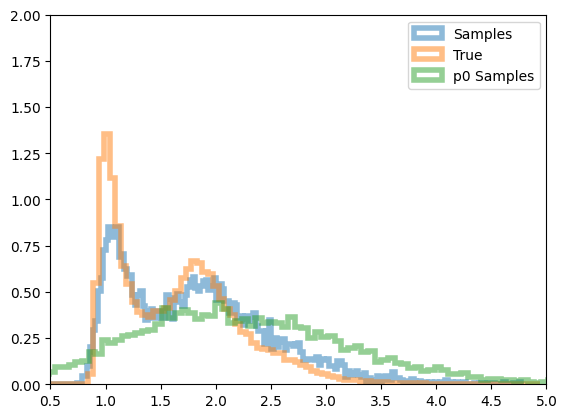

11000 tensor(19.8429, device='cuda:0') tensor(26.7838, device='cuda:0')


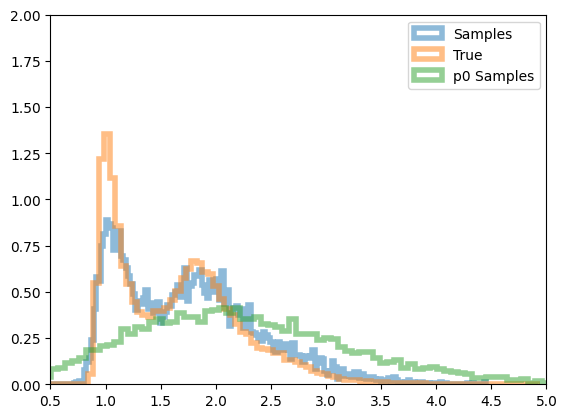

11100 tensor(18.8838, device='cuda:0') tensor(26.3660, device='cuda:0')


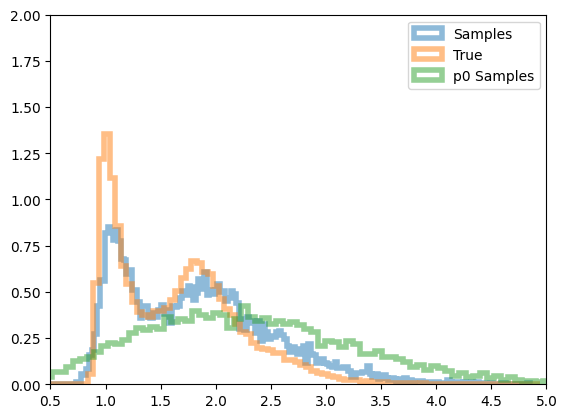

11200 tensor(19.6546, device='cuda:0') tensor(26.6500, device='cuda:0')


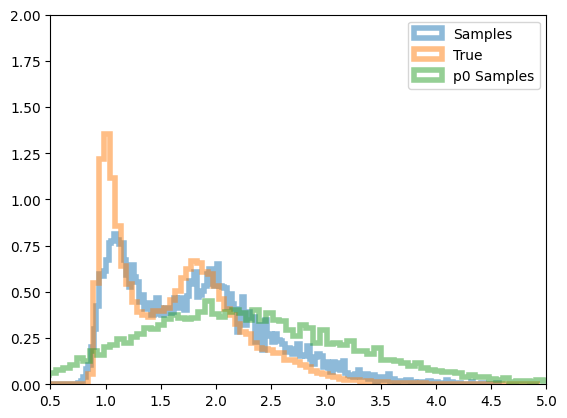

11300 tensor(19.7324, device='cuda:0') tensor(26.5576, device='cuda:0')


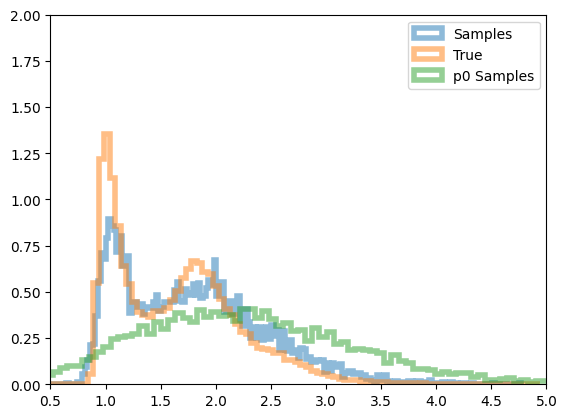

11400 tensor(19.1845, device='cuda:0') tensor(26.6274, device='cuda:0')


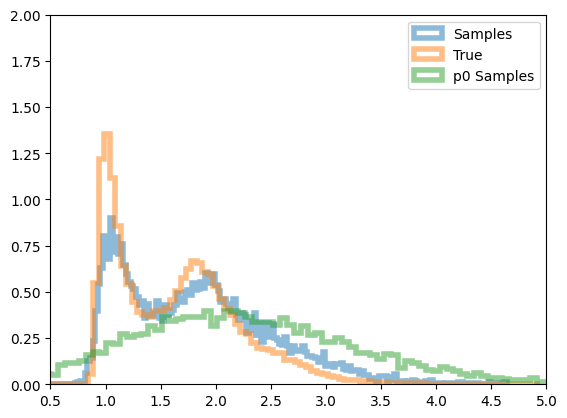

11500 tensor(19.3227, device='cuda:0') tensor(26.5501, device='cuda:0')


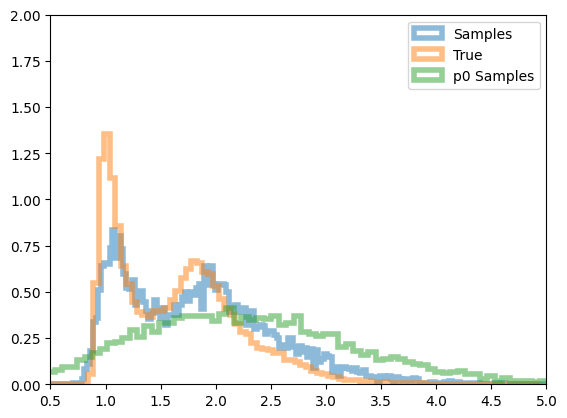

11600 tensor(20.0374, device='cuda:0') tensor(26.7856, device='cuda:0')


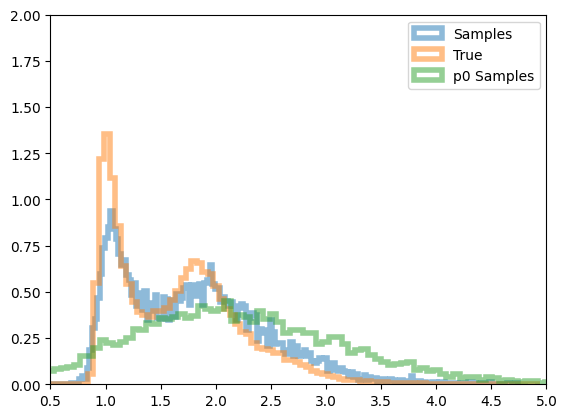

11700 tensor(19.6325, device='cuda:0') tensor(26.5346, device='cuda:0')


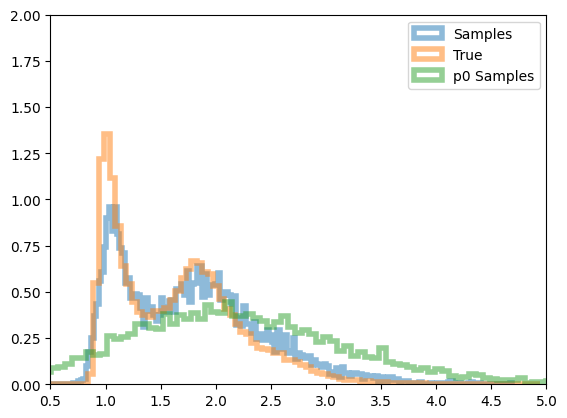

11800 tensor(18.9397, device='cuda:0') tensor(26.4128, device='cuda:0')


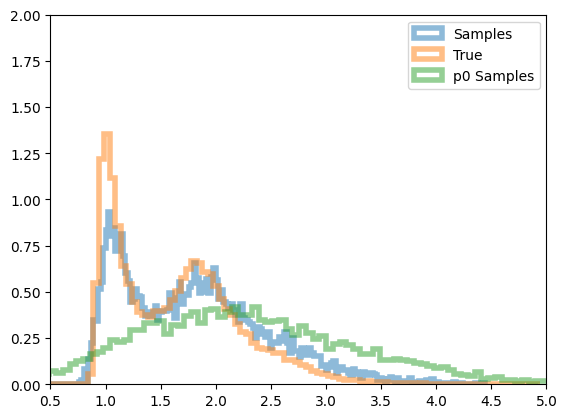

11900 tensor(19.1120, device='cuda:0') tensor(26.4921, device='cuda:0')


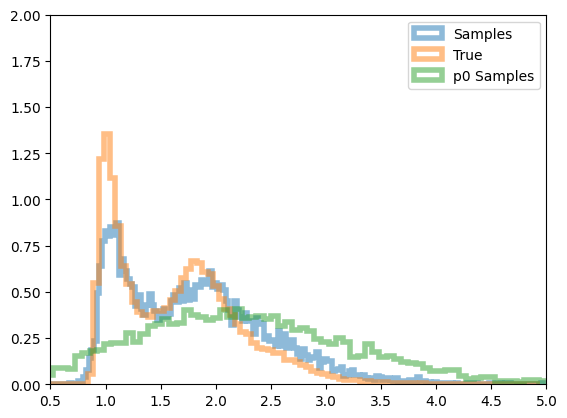

12000 tensor(19.2295, device='cuda:0') tensor(26.3747, device='cuda:0')


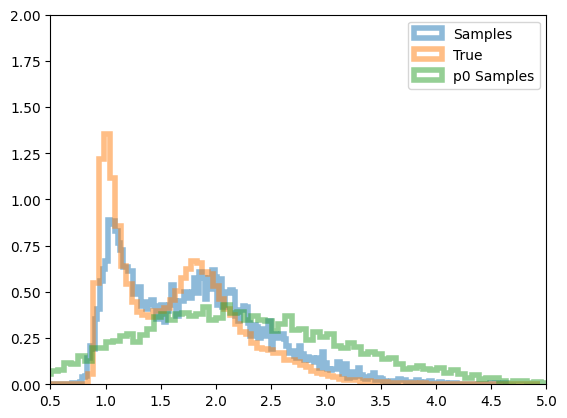

12100 tensor(19.6033, device='cuda:0') tensor(26.7102, device='cuda:0')


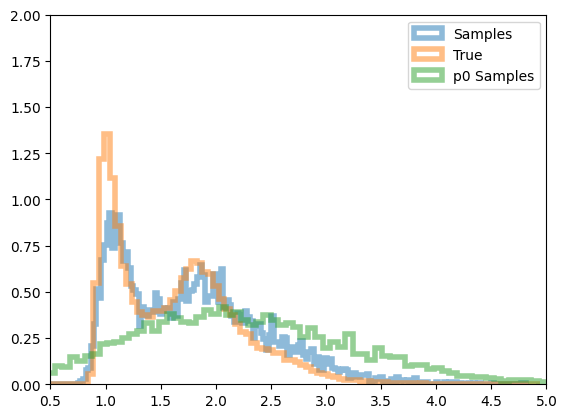

12200 tensor(18.9958, device='cuda:0') tensor(26.4343, device='cuda:0')


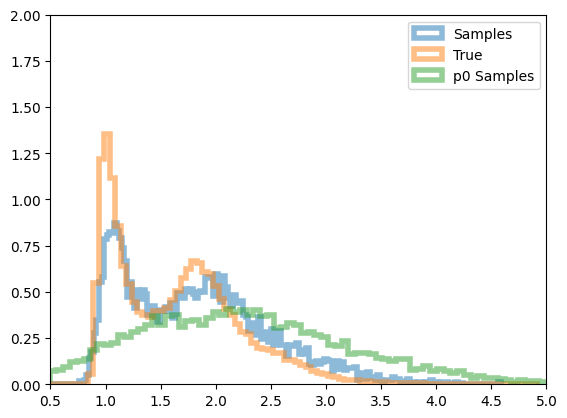

12300 tensor(19.5193, device='cuda:0') tensor(26.6016, device='cuda:0')


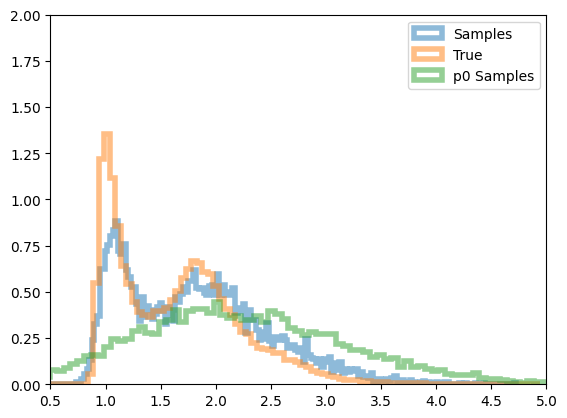

12400 tensor(20.2207, device='cuda:0') tensor(26.7605, device='cuda:0')


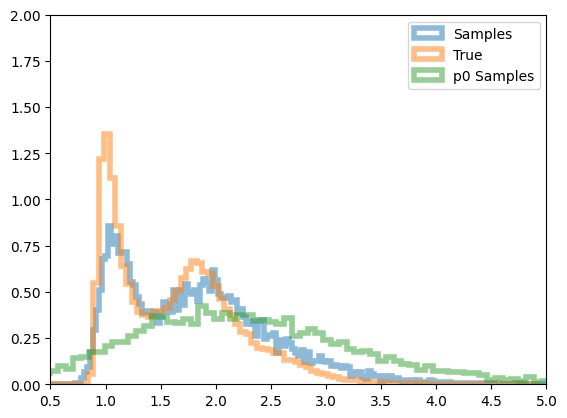

12500 tensor(19.9652, device='cuda:0') tensor(26.7207, device='cuda:0')


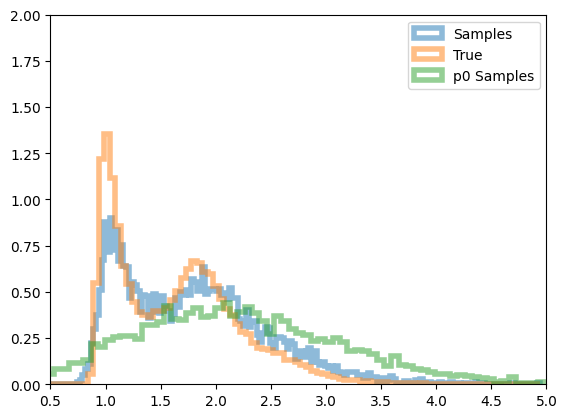

12600 tensor(20.4412, device='cuda:0') tensor(26.7813, device='cuda:0')


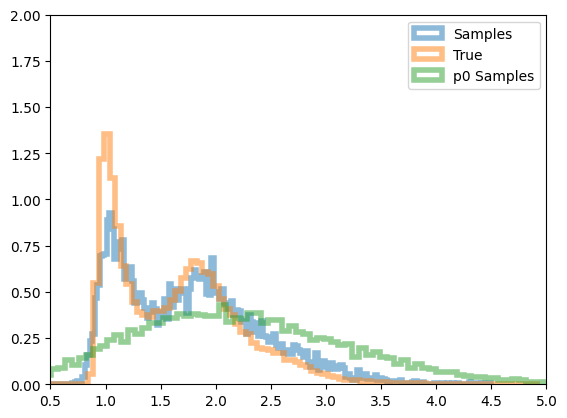

12700 tensor(19.4746, device='cuda:0') tensor(26.6598, device='cuda:0')


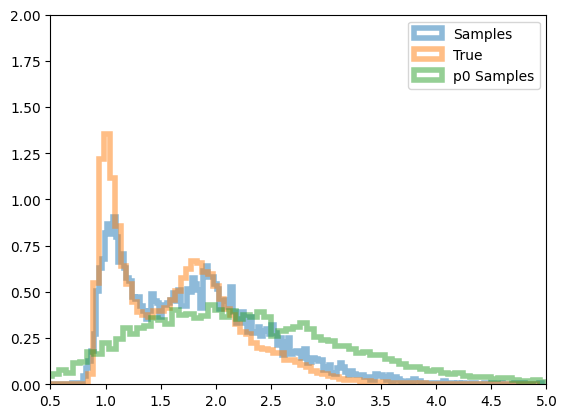

12800 tensor(19.4398, device='cuda:0') tensor(26.7185, device='cuda:0')


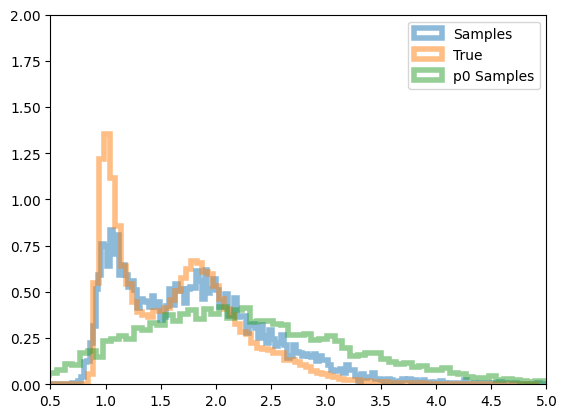

12900 tensor(20.2875, device='cuda:0') tensor(26.9705, device='cuda:0')


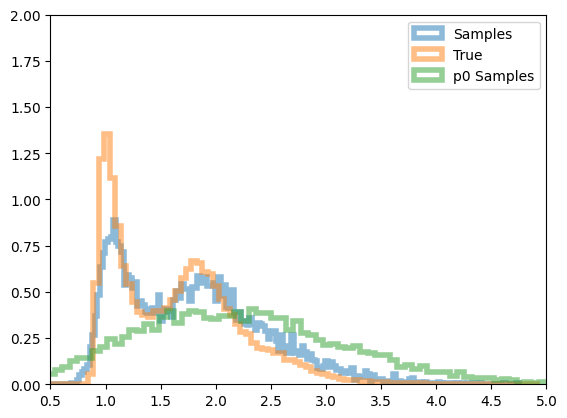

13000 tensor(20.0950, device='cuda:0') tensor(26.9172, device='cuda:0')


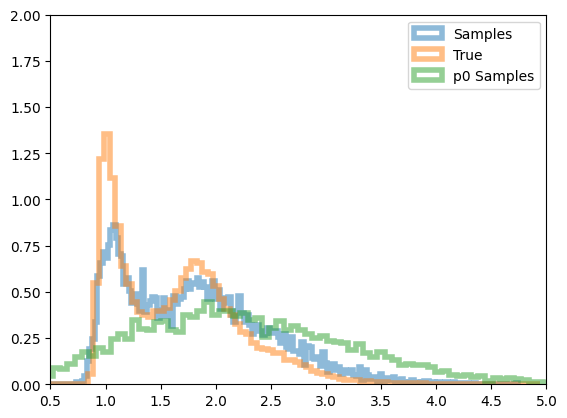

13100 tensor(19.6410, device='cuda:0') tensor(26.7165, device='cuda:0')


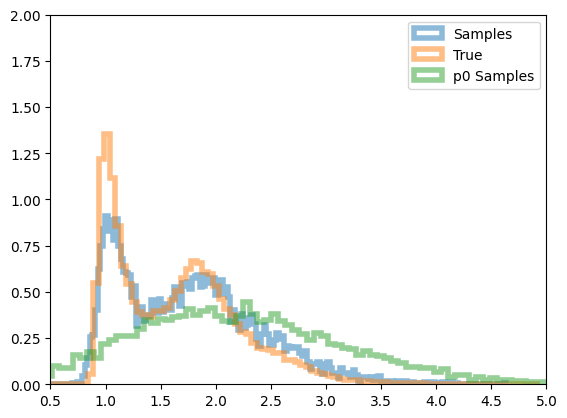

13200 tensor(19.2229, device='cuda:0') tensor(26.4398, device='cuda:0')


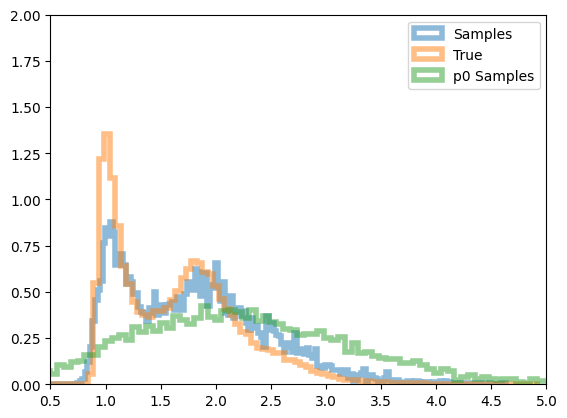

13300 tensor(19.9688, device='cuda:0') tensor(26.5330, device='cuda:0')


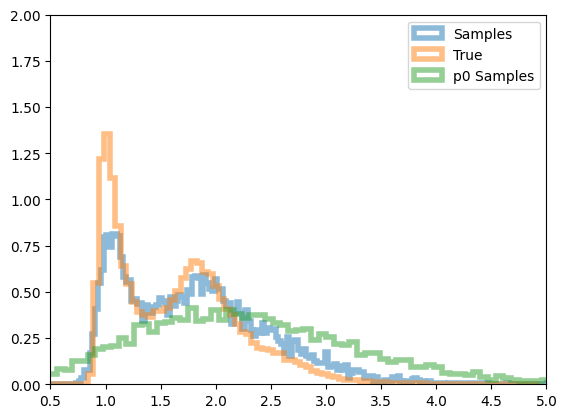

13400 tensor(19.9926, device='cuda:0') tensor(26.5320, device='cuda:0')


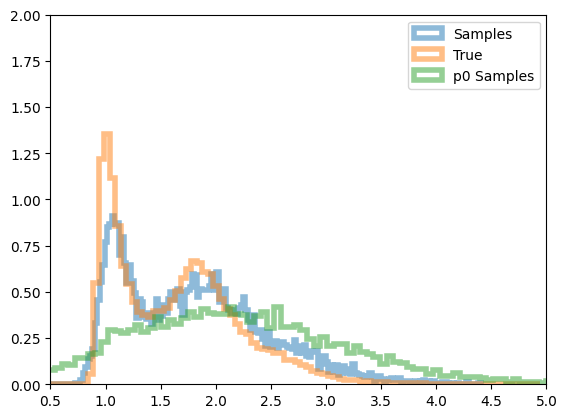

13500 tensor(19.8150, device='cuda:0') tensor(26.7249, device='cuda:0')


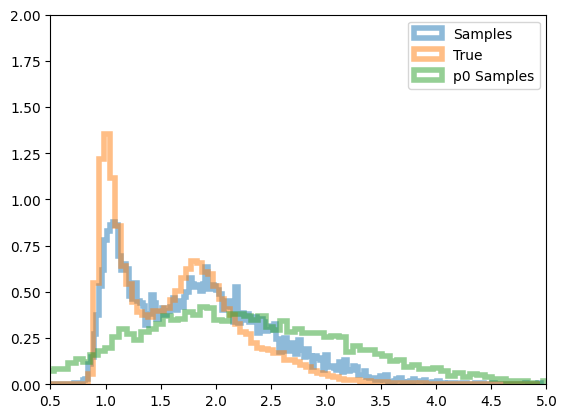

13600 tensor(19.6603, device='cuda:0') tensor(26.7196, device='cuda:0')


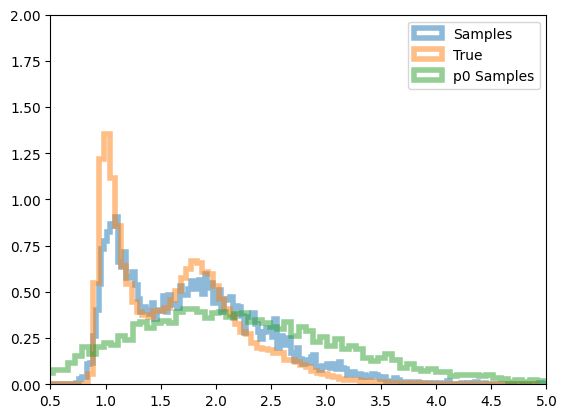

13700 tensor(19.2805, device='cuda:0') tensor(26.4513, device='cuda:0')


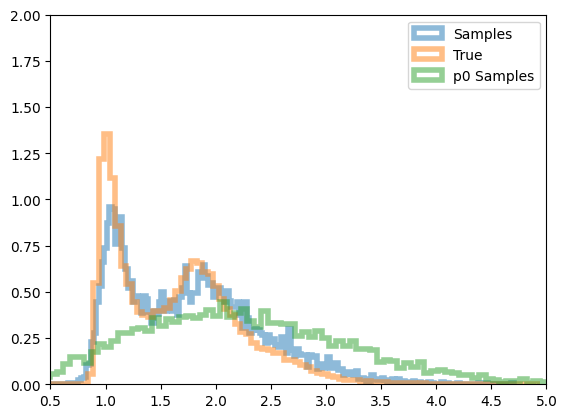

13800 tensor(19.3929, device='cuda:0') tensor(26.4632, device='cuda:0')


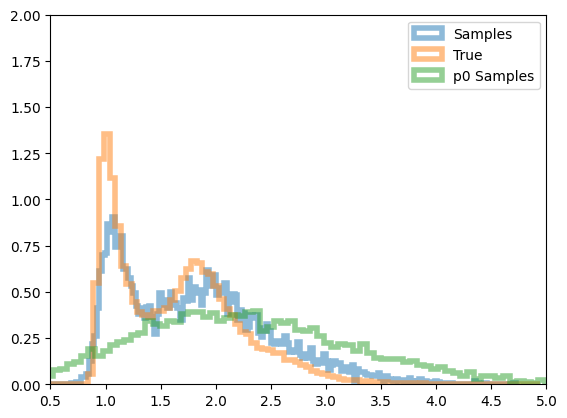

13900 tensor(19.5784, device='cuda:0') tensor(26.6642, device='cuda:0')


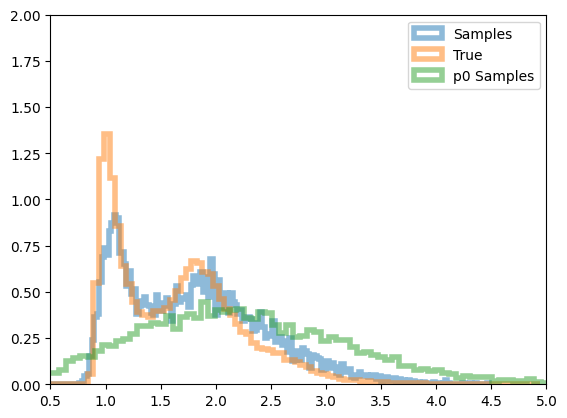

14000 tensor(19.0865, device='cuda:0') tensor(26.4716, device='cuda:0')


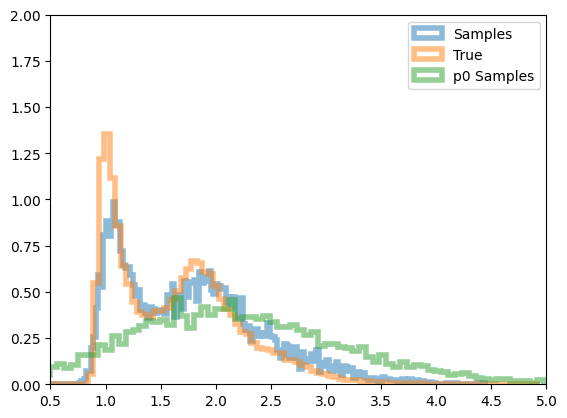

14100 tensor(18.8460, device='cuda:0') tensor(26.4699, device='cuda:0')


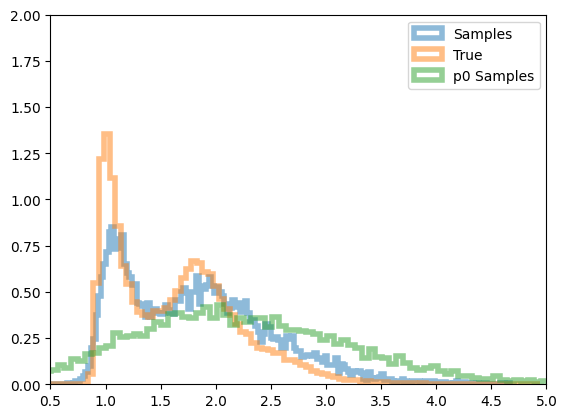

14200 tensor(20.2517, device='cuda:0') tensor(26.8349, device='cuda:0')


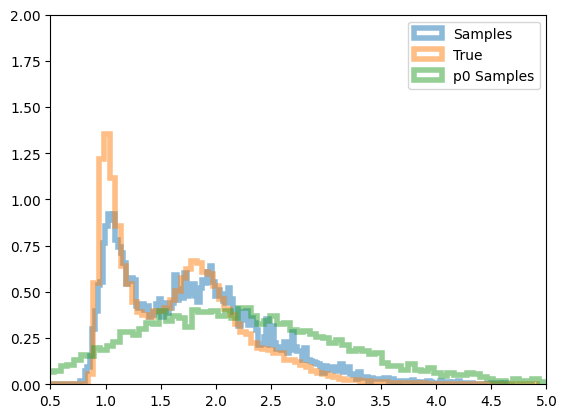

14300 tensor(19.0851, device='cuda:0') tensor(26.5292, device='cuda:0')


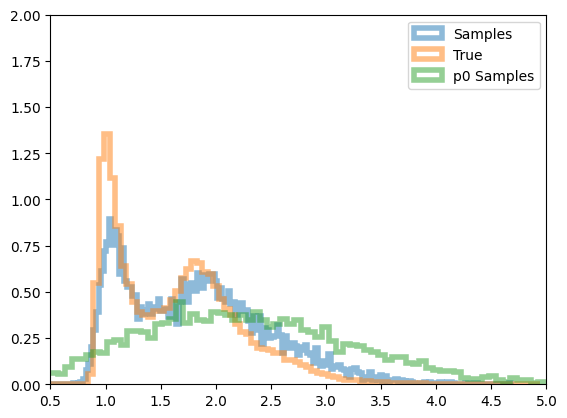

14400 tensor(19.7610, device='cuda:0') tensor(26.5921, device='cuda:0')


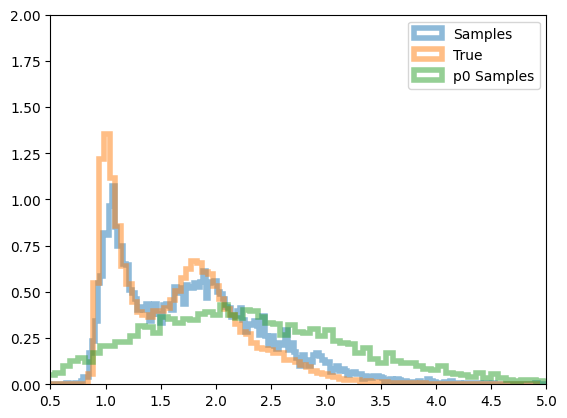

14500 tensor(18.1694, device='cuda:0') tensor(26.4169, device='cuda:0')


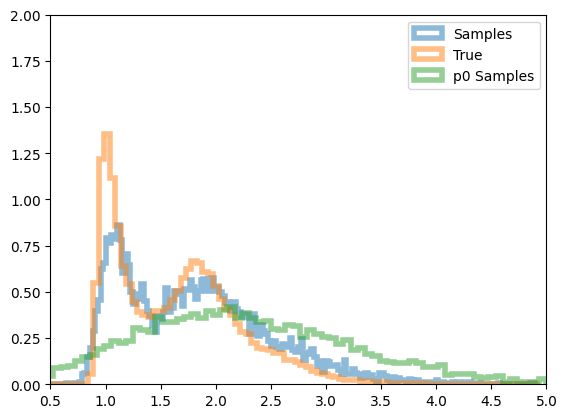

14600 tensor(19.3597, device='cuda:0') tensor(26.5892, device='cuda:0')


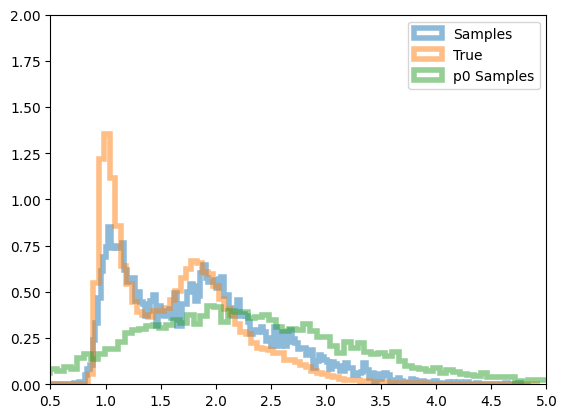

14700 tensor(19.7818, device='cuda:0') tensor(26.6780, device='cuda:0')


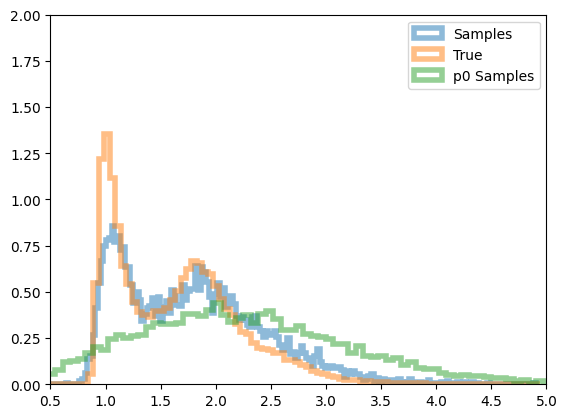

14800 tensor(19.0833, device='cuda:0') tensor(26.3693, device='cuda:0')


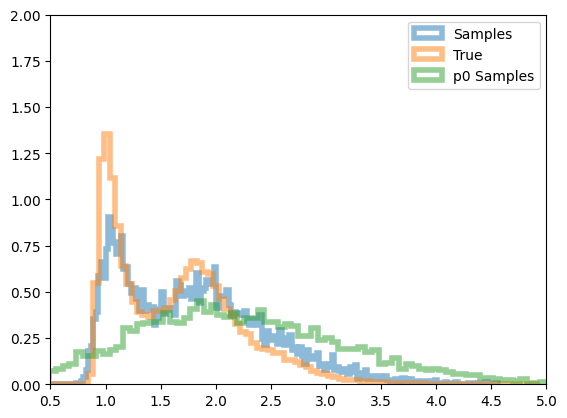

14900 tensor(19.7318, device='cuda:0') tensor(26.7410, device='cuda:0')


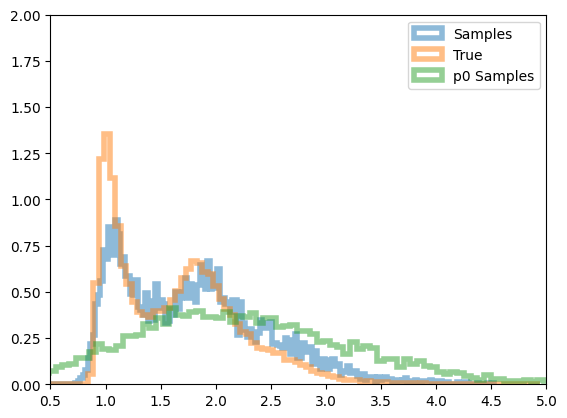

15000 tensor(19.9555, device='cuda:0') tensor(26.7498, device='cuda:0')


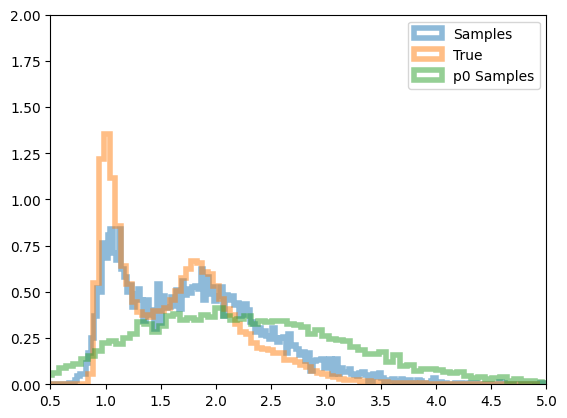

15100 tensor(20.5843, device='cuda:0') tensor(27.1326, device='cuda:0')


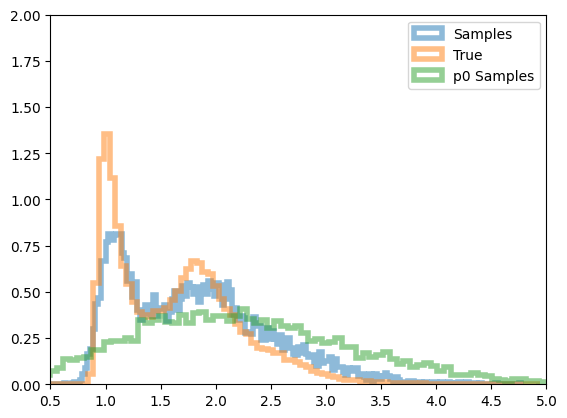

15200 tensor(19.6995, device='cuda:0') tensor(26.6447, device='cuda:0')


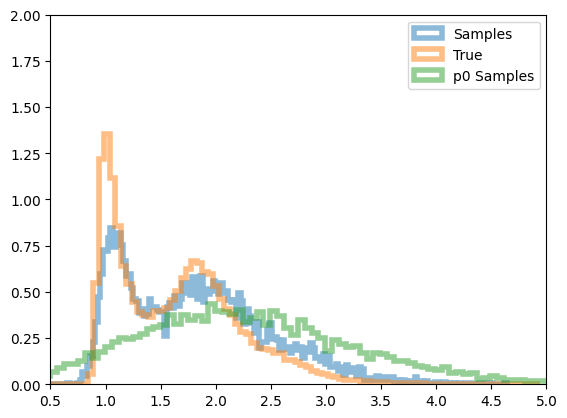

15300 tensor(19.2954, device='cuda:0') tensor(26.5919, device='cuda:0')


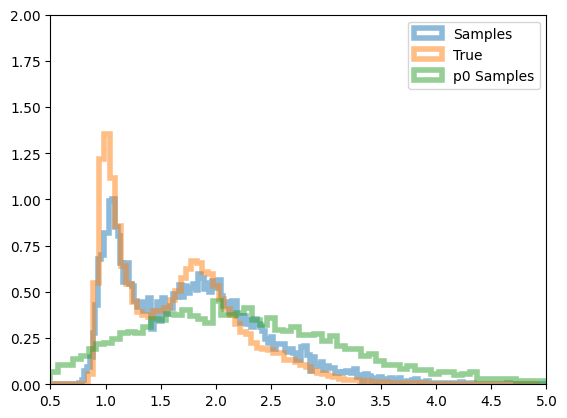

15400 tensor(18.7559, device='cuda:0') tensor(26.2550, device='cuda:0')


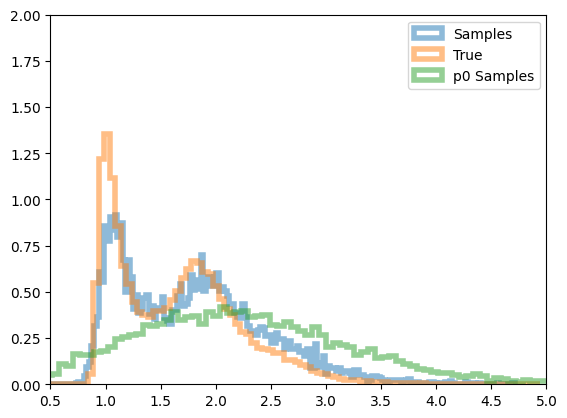

15500 tensor(19.7033, device='cuda:0') tensor(26.5232, device='cuda:0')


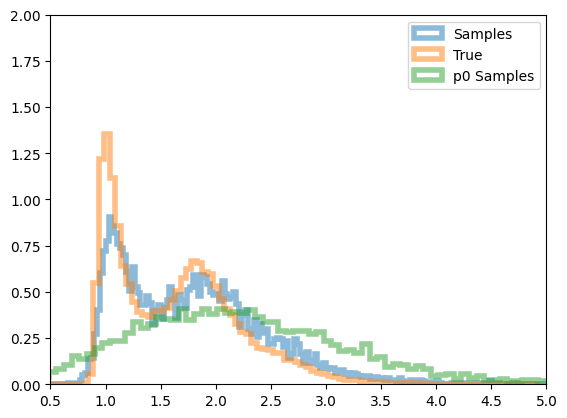

15600 tensor(20.1372, device='cuda:0') tensor(26.7755, device='cuda:0')


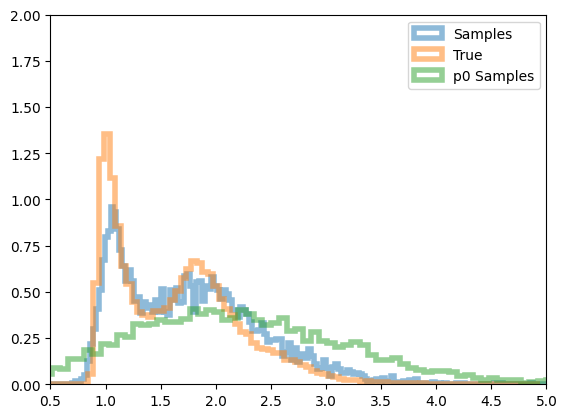

15700 tensor(18.6059, device='cuda:0') tensor(26.4772, device='cuda:0')


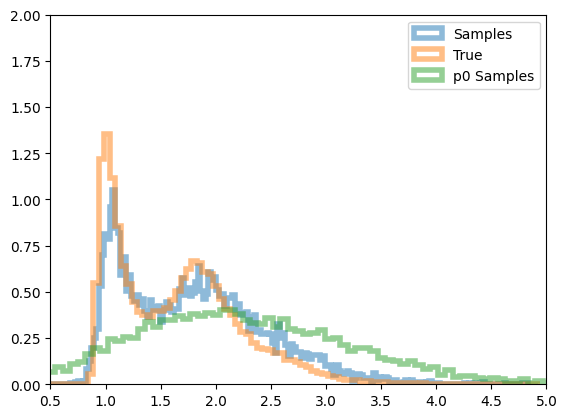

15800 tensor(19.0761, device='cuda:0') tensor(26.5420, device='cuda:0')


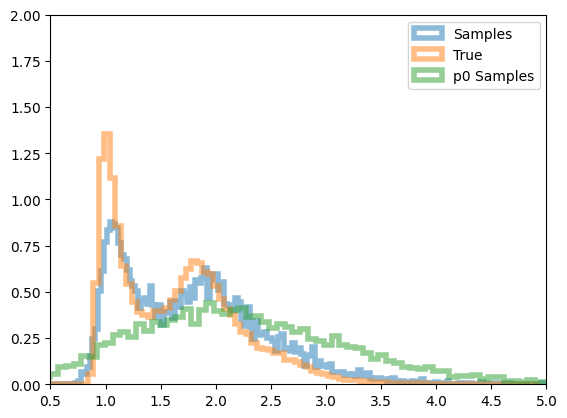

15900 tensor(19.5360, device='cuda:0') tensor(26.6195, device='cuda:0')


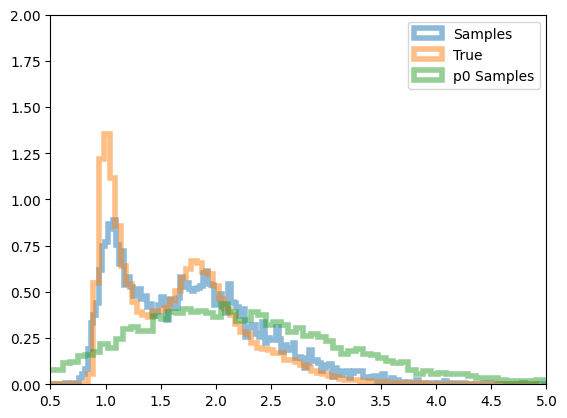

16000 tensor(19.8264, device='cuda:0') tensor(26.6840, device='cuda:0')


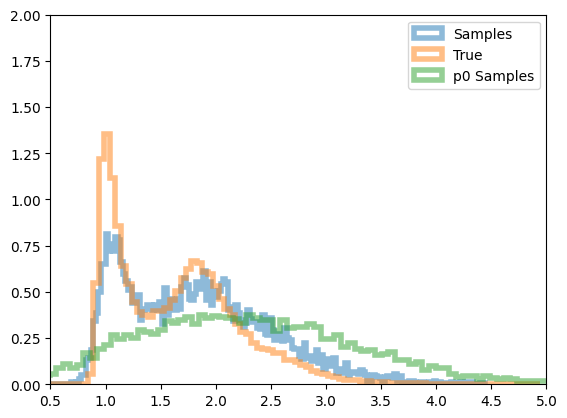

16100 tensor(19.9287, device='cuda:0') tensor(26.6765, device='cuda:0')


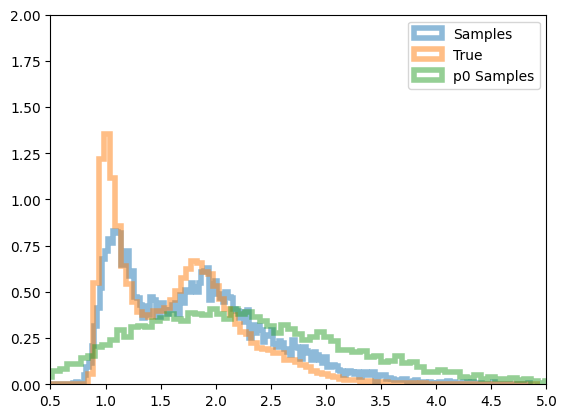

16200 tensor(19.8267, device='cuda:0') tensor(26.7478, device='cuda:0')


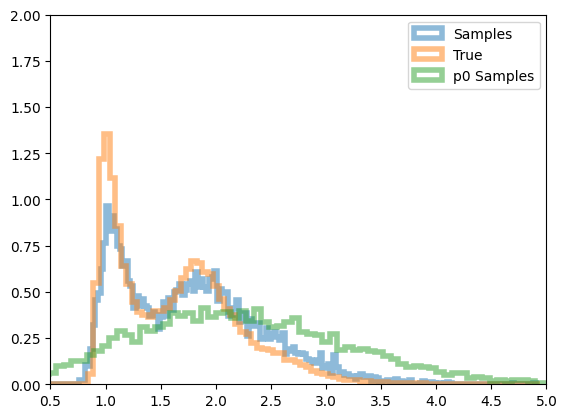

16300 tensor(19.3643, device='cuda:0') tensor(26.6030, device='cuda:0')


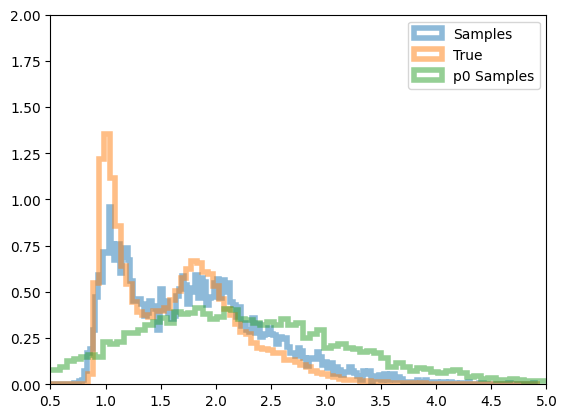

16400 tensor(19.9751, device='cuda:0') tensor(26.6113, device='cuda:0')


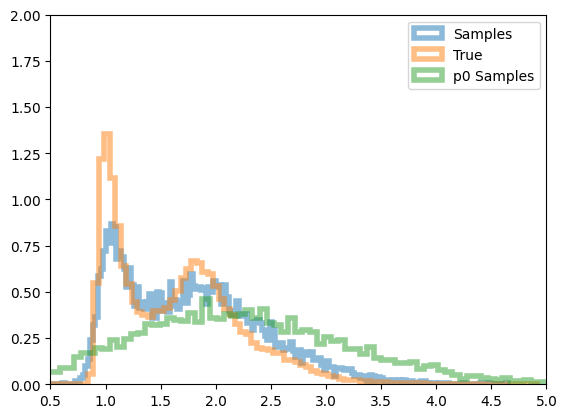

16500 tensor(19.6337, device='cuda:0') tensor(26.7038, device='cuda:0')


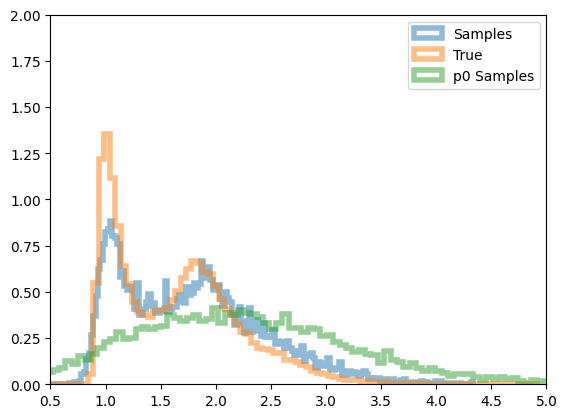

16600 tensor(19.7691, device='cuda:0') tensor(26.6042, device='cuda:0')


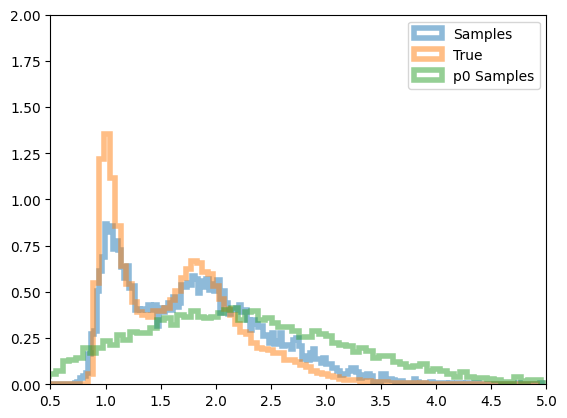

16700 tensor(19.6118, device='cuda:0') tensor(26.6444, device='cuda:0')


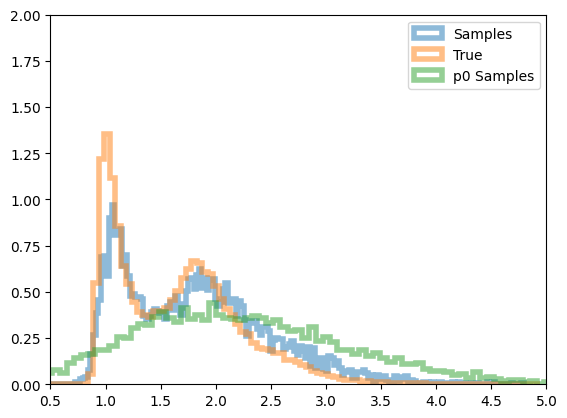

16800 tensor(19.6499, device='cuda:0') tensor(26.7161, device='cuda:0')


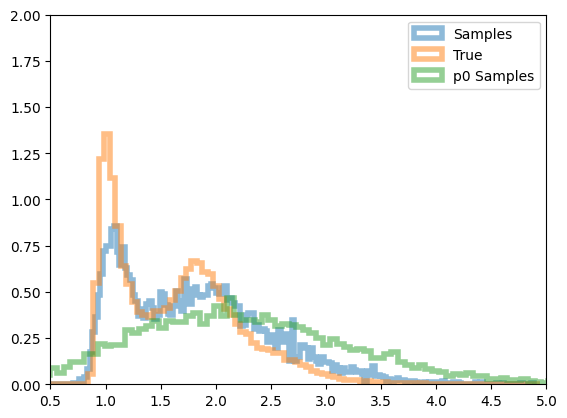

16900 tensor(19.9321, device='cuda:0') tensor(26.7579, device='cuda:0')


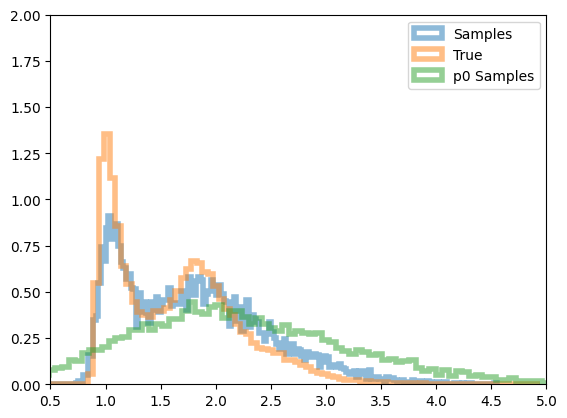

17000 tensor(19.2271, device='cuda:0') tensor(26.5962, device='cuda:0')


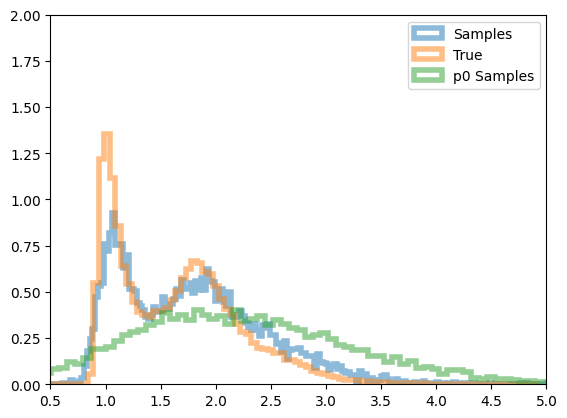

17100 tensor(19.8711, device='cuda:0') tensor(26.7015, device='cuda:0')


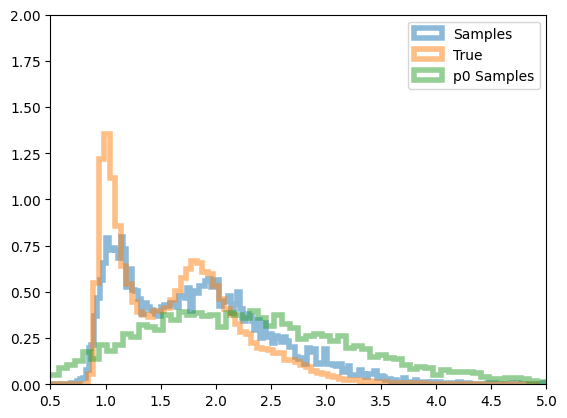

17200 tensor(20.1420, device='cuda:0') tensor(26.7045, device='cuda:0')


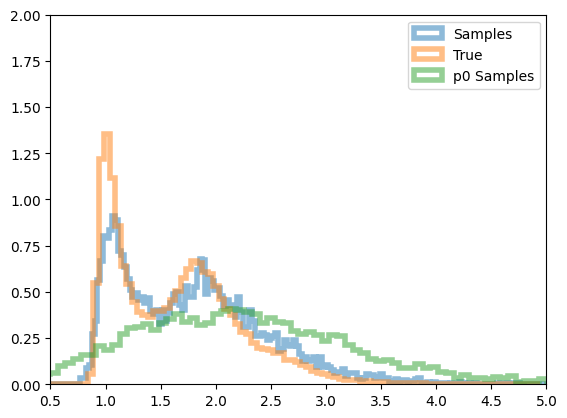

17300 tensor(19.1672, device='cuda:0') tensor(26.4772, device='cuda:0')


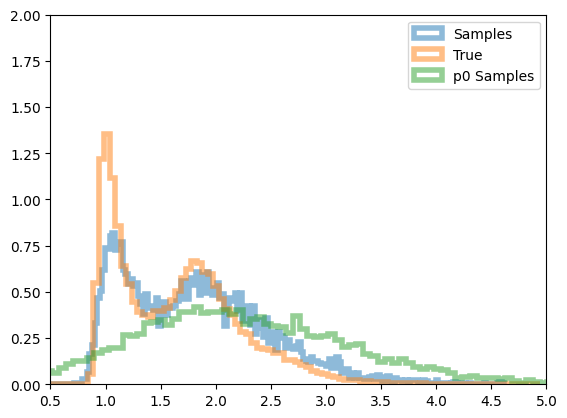

17400 tensor(19.7961, device='cuda:0') tensor(26.5884, device='cuda:0')


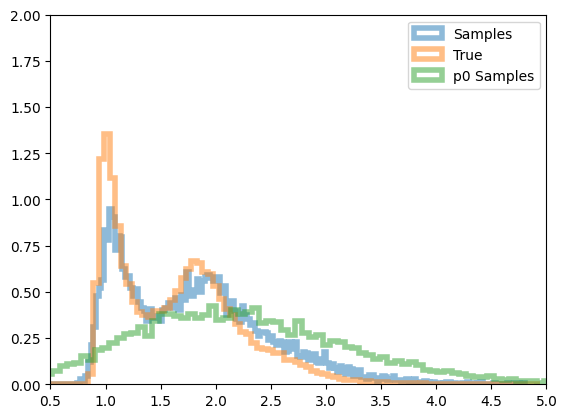

17500 tensor(19.3557, device='cuda:0') tensor(26.5934, device='cuda:0')


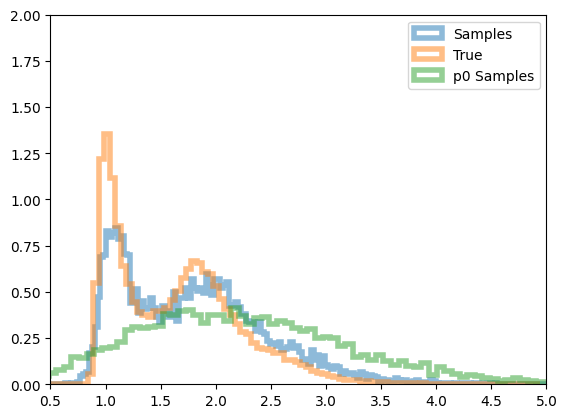

17600 tensor(19.5774, device='cuda:0') tensor(26.5963, device='cuda:0')


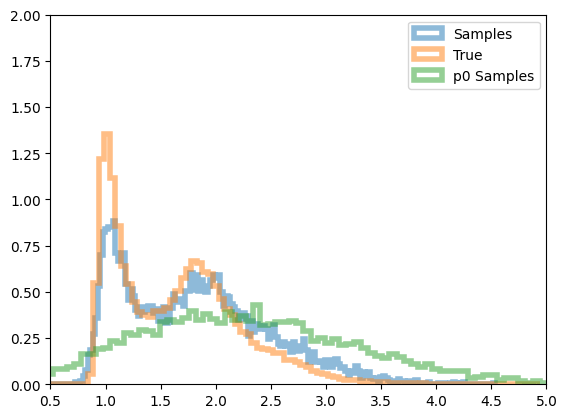

17700 tensor(19.4583, device='cuda:0') tensor(26.4279, device='cuda:0')


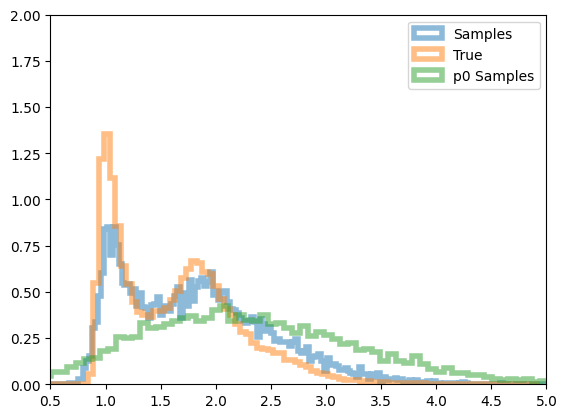

17800 tensor(19.8503, device='cuda:0') tensor(26.7204, device='cuda:0')


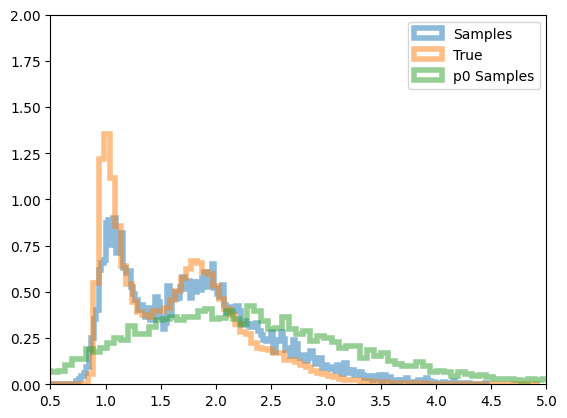

17900 tensor(19.3514, device='cuda:0') tensor(26.5229, device='cuda:0')


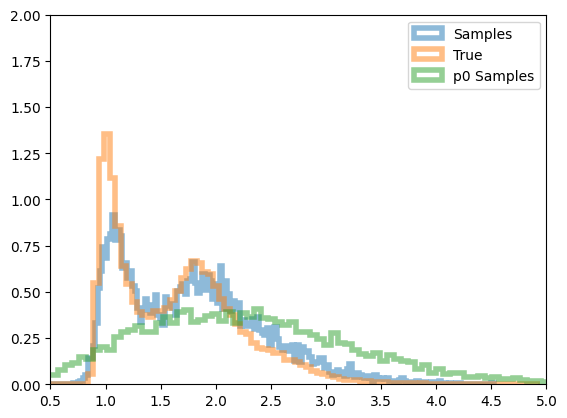

18000 tensor(19.3226, device='cuda:0') tensor(26.5130, device='cuda:0')


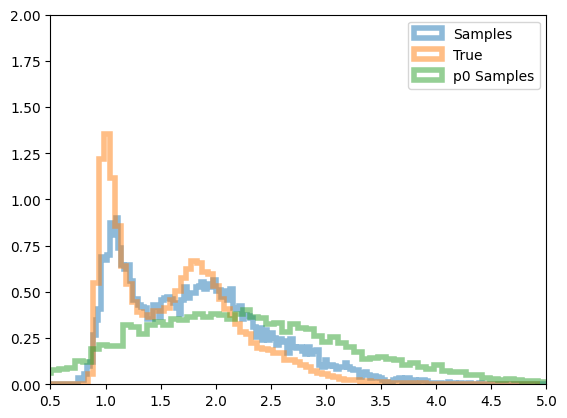

18100 tensor(20.0415, device='cuda:0') tensor(26.7871, device='cuda:0')


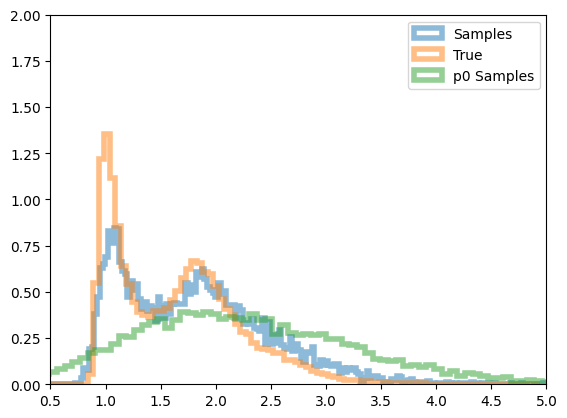

18200 tensor(20.0191, device='cuda:0') tensor(26.6044, device='cuda:0')


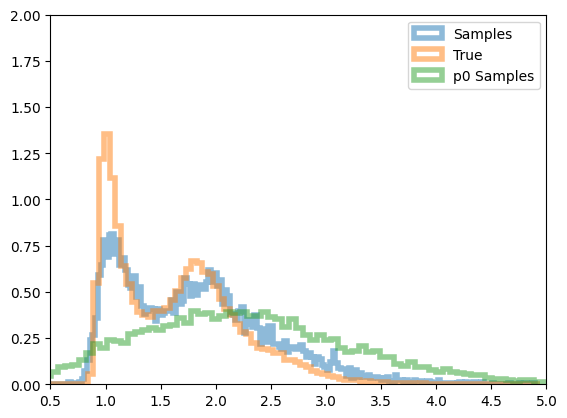

18300 tensor(19.9948, device='cuda:0') tensor(26.8386, device='cuda:0')


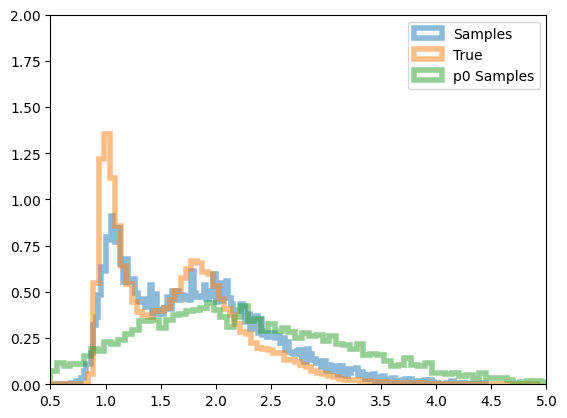

18400 tensor(19.6335, device='cuda:0') tensor(26.6516, device='cuda:0')


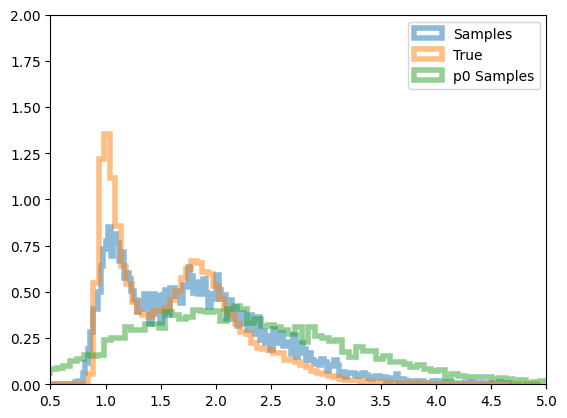

18500 tensor(19.9848, device='cuda:0') tensor(26.7960, device='cuda:0')


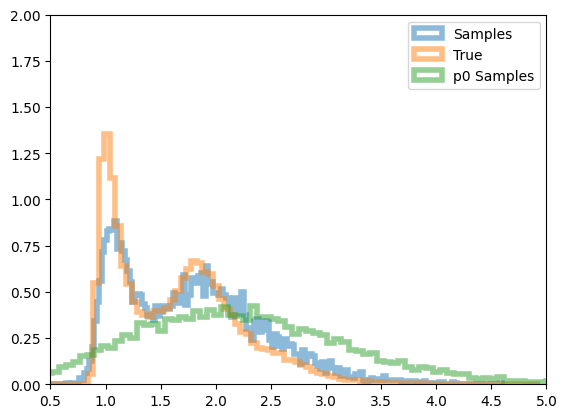

18600 tensor(19.1586, device='cuda:0') tensor(26.5158, device='cuda:0')


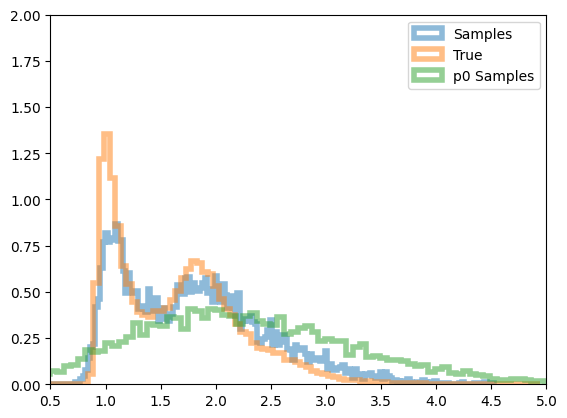

18700 tensor(19.6469, device='cuda:0') tensor(26.6661, device='cuda:0')


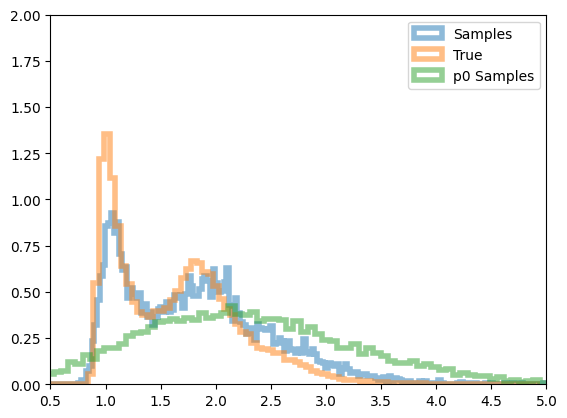

18800 tensor(19.0178, device='cuda:0') tensor(26.4895, device='cuda:0')


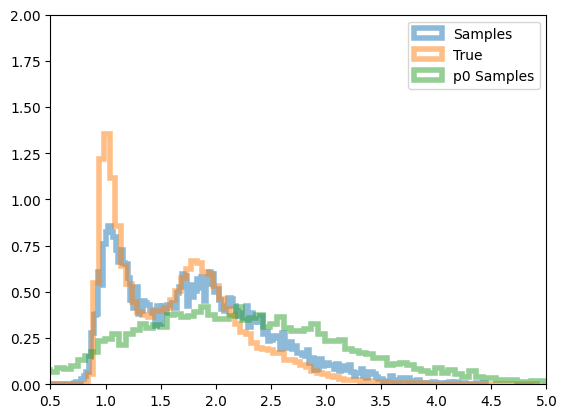

18900 tensor(19.7193, device='cuda:0') tensor(26.6554, device='cuda:0')


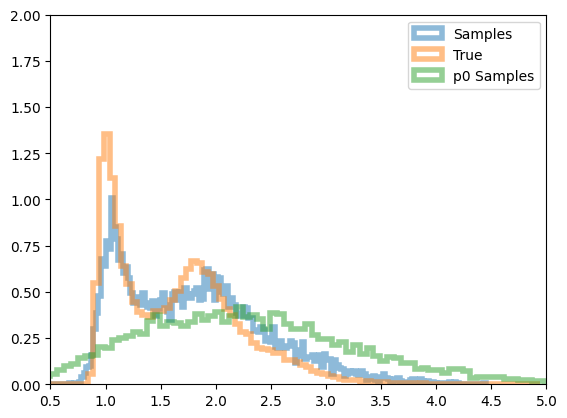

19000 tensor(19.3836, device='cuda:0') tensor(26.4933, device='cuda:0')


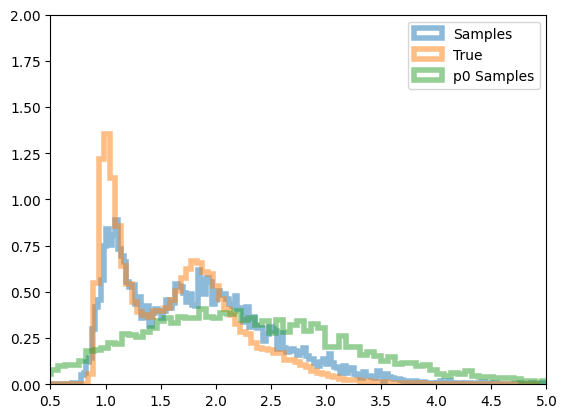

19100 tensor(19.5663, device='cuda:0') tensor(26.6164, device='cuda:0')


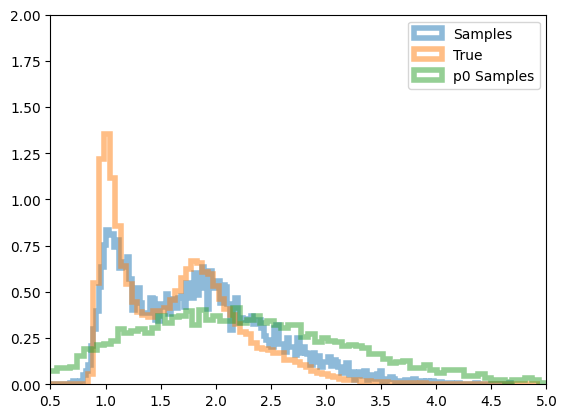

19200 tensor(20.1829, device='cuda:0') tensor(26.8251, device='cuda:0')


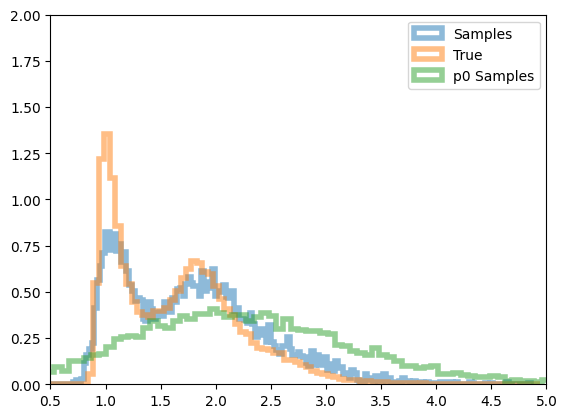

19300 tensor(19.9297, device='cuda:0') tensor(26.5922, device='cuda:0')


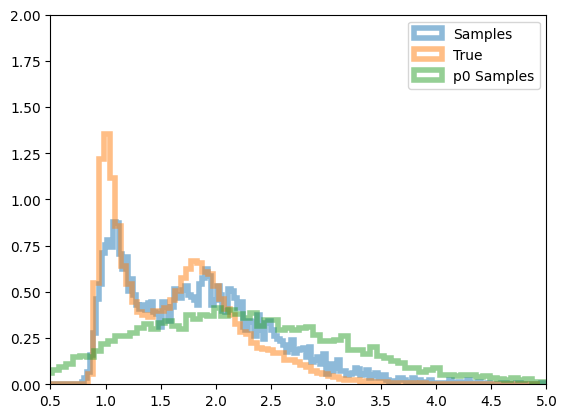

19400 tensor(19.4506, device='cuda:0') tensor(26.6970, device='cuda:0')


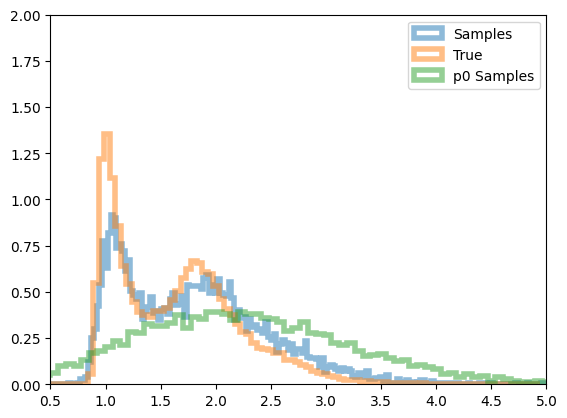

19500 tensor(19.1230, device='cuda:0') tensor(26.4824, device='cuda:0')


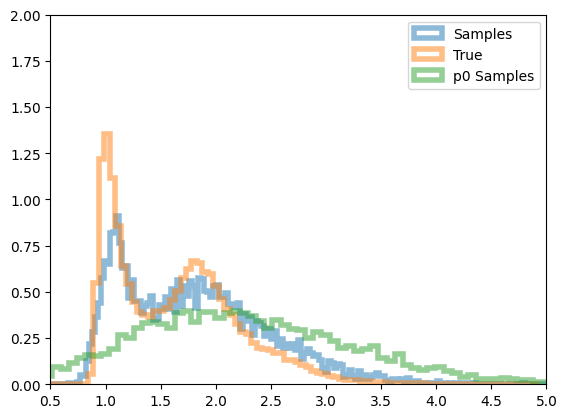

19600 tensor(20.0119, device='cuda:0') tensor(26.9071, device='cuda:0')


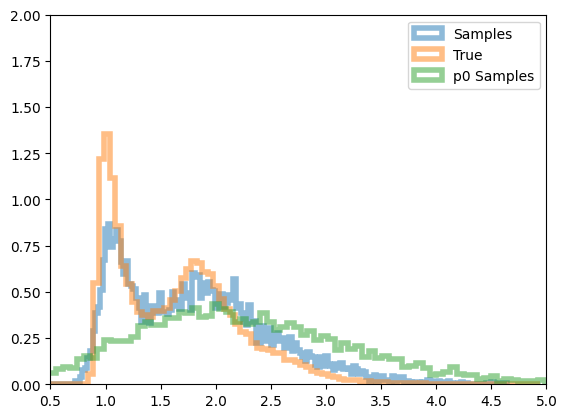

19700 tensor(19.9689, device='cuda:0') tensor(26.7808, device='cuda:0')


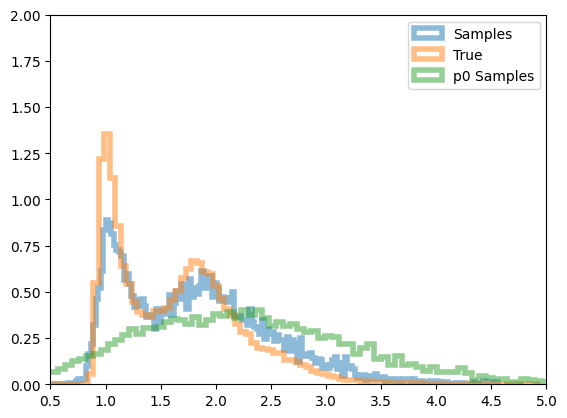

19800 tensor(19.5100, device='cuda:0') tensor(26.7080, device='cuda:0')


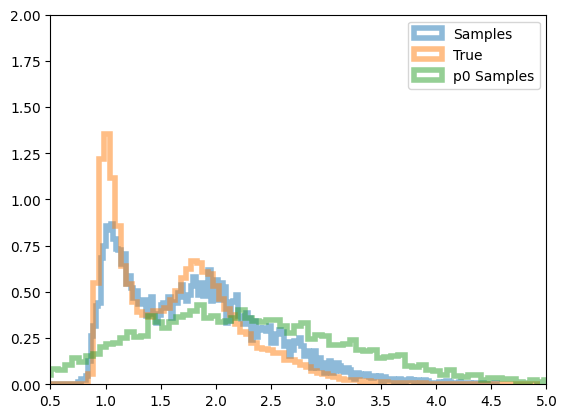

19900 tensor(19.6046, device='cuda:0') tensor(26.6482, device='cuda:0')


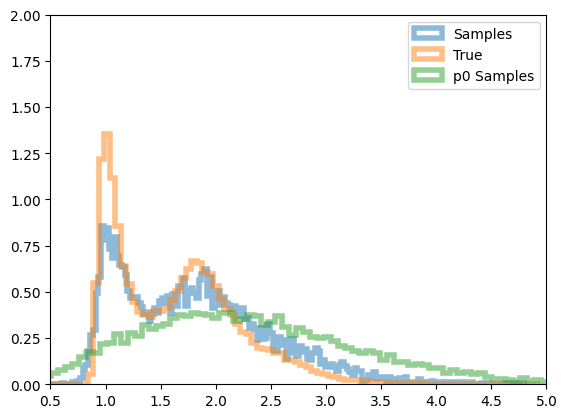

20000 tensor(20.0485, device='cuda:0') tensor(26.9995, device='cuda:0')


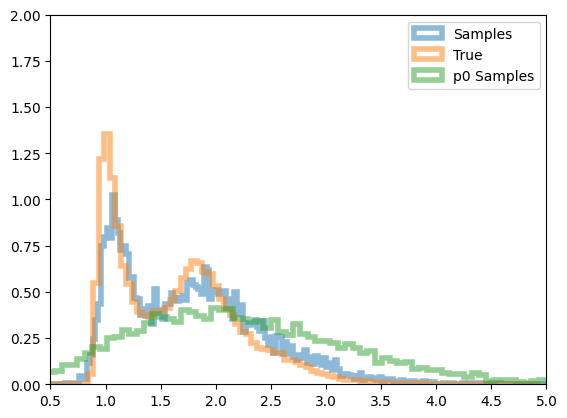

20100 tensor(18.9631, device='cuda:0') tensor(26.5049, device='cuda:0')


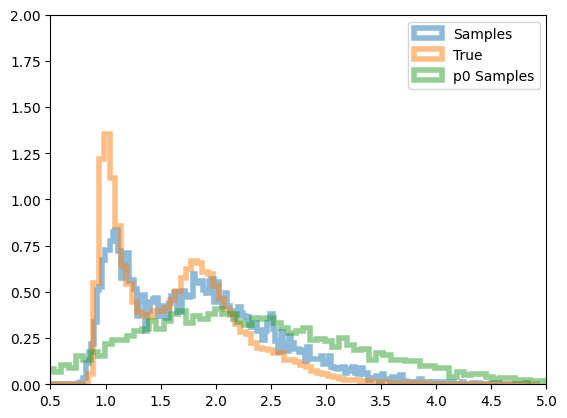

20200 tensor(19.5958, device='cuda:0') tensor(26.5861, device='cuda:0')


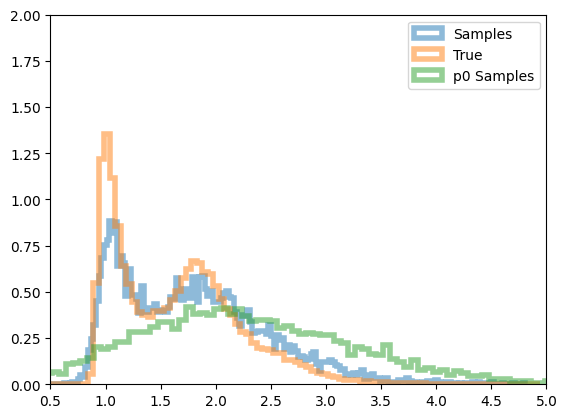

20300 tensor(19.7909, device='cuda:0') tensor(26.7848, device='cuda:0')


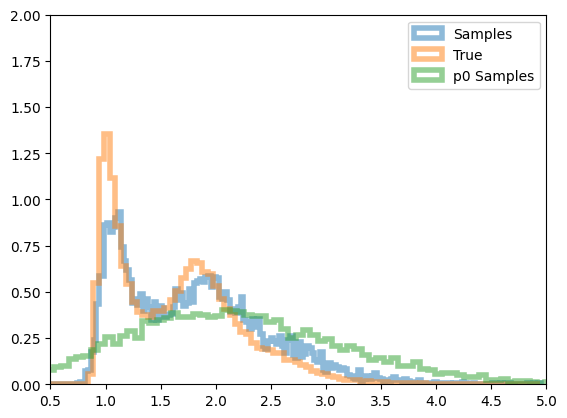

20400 tensor(19.2575, device='cuda:0') tensor(26.6154, device='cuda:0')


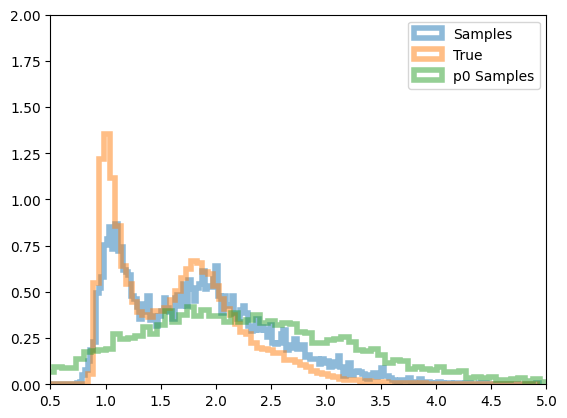

20500 tensor(19.9783, device='cuda:0') tensor(26.7520, device='cuda:0')


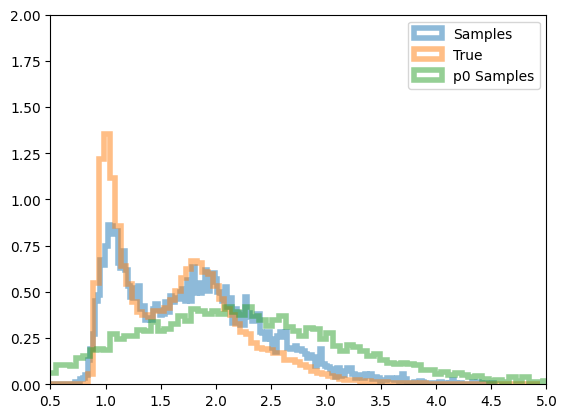

20600 tensor(19.5273, device='cuda:0') tensor(26.6612, device='cuda:0')


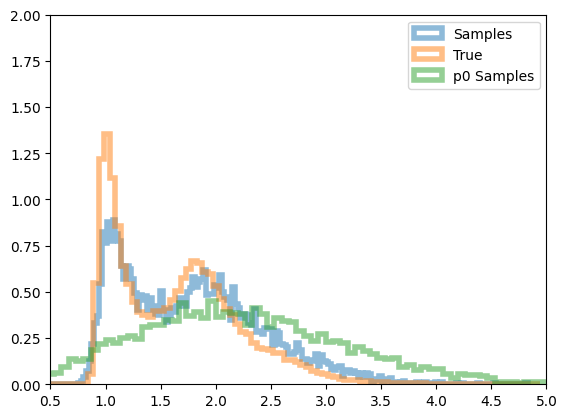

20700 tensor(19.7179, device='cuda:0') tensor(26.5834, device='cuda:0')


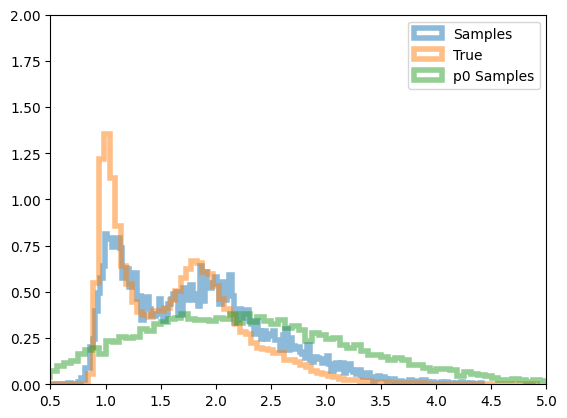

20800 tensor(19.7242, device='cuda:0') tensor(26.5632, device='cuda:0')


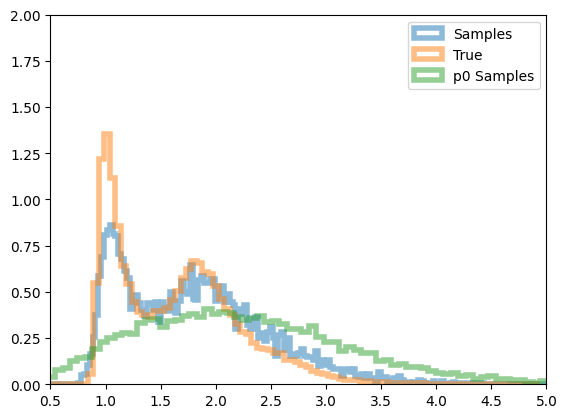

20900 tensor(20.0885, device='cuda:0') tensor(26.7527, device='cuda:0')


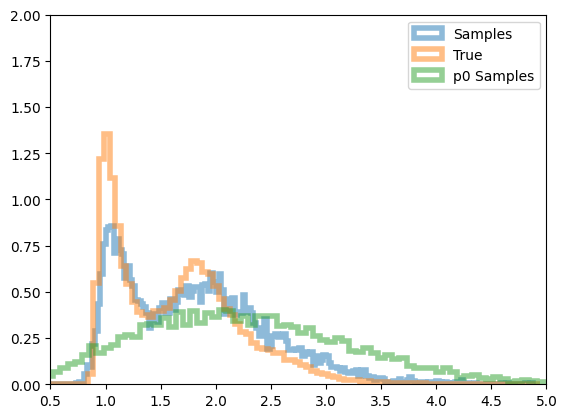

21000 tensor(19.5434, device='cuda:0') tensor(26.6982, device='cuda:0')


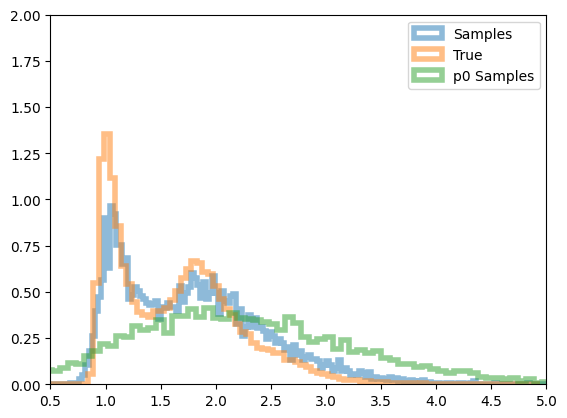

21100 tensor(19.1045, device='cuda:0') tensor(26.4727, device='cuda:0')


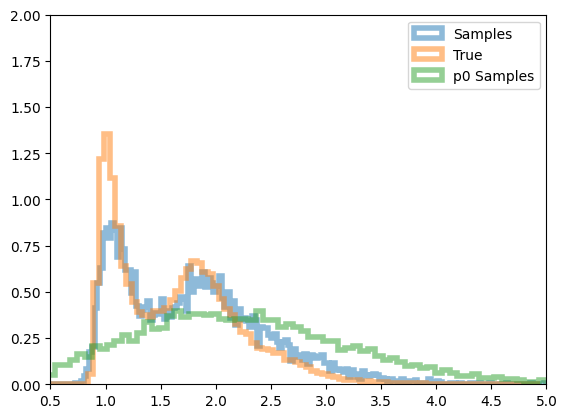

21200 tensor(18.9725, device='cuda:0') tensor(26.3863, device='cuda:0')


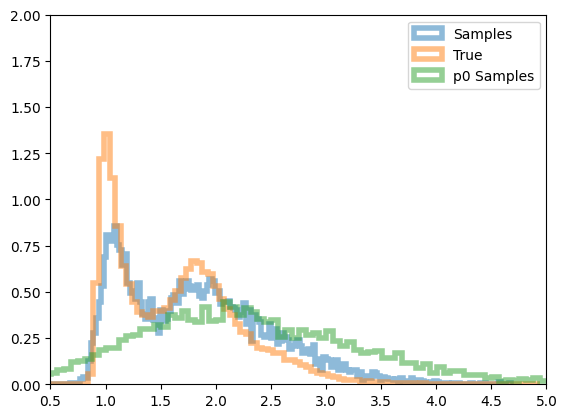

21300 tensor(19.6339, device='cuda:0') tensor(26.7365, device='cuda:0')


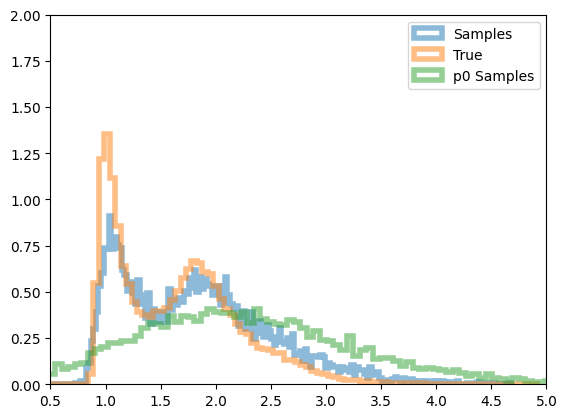

21400 tensor(19.6285, device='cuda:0') tensor(26.6611, device='cuda:0')


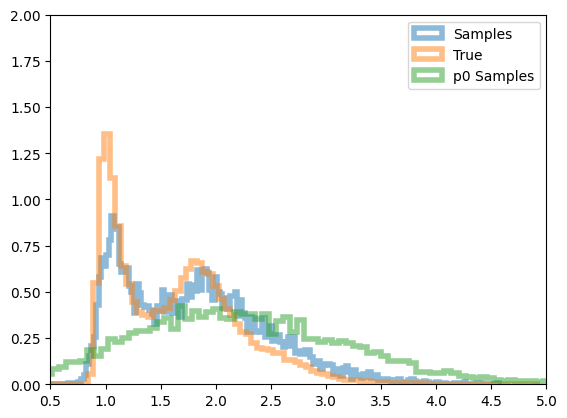

21500 tensor(19.9979, device='cuda:0') tensor(26.6046, device='cuda:0')


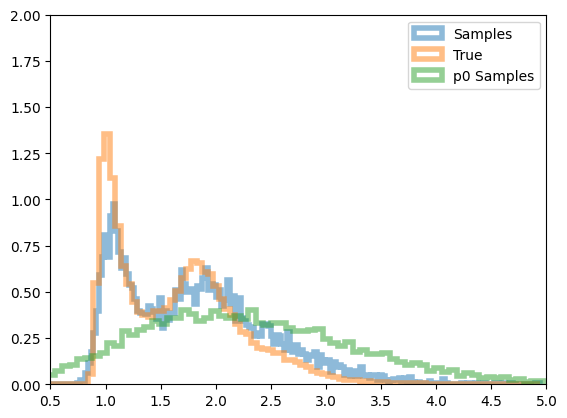

21600 tensor(19.3777, device='cuda:0') tensor(26.4735, device='cuda:0')


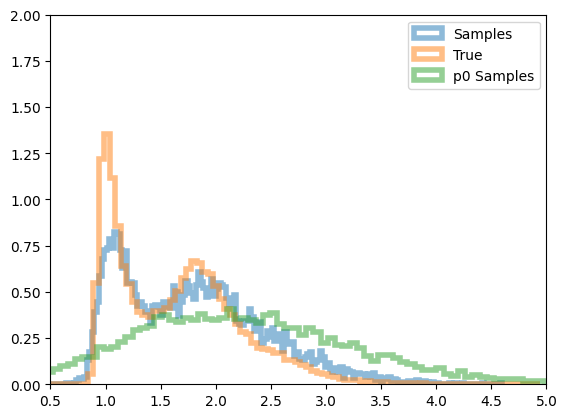

21700 tensor(19.7107, device='cuda:0') tensor(26.6162, device='cuda:0')


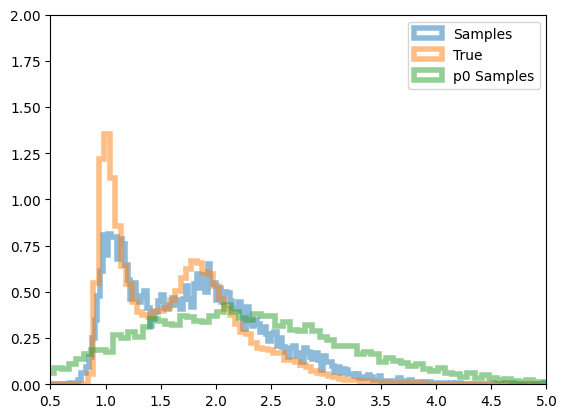

21800 tensor(19.6086, device='cuda:0') tensor(26.5792, device='cuda:0')


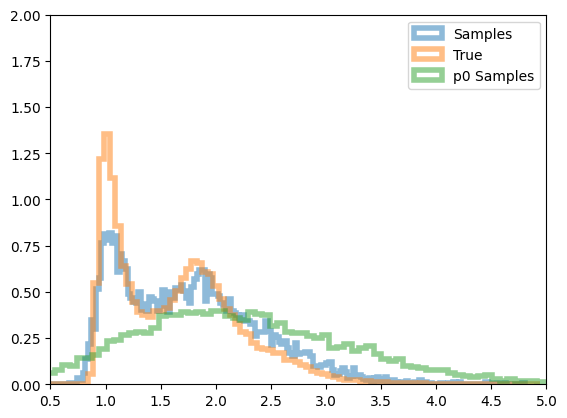

21900 tensor(20.1632, device='cuda:0') tensor(26.7997, device='cuda:0')


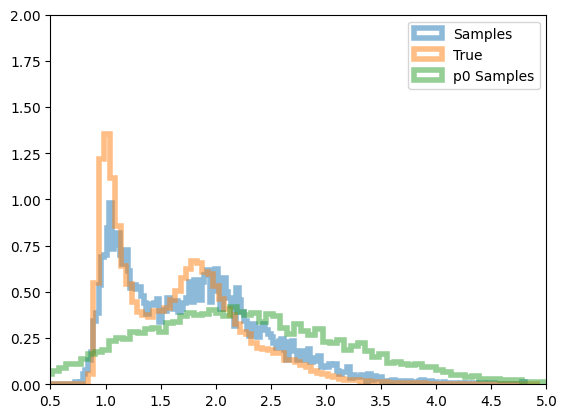

22000 tensor(19.2484, device='cuda:0') tensor(26.5259, device='cuda:0')


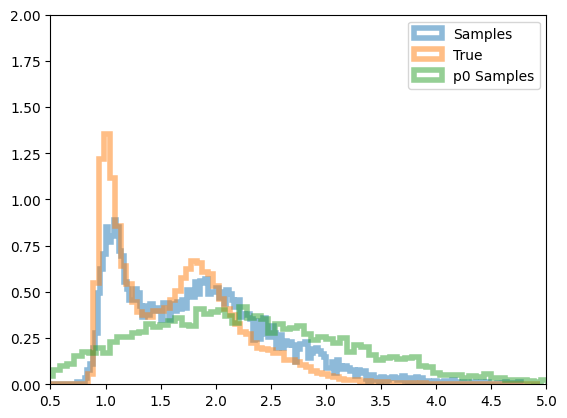

22100 tensor(19.4259, device='cuda:0') tensor(26.6664, device='cuda:0')


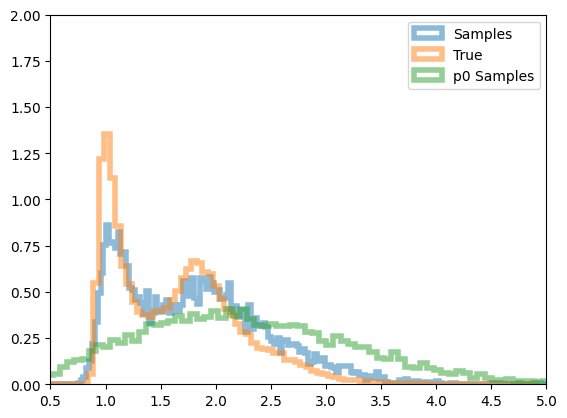

22200 tensor(19.6773, device='cuda:0') tensor(26.5920, device='cuda:0')


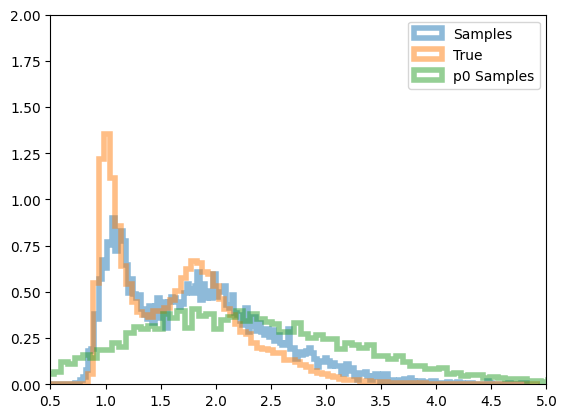

22300 tensor(19.6859, device='cuda:0') tensor(26.7079, device='cuda:0')


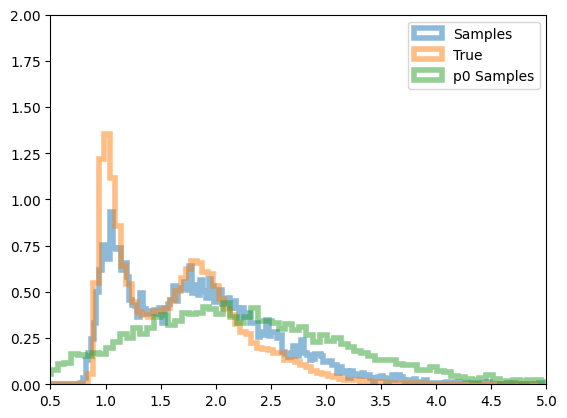

22400 tensor(20.1415, device='cuda:0') tensor(26.8083, device='cuda:0')


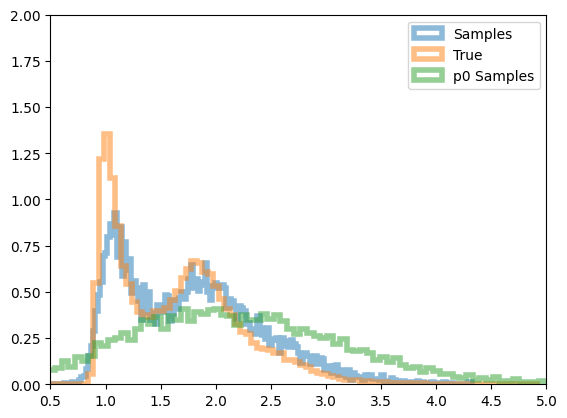

22500 tensor(19.8865, device='cuda:0') tensor(26.6786, device='cuda:0')


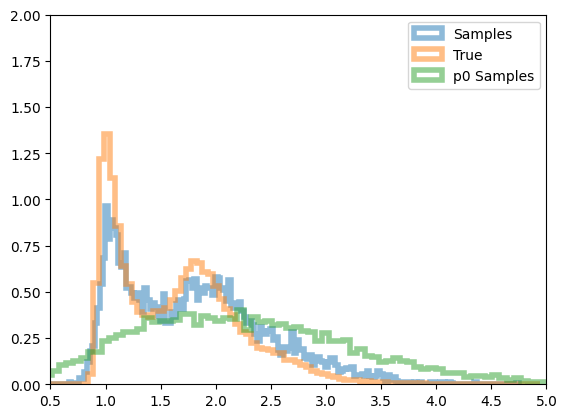

22600 tensor(20.2147, device='cuda:0') tensor(26.7805, device='cuda:0')


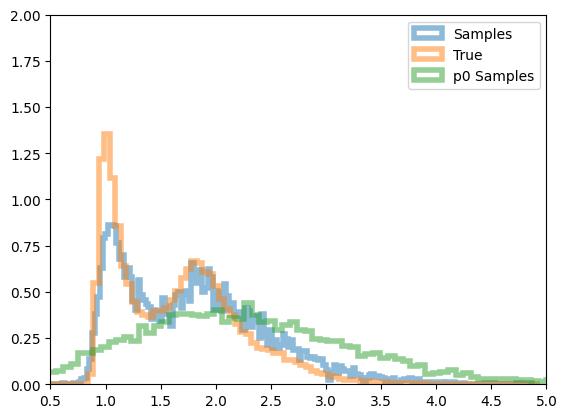

22700 tensor(19.1191, device='cuda:0') tensor(26.4800, device='cuda:0')


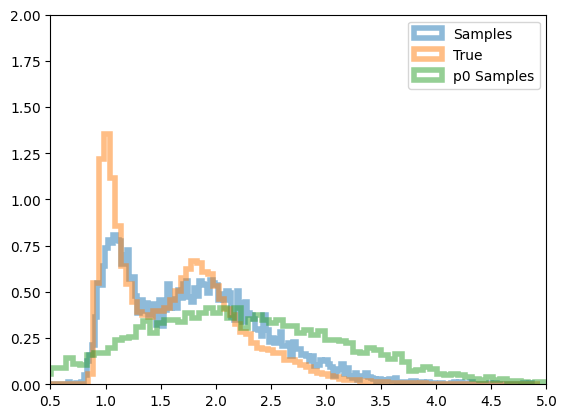

22800 tensor(19.5381, device='cuda:0') tensor(26.5477, device='cuda:0')


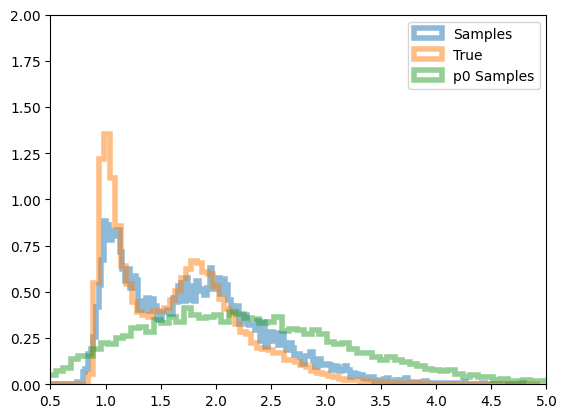

22900 tensor(19.5296, device='cuda:0') tensor(26.4275, device='cuda:0')


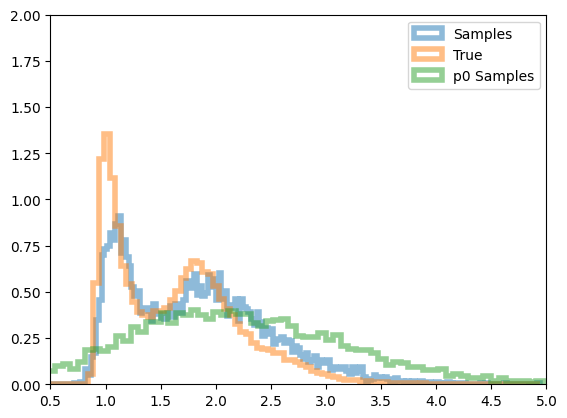

23000 tensor(19.2885, device='cuda:0') tensor(26.7888, device='cuda:0')


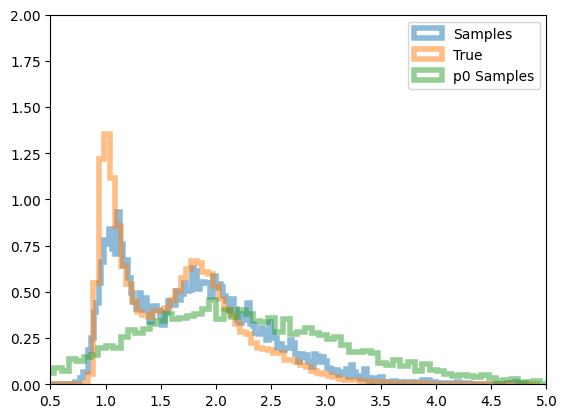

23100 tensor(19.8407, device='cuda:0') tensor(26.6224, device='cuda:0')


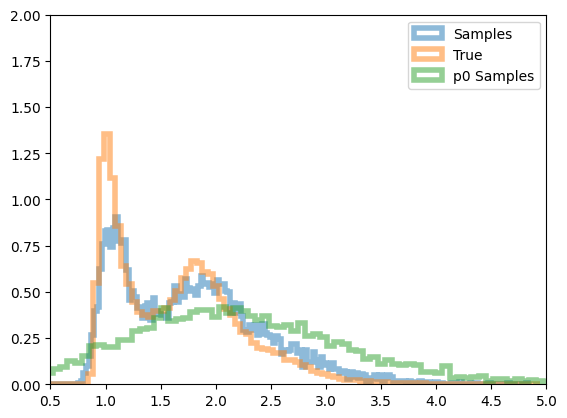

23200 tensor(19.1213, device='cuda:0') tensor(26.4635, device='cuda:0')


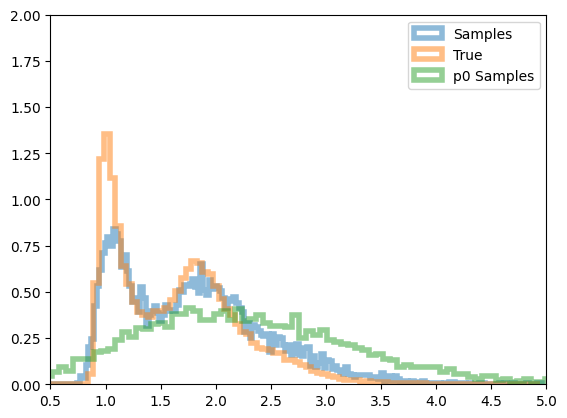

23300 tensor(19.4809, device='cuda:0') tensor(26.6129, device='cuda:0')


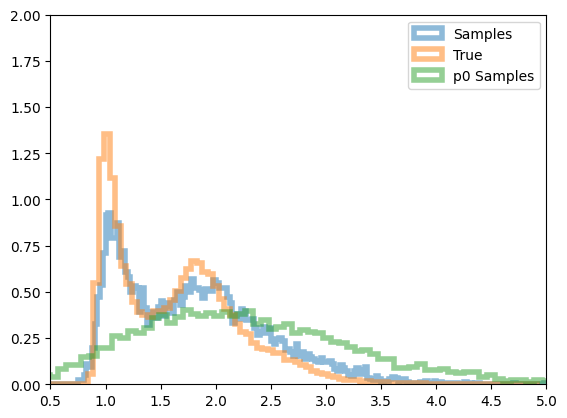

23400 tensor(19.0303, device='cuda:0') tensor(26.4547, device='cuda:0')


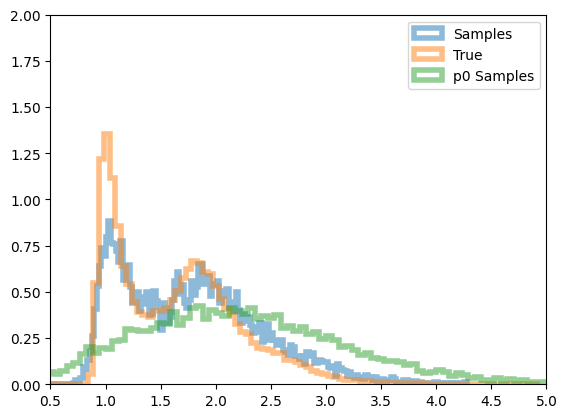

23500 tensor(19.6122, device='cuda:0') tensor(26.6559, device='cuda:0')


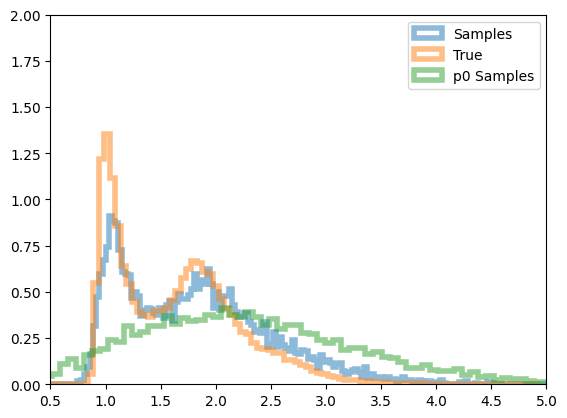

23600 tensor(19.1490, device='cuda:0') tensor(26.5546, device='cuda:0')


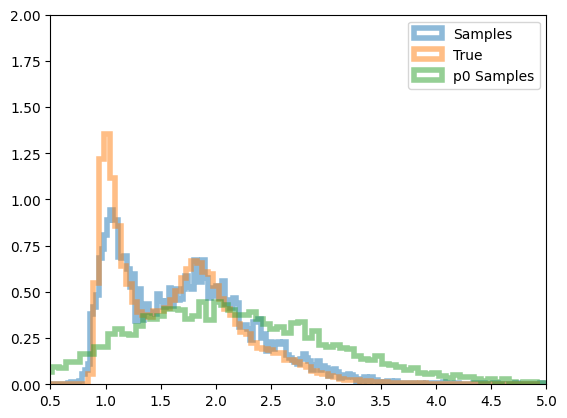

23700 tensor(19.4269, device='cuda:0') tensor(26.5085, device='cuda:0')


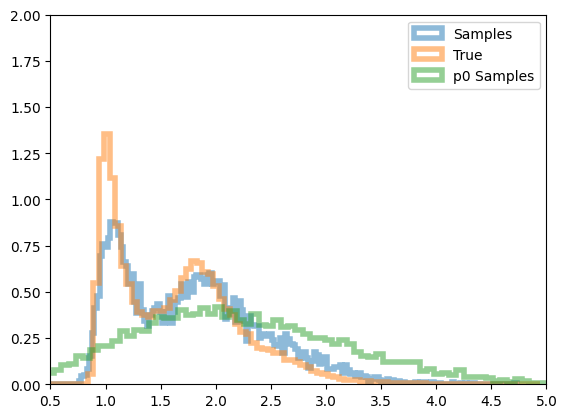

23800 tensor(19.4541, device='cuda:0') tensor(26.5676, device='cuda:0')


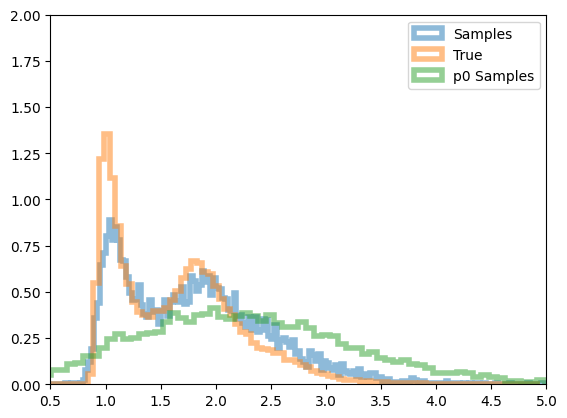

23900 tensor(19.6431, device='cuda:0') tensor(26.5510, device='cuda:0')


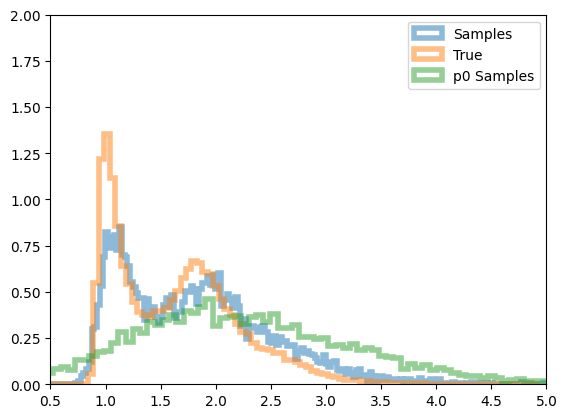

24000 tensor(19.8665, device='cuda:0') tensor(26.6852, device='cuda:0')


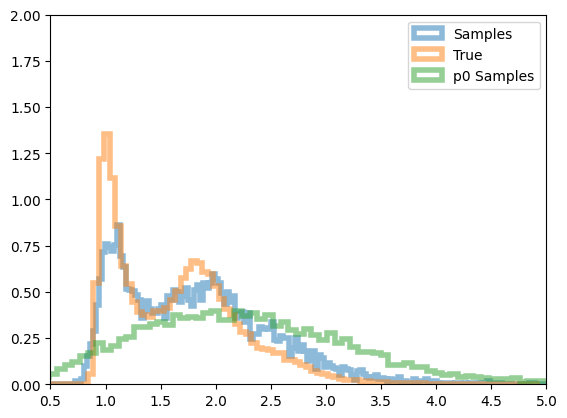

24100 tensor(20.4586, device='cuda:0') tensor(26.7961, device='cuda:0')


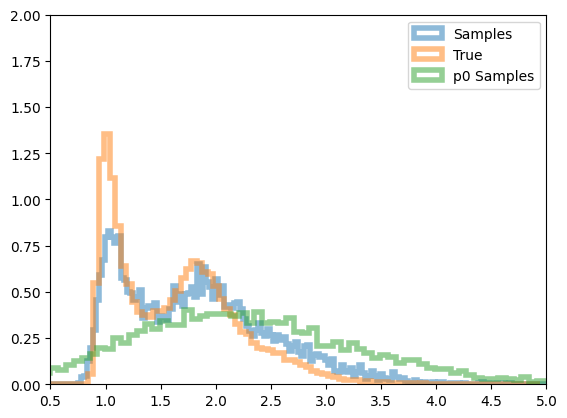

24200 tensor(19.9367, device='cuda:0') tensor(26.8302, device='cuda:0')


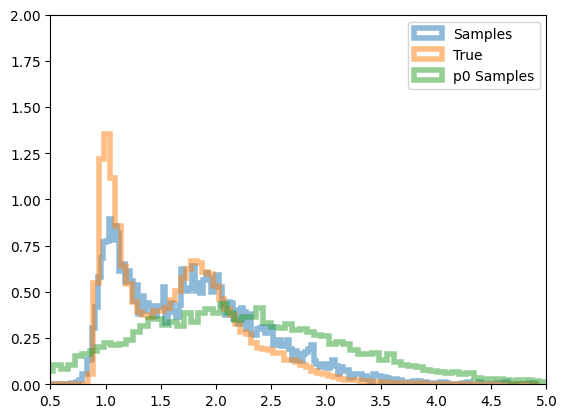

24300 tensor(19.6892, device='cuda:0') tensor(26.6339, device='cuda:0')


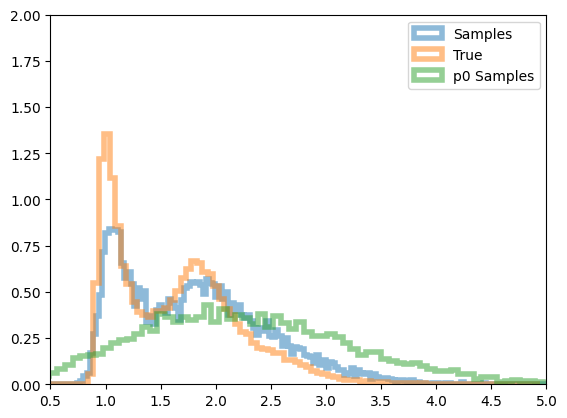

24400 tensor(19.6070, device='cuda:0') tensor(26.7850, device='cuda:0')


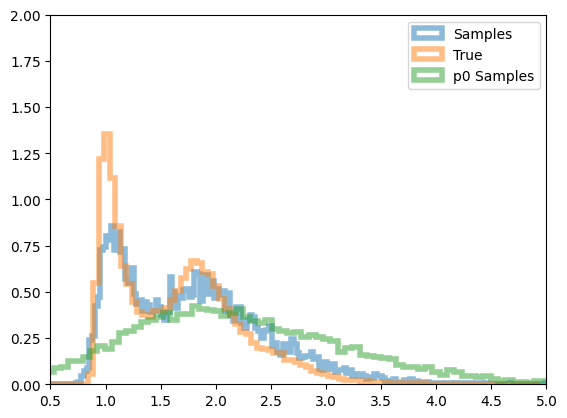

24500 tensor(19.8082, device='cuda:0') tensor(26.6815, device='cuda:0')


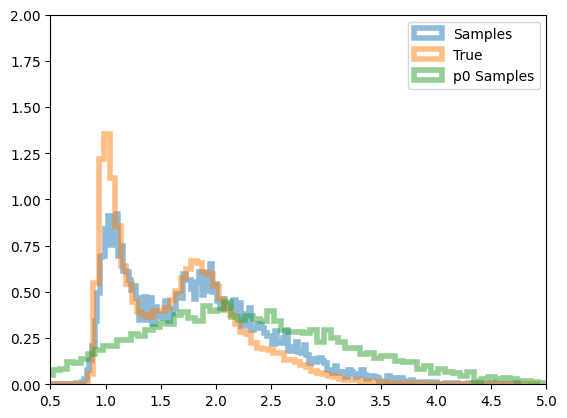

24600 tensor(18.5603, device='cuda:0') tensor(26.4384, device='cuda:0')


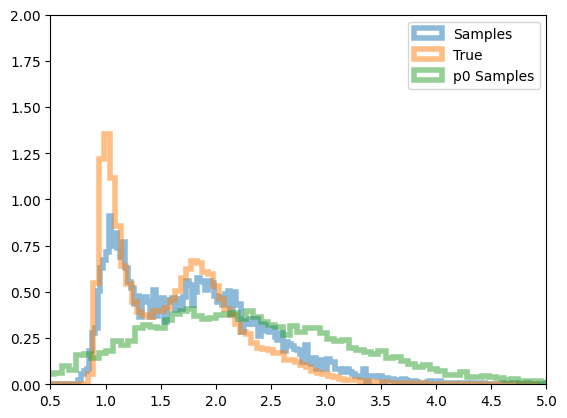

24700 tensor(19.6921, device='cuda:0') tensor(26.6685, device='cuda:0')


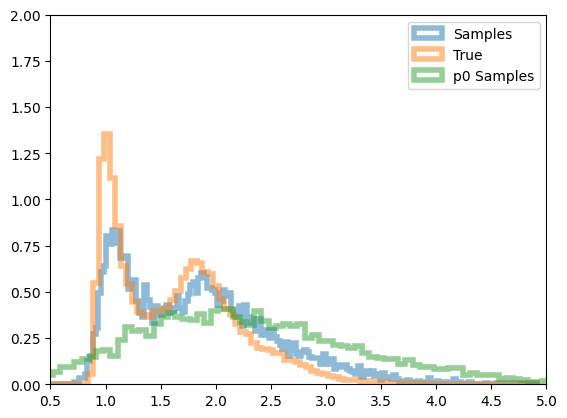

24800 tensor(19.7862, device='cuda:0') tensor(26.7794, device='cuda:0')


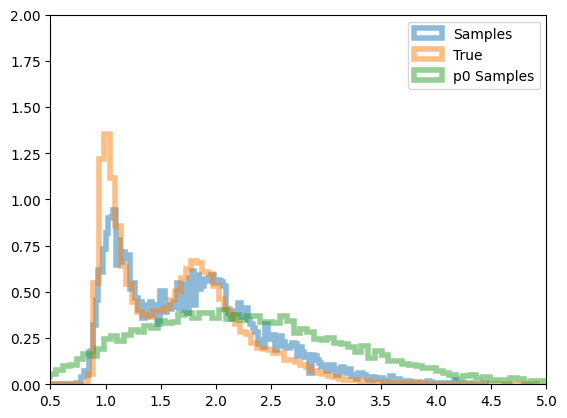

24900 tensor(19.1586, device='cuda:0') tensor(26.3878, device='cuda:0')


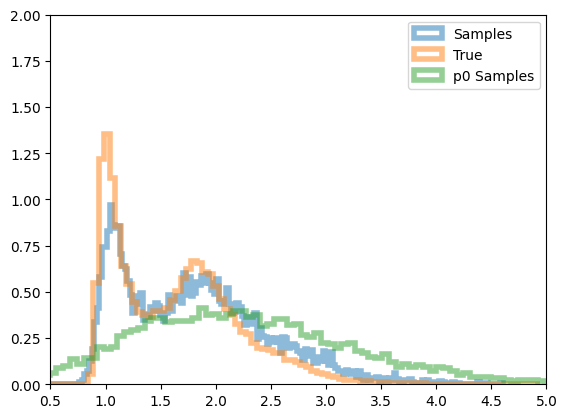

25000 tensor(19.3620, device='cuda:0') tensor(26.6658, device='cuda:0')


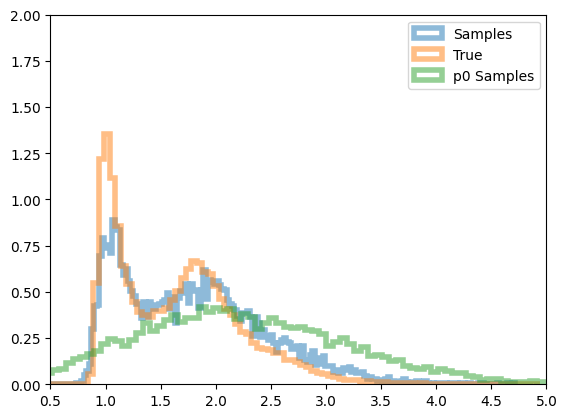

25100 tensor(19.1652, device='cuda:0') tensor(26.5789, device='cuda:0')


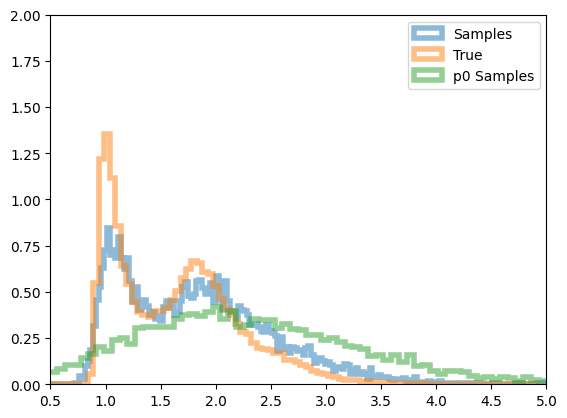

25200 tensor(19.6815, device='cuda:0') tensor(26.6501, device='cuda:0')


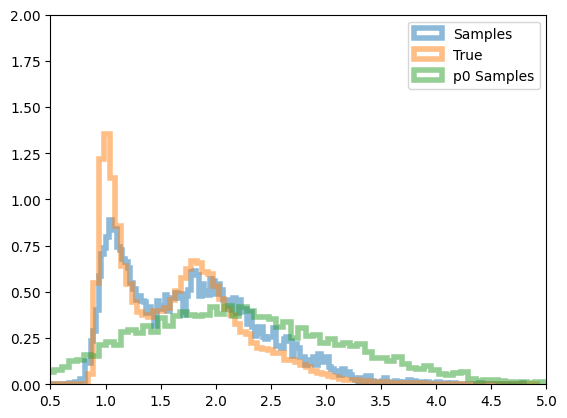

25300 tensor(19.9592, device='cuda:0') tensor(26.7887, device='cuda:0')


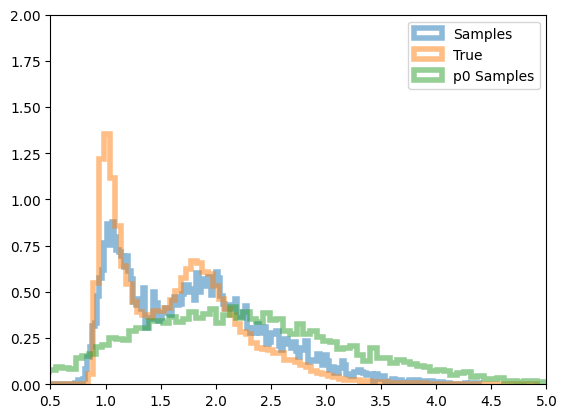

25400 tensor(19.8778, device='cuda:0') tensor(26.7367, device='cuda:0')


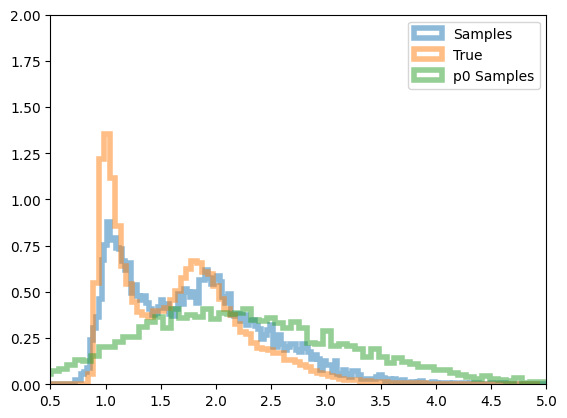

25500 tensor(19.8469, device='cuda:0') tensor(26.6727, device='cuda:0')


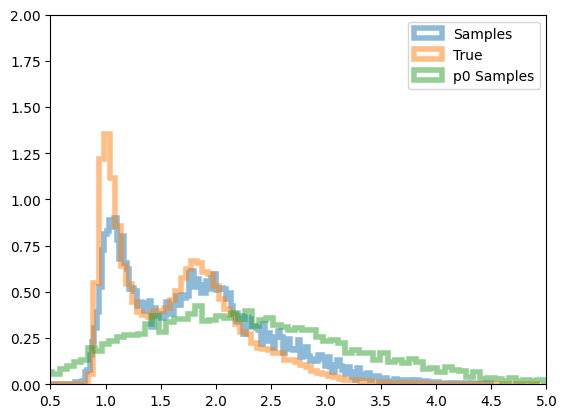

25600 tensor(19.0339, device='cuda:0') tensor(26.4013, device='cuda:0')


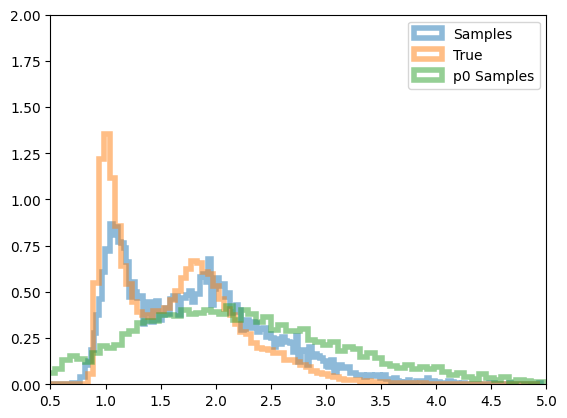

25700 tensor(19.8269, device='cuda:0') tensor(26.8989, device='cuda:0')


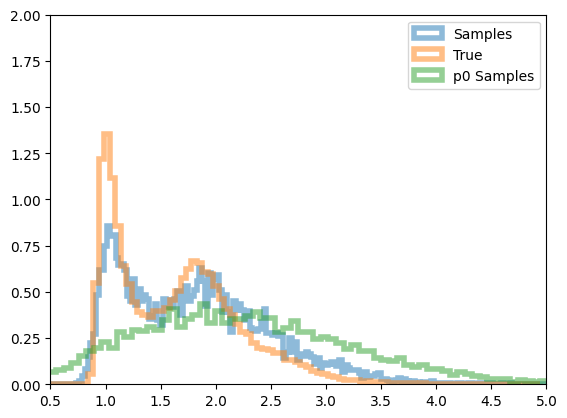

25800 tensor(20.3091, device='cuda:0') tensor(26.8161, device='cuda:0')


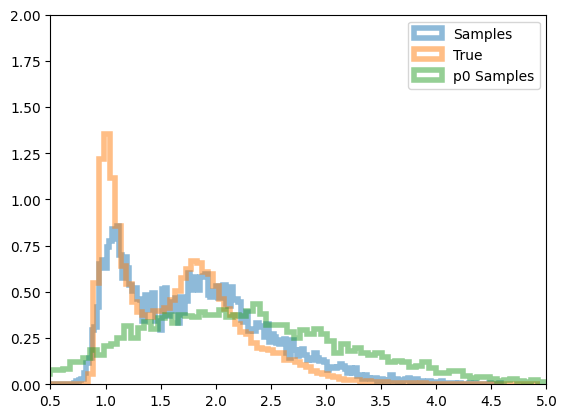

25900 tensor(20.1333, device='cuda:0') tensor(26.8160, device='cuda:0')


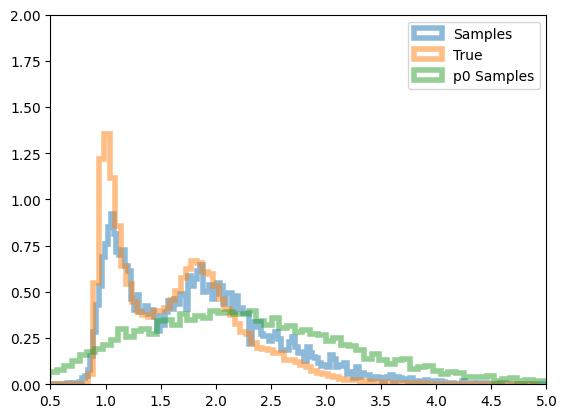

26000 tensor(20.0322, device='cuda:0') tensor(26.7782, device='cuda:0')


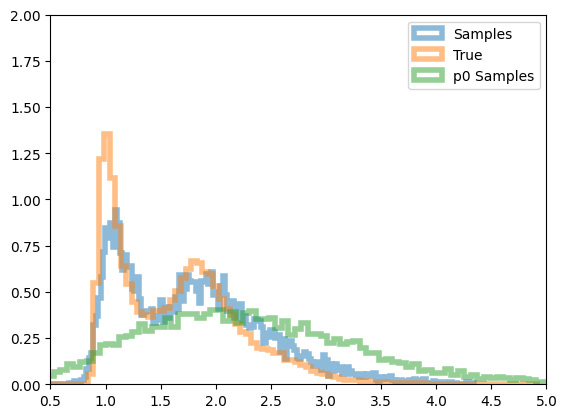

26100 tensor(19.2251, device='cuda:0') tensor(26.5333, device='cuda:0')


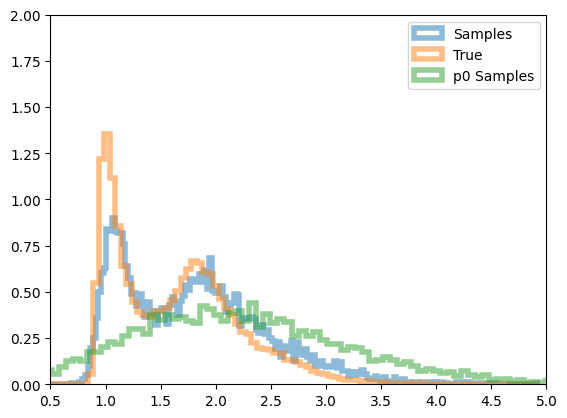

26200 tensor(19.5752, device='cuda:0') tensor(26.7042, device='cuda:0')


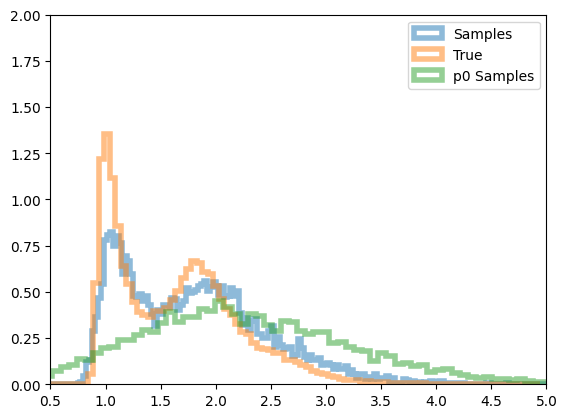

26300 tensor(19.3838, device='cuda:0') tensor(26.4866, device='cuda:0')


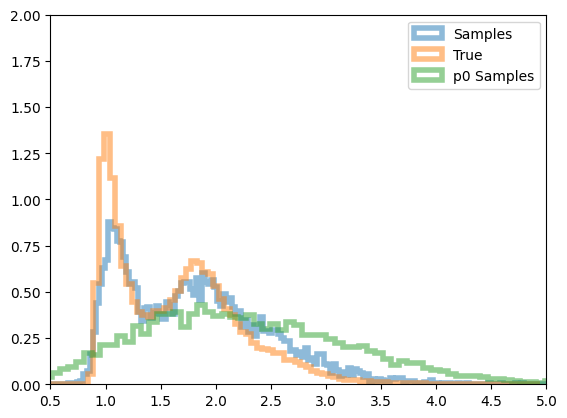

26400 tensor(19.4049, device='cuda:0') tensor(26.4885, device='cuda:0')


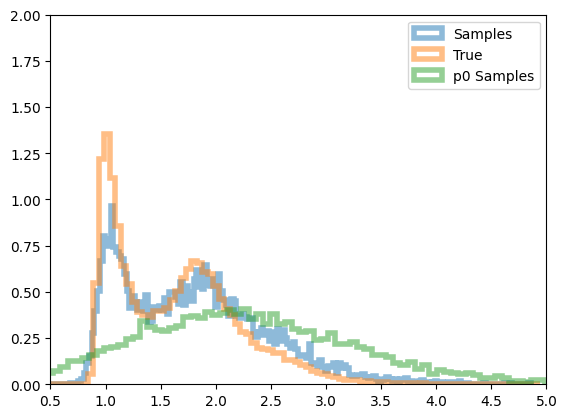

26500 tensor(19.3337, device='cuda:0') tensor(26.5208, device='cuda:0')


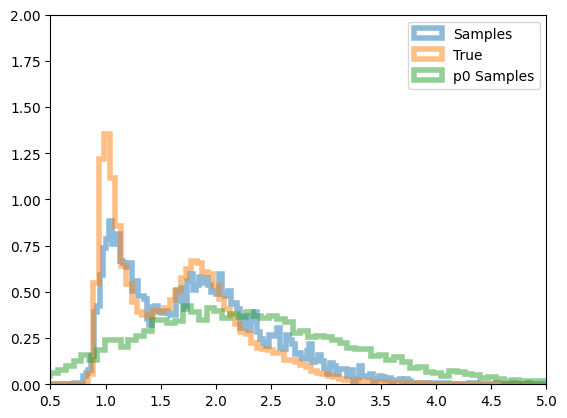

26600 tensor(19.5996, device='cuda:0') tensor(26.5562, device='cuda:0')


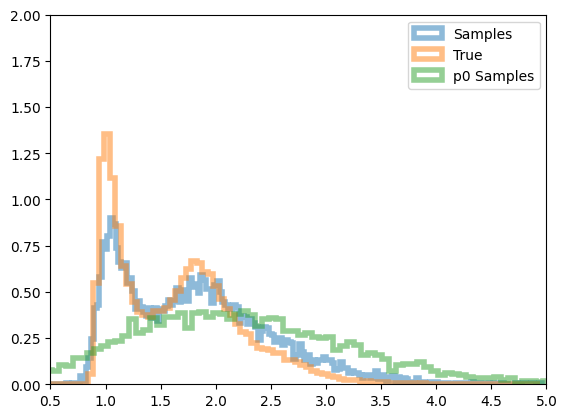

26700 tensor(19.6420, device='cuda:0') tensor(26.7353, device='cuda:0')


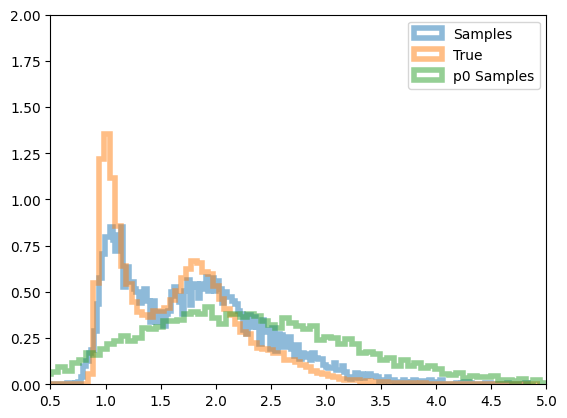

26800 tensor(19.6435, device='cuda:0') tensor(26.5930, device='cuda:0')


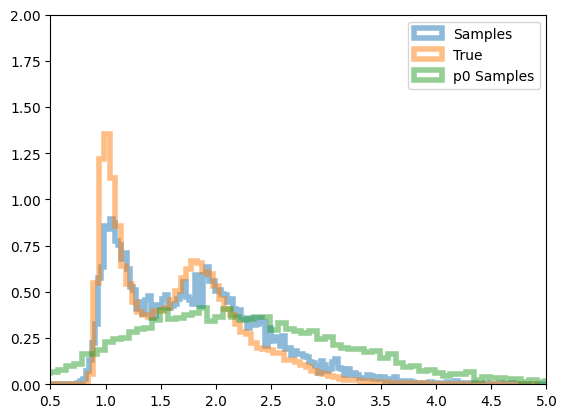

26900 tensor(19.0029, device='cuda:0') tensor(26.4028, device='cuda:0')


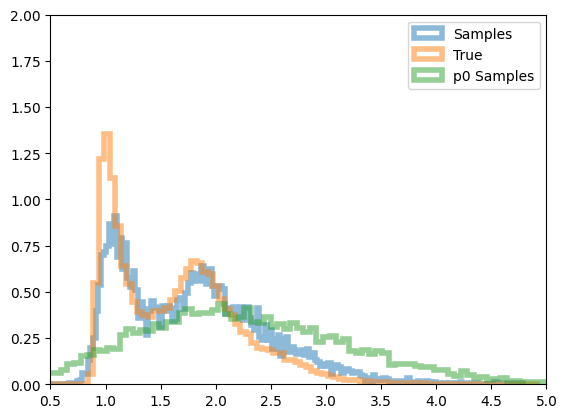

27000 tensor(19.7747, device='cuda:0') tensor(26.7653, device='cuda:0')


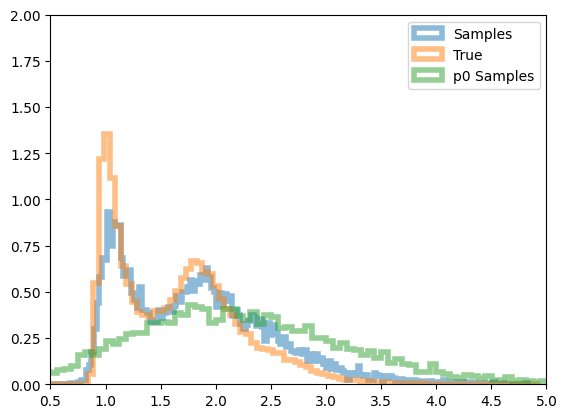

27100 tensor(19.2254, device='cuda:0') tensor(26.8071, device='cuda:0')


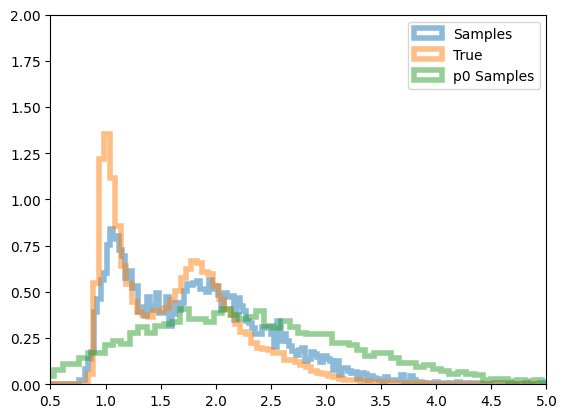

27200 tensor(20.0203, device='cuda:0') tensor(26.7060, device='cuda:0')


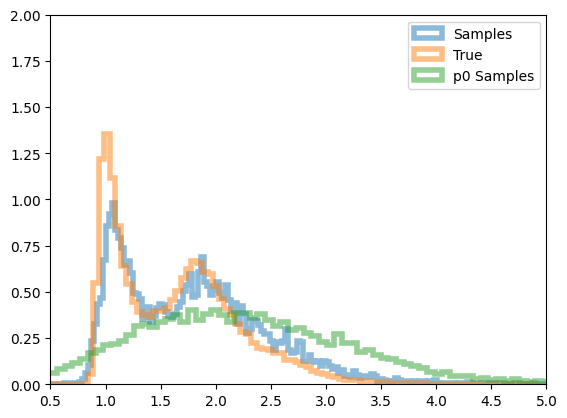

27300 tensor(19.0580, device='cuda:0') tensor(26.4357, device='cuda:0')


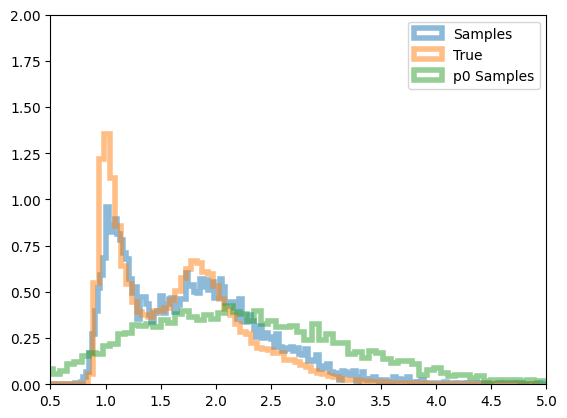

27400 tensor(18.4849, device='cuda:0') tensor(26.5181, device='cuda:0')


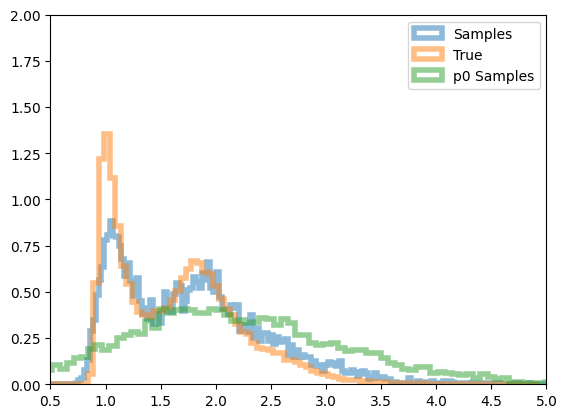

27500 tensor(19.7051, device='cuda:0') tensor(26.6943, device='cuda:0')


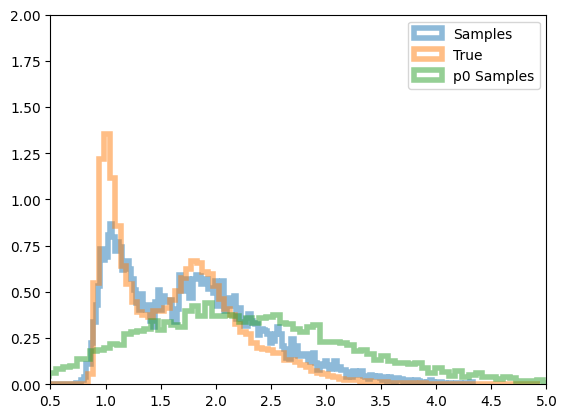

27600 tensor(19.6348, device='cuda:0') tensor(26.5979, device='cuda:0')


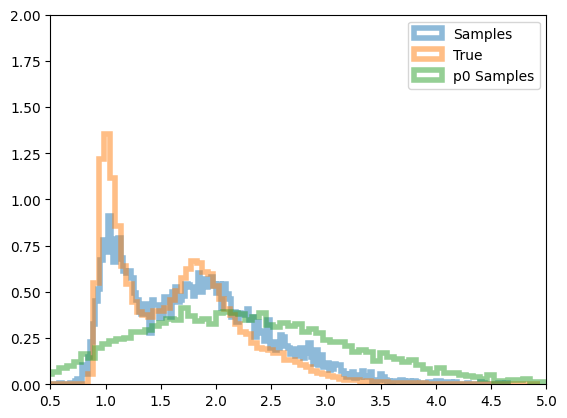

27700 tensor(19.6637, device='cuda:0') tensor(26.5709, device='cuda:0')


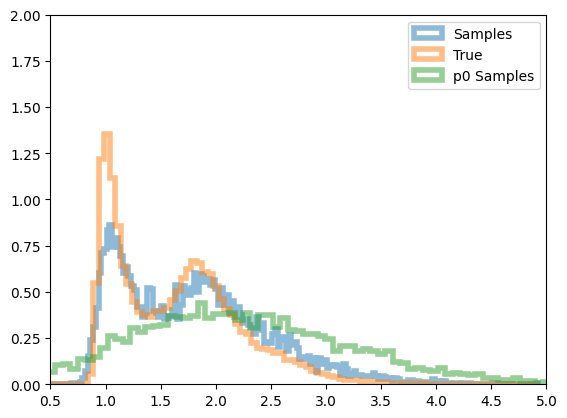

27800 tensor(19.2359, device='cuda:0') tensor(26.6090, device='cuda:0')


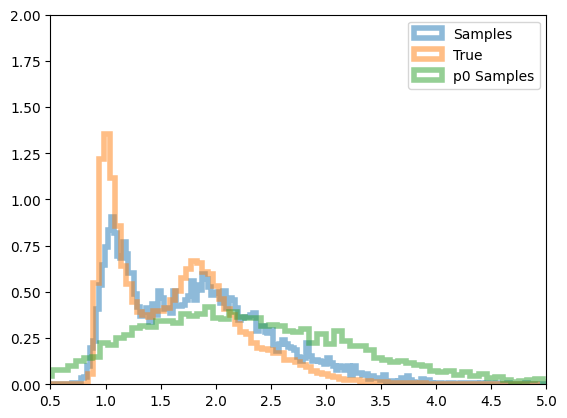

27900 tensor(19.4941, device='cuda:0') tensor(26.5752, device='cuda:0')


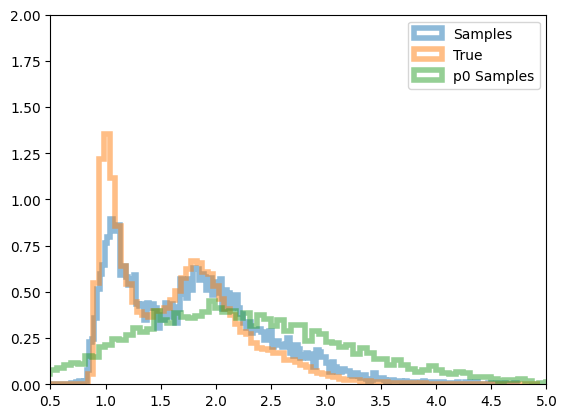

28000 tensor(19.6427, device='cuda:0') tensor(26.6337, device='cuda:0')


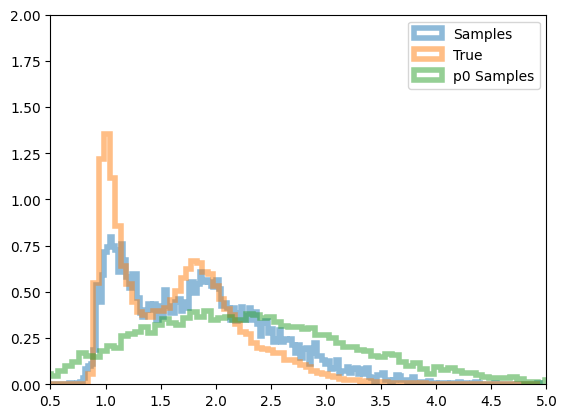

28100 tensor(20.0574, device='cuda:0') tensor(26.8189, device='cuda:0')


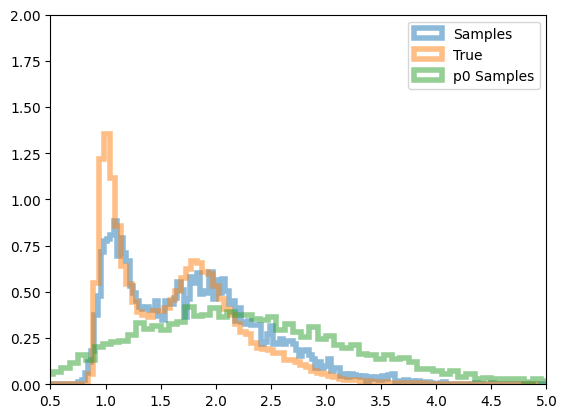

28200 tensor(19.3989, device='cuda:0') tensor(26.4962, device='cuda:0')


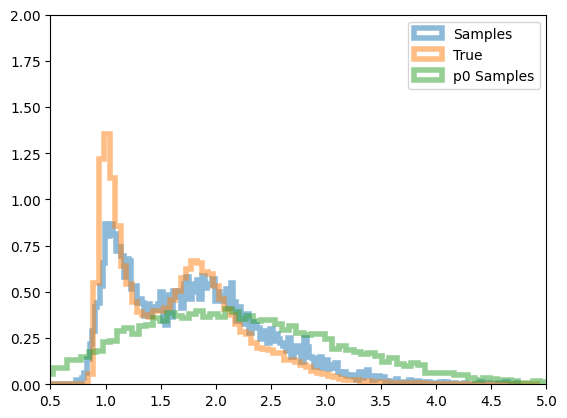

28300 tensor(20.3504, device='cuda:0') tensor(26.7140, device='cuda:0')


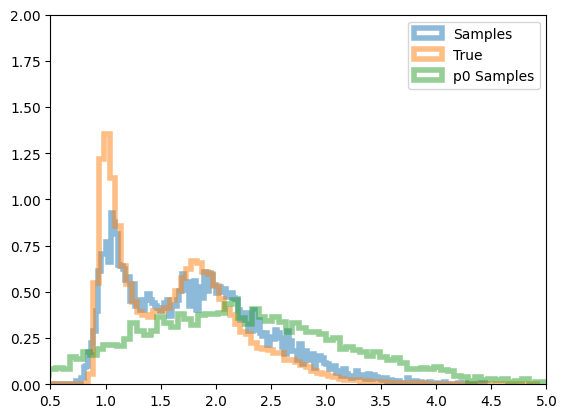

28400 tensor(19.7444, device='cuda:0') tensor(26.5140, device='cuda:0')


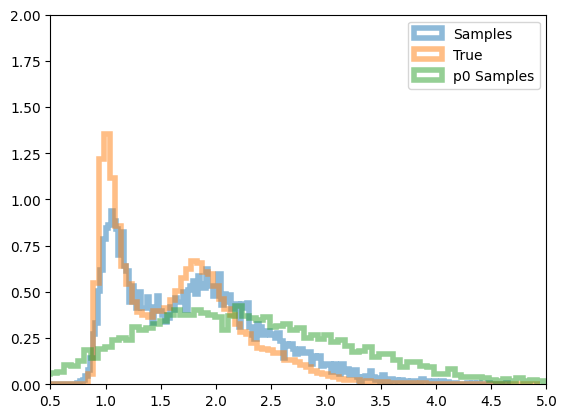

28500 tensor(18.7287, device='cuda:0') tensor(26.3912, device='cuda:0')


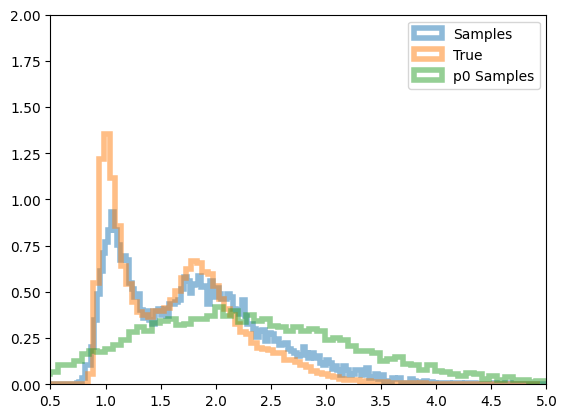

28600 tensor(18.8708, device='cuda:0') tensor(26.5464, device='cuda:0')


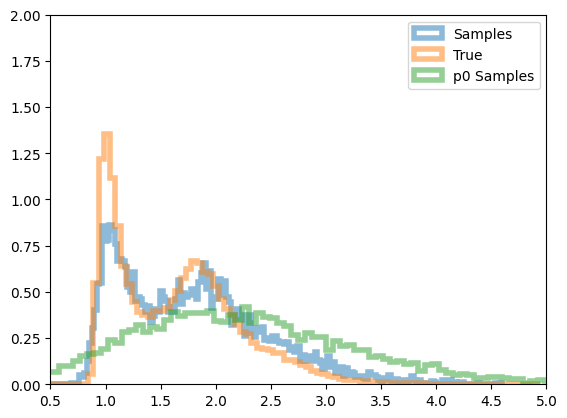

28700 tensor(19.6562, device='cuda:0') tensor(26.6228, device='cuda:0')


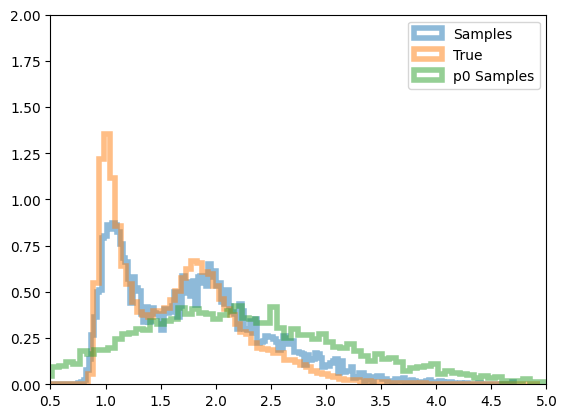

28800 tensor(18.7023, device='cuda:0') tensor(26.4158, device='cuda:0')


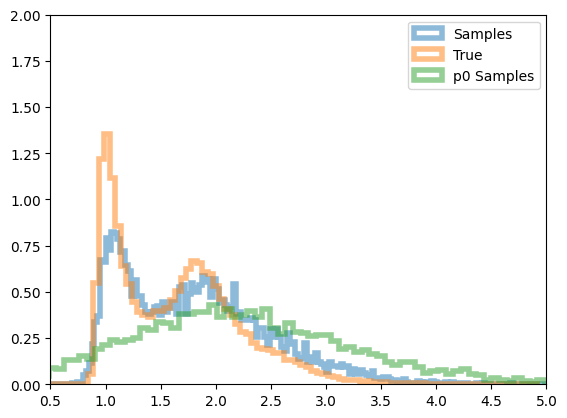

28900 tensor(19.5918, device='cuda:0') tensor(26.7104, device='cuda:0')


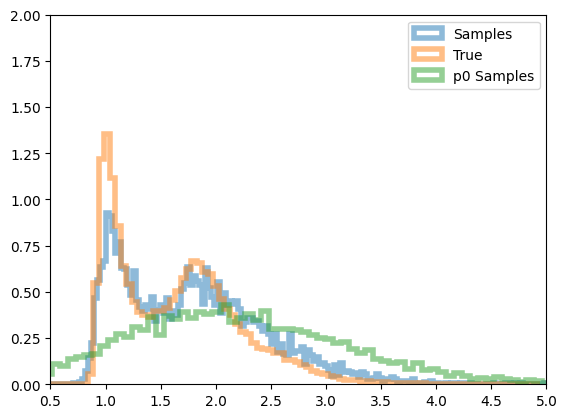

29000 tensor(19.3761, device='cuda:0') tensor(26.4591, device='cuda:0')


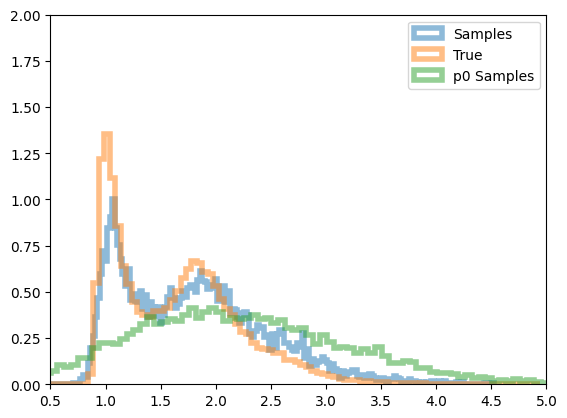

29100 tensor(19.6246, device='cuda:0') tensor(26.6843, device='cuda:0')


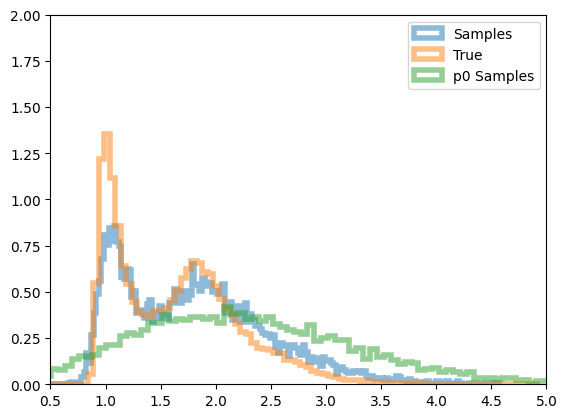

29200 tensor(19.6186, device='cuda:0') tensor(26.6021, device='cuda:0')


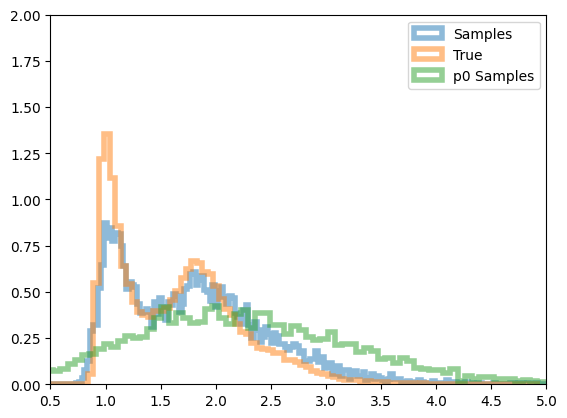

29300 tensor(19.1379, device='cuda:0') tensor(26.4637, device='cuda:0')


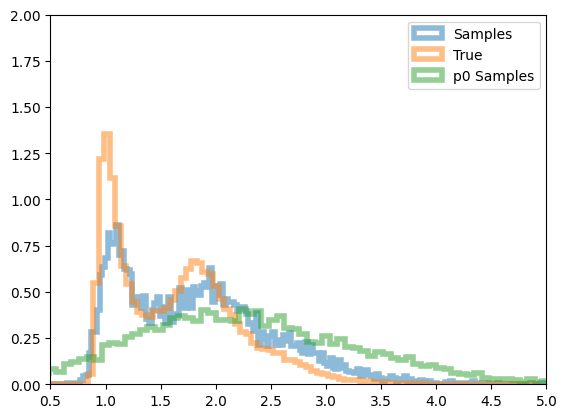

29400 tensor(19.4118, device='cuda:0') tensor(26.5619, device='cuda:0')


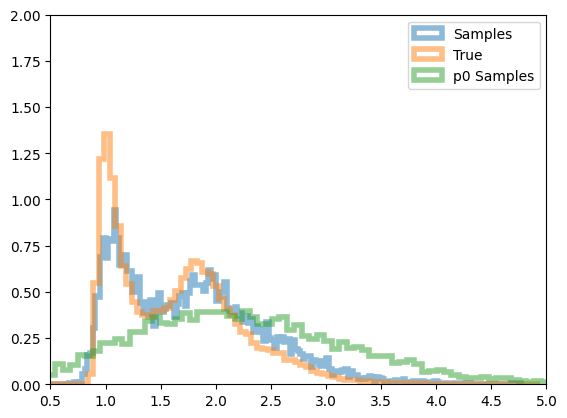

29500 tensor(19.4175, device='cuda:0') tensor(26.5555, device='cuda:0')


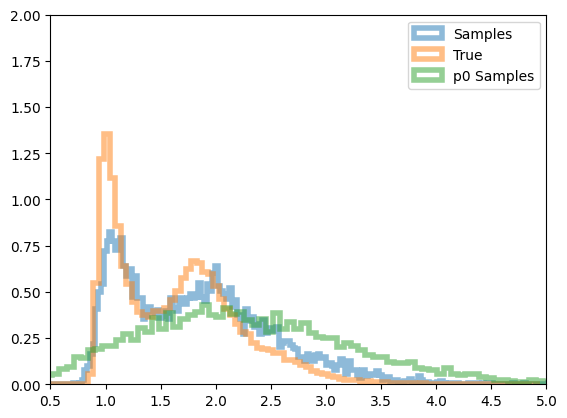

29600 tensor(20.1588, device='cuda:0') tensor(26.9576, device='cuda:0')


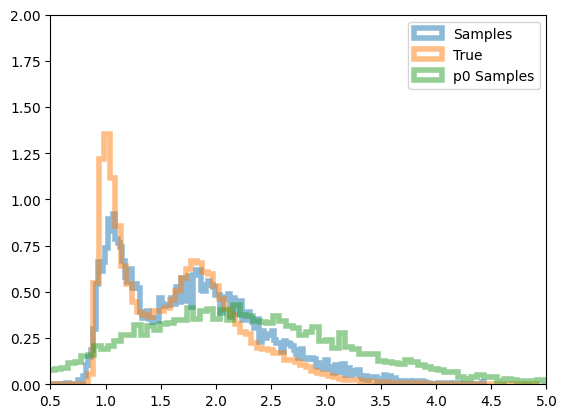

29700 tensor(19.2685, device='cuda:0') tensor(26.3902, device='cuda:0')


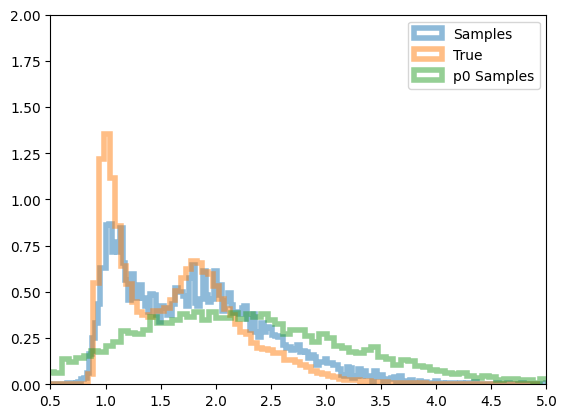

29800 tensor(19.7994, device='cuda:0') tensor(26.6898, device='cuda:0')


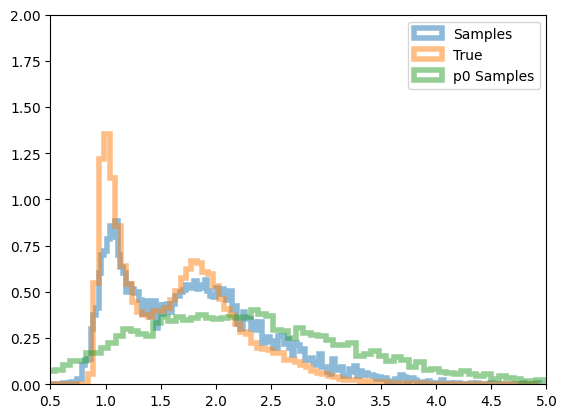

29900 tensor(20.0058, device='cuda:0') tensor(26.6918, device='cuda:0')


In [88]:
start = time.time()
for k in range(30000):
    optimizer.zero_grad()

    perm = torch.randperm(train_data.shape[0])
    idx = perm[:batch_size]
    x1 = train_data[idx].reshape(-1, 13, 3)

    loss = cfm_loss(model, x1)

    loss.backward()
    optimizer.step()

    if k % 100 == 0:
        x1_samples_cfm = sample_centered_gaussian((100, n_nodes, dim)).reshape(-1, 39)
        samples = generate_samples_ode(model, x1_samples_cfm, [0, 1], 1e-3)[-1]
        samples_energy = log_prob(samples.to(device)).detach()
        dist_samples = interatomic_dist(samples.reshape(-1, n_nodes, dim))
        dist_x1 = interatomic_dist(x1_samples_cfm.reshape(-1, n_nodes, dim))
        plt.hist(dist_samples.view(-1).detach().cpu().numpy(), bins=200, alpha=0.5, density=True, histtype='step', linewidth=4, label='Samples')
        plt.hist(test_dists.view(-1).detach().cpu().numpy(), bins=100, alpha=0.5, density=True, histtype='step', linewidth=4, label='True')
        plt.hist(dist_x1.view(-1).detach().cpu().numpy(), bins=100, alpha=0.5, density=True, histtype='step', linewidth=4, label='p0 Samples')
        plt.xlim(0.5, 5)
        plt.ylim(0, 2)
        plt.legend()
        plt.show()


        with torch.no_grad():
            x0 = node.trajectory(torch.cat([torch.zeros((1000, 1)).to(device), 
                                            test_data[:1000].reshape(-1, 39)], dim=1)[:10],
                                            t_span = torch.linspace(1, 0, 21).to(device))
            # x0 = node.trajectory(torch.cat([torch.zeros((1000, 1)), test_data.positions.reshape(-1, 39).cpu()], dim=1)[:10], t_span = torch.linspace(1, 0, 21))
            # this is probably wrong, using nll from Gaussian
            x0_centered = x0[-1, :, 1:]
            x0_centered = x0_centered.reshape(-1, 13, 3)
            x0_centered = x0_centered - x0_centered.mean(dim=-2, keepdims=True)
            
            nll = -(center_gravity_zero_gaussian_log_likelihood(x0_centered) - x0[-1,:, 0])

            # x0_train = node.trajectory(torch.cat([torch.zeros((1000, 1)), train_data.positions[:1000].reshape(-1, 39).cpu()], dim=1)[:10], t_span = torch.linspace(1, 0, 21))
            x0_train = node.trajectory(torch.cat([torch.zeros((1000, 1)).to(device),
                                                  train_data[:1000].reshape(-1, 39)], dim=1)[:10],
                                                  t_span = torch.linspace(1, 0, 21).to(device))
            x0_centered = x0_train[-1, :, 1:]
            x0_centered = x0_centered.reshape(-1, 13, 3)
            x0_centered = x0_centered - x0_centered.mean(dim=-2, keepdims=True)
            nll_train = -(center_gravity_zero_gaussian_log_likelihood(x0_centered) - x0_train[-1,:, 0])
            print(k, nll.mean(), nll_train.mean())